In [1]:
import pandas as pd
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objs as go
import dask.dataframe as dd
import matplotlib.cm as cm
import os

In [2]:
Analise_Potencia = False
Analise_Reserva = False
Analise_Linhas = False
Analise_alldata = False
Analise_INDICE = True
Analise_tabelainfo = False

In [3]:
mainpath = 'C:/Users/david/OneDrive/Documents/FERV_documentos/RESULTS'
dic_cenarios = {
                # 'MPA FNS Lim Scenario 2022' : f'{mainpath}/MPV_(FNS Lim)_RC/',
                # 'V1A1F2 2026' :f'{mainpath}/V1A1F2_RESP_FNS_lim_rev1_2026/',
                # 'V1A1F2 2026' :f'{mainpath}/V1A1F2_RESP_FNS_lim_rev2_2026/',
                # 'V1A1F3 2026' :f'{mainpath}/V1A1F3_RESP_FNS_lim_rev1_2026/',
                # 'V1A1F4 2026' :f'{mainpath}/V1A1F4_RESP_FNS_lim_rev1_2026/',
                # 'V1A1F5 2026' :f'{mainpath}/V1A1F5_RESP_FNS_lim_rev1_2026/',

                'V1A1F2' :f'{mainpath}/V1A1F2_rev5/',
                'V1A1F3' :f'{mainpath}/V1A1F3_rev5/',
                'V1A1F4' :f'{mainpath}/V1A1F4_rev5/',
                'V1A1F5' :f'{mainpath}/V1A1F5_rev5/',

                # 'V2A2F2 2026' :f'{mainpath}/V2A2F2_REV02_2026/',
                # 'V2A2F3 2026' :f'{mainpath}/V2A2F3_REV02_2026/',
                # 'V2A2F4 2026' :f'{mainpath}/V2A2F4_REV02_2026/', 
                # 'V2A2F5 2026' :f'{mainpath}/V2A2F5_REV02_2026/',

                'V2A2F2' :f'{mainpath}/V2A2F2_rev5/', 
                'V2A2F3' :f'{mainpath}/V2A2F3_rev5/',
                'V2A2F4' :f'{mainpath}/V2A2F4_rev5/', 
                'V2A2F5' :f'{mainpath}/V2A2F5_rev5/',

                # 'V2A2F2 2026 UNICAMP' :f'{mainpath}/V2A2F2_RESP_in_FNS_lim_Unicamp/',
                # 'V2A2F3 2026 UNICAMP' :f'{mainpath}/V2A2F3_RESP_in_FNS_lim_Unicamp/',
                # 'V2A2F4 2026 UNICAMP' :f'{mainpath}/V2A2F4_RESP_in_FNS_lim_Unicamp/', 
                # 'V2A2F5 2026 UNICAMP' :f'{mainpath}/V2A2F5_RESP_in_FNS_lim_Unicamp/',

                # 'V3A3F2 2026' :f'{mainpath}/V3A3F2_REV1_2026/',
                # 'V3A3F3 2026' :f'{mainpath}/V3A3F3_REV1_2026/',
                # 'V3A3F4 2026' :f'{mainpath}/V3A3F4_REV1_2026/',
                # 'V3A3F5 2026' :f'{mainpath}/V3A3F5_REV1_2026/',

                'V3A3F2' :f'{mainpath}/V3A3F2_rev5/',
                'V3A3F3' :f'{mainpath}/V3A3F3_rev5/',
                'V3A3F4' :f'{mainpath}/V3A3F4_rev5/', 
                'V3A3F5' :f'{mainpath}/V3A3F5_rev5/',
                }

dirGeral = 'StaticAnalysis/Data/Geral/'
# dirIndice = 'StaticAnalysis/Data/Indice_n_supremo/'
dirIndice = 'StaticAnalysis/Data/Indice_n_2/'
dirRamos = 'StaticAnalysis/Data/Fluxo em Ramos/'
dirPotencia = 'StaticAnalysis/Data/Potencia/'

filenames = [
                (dirGeral + 'OPF_NC.csv', 'OPF_NC'), 
                (dirGeral + 'PWF_NC.csv', 'PWF_NC'),
                (dirGeral + 'Df_ger.csv', 'ger'), 
                (dirGeral + 'Df_nt.csv', 'nt'), 
                # (dirRamos + 'Df_Linhas.csv', 'linhas'), 
                # (dirRamos + 'Df_Trafo.csv', 'Trafo'), 
                # (dirRamos + 'DF_Intercambios.csv', 'intercambios'), 
                # (dirRamos + 'DF_HVDC.csv', 'HVDC'),
                # (dirPotencia +'Df_Reserva_PO_MW.csv', 'pot_mw_reserv'),  
                # (dirIndice + 'Df_DPI_S2.csv', 'Index'), 
                (dirIndice +'Df_DPI_S4.csv', 'Index_PO'),  #deixar esse descomentado para poder filtrar os não convergidos
                # (dirIndice + 'Df_DPI_S3.csv', 'Index_Modif'), 
                # (dirIndice +'Df_PQ_DPI_S1.csv', 'IndexDec_PQ'), 
                # (dirIndice +'Df_PV_DPI_S1.csv', 'IndexDec_PV'), 
                (dirPotencia+'Df_MW-MVAR_PO.csv', 'pot_mw_mvar'), 
                (dirPotencia+'DF_POT_Reg.csv', 'ger_reg'),
            ]
import colorcet as cc
intense_palette = sns.color_palette(cc.glasbey, n_colors=12)  # You can adjust the number of colors as needed
namescenarios = {key:[key,intense_palette[idx]] for idx, key in enumerate(dic_cenarios.keys())}
itemsforanalysis = [var for _,var in filenames]

# Data Processing

## Funtions for extract and process

In [4]:
# Optimized read_and_append function using Dask
def read_and_append(filename, cenario, lst):
    df = dd.read_csv(filename)  # Keep as Dask DataFrame for now
    df['Cenario'] = cenario
    # Avoid converting to pandas immediately; do this after processing
    lst.append(df)
    return lst

# Function to load and process all datasets
def load_and_process_data(dic_cenarios, filenames):
    keys = [i for _, i in filenames]
    dfs = {key: [] for key in keys}

    # Read and append data from each scenario and filename
    for cenario, path in dic_cenarios.items():
        for filename, key in filenames:
            dfs[key] = read_and_append(path + filename, cenario, dfs[key])

    # Convert all dask DataFrames to pandas after appending
    dfs = {key: dd.concat(lst).compute() for key, lst in dfs.items()}
    
    return dfs

# Function to calculate indices for lines
def IndiceLinhas(df, n):

    df['MW_Flow'] = np.where(df['MW:From-To'] >= 0, df['MW:From-To'], df['MW:To-From'])
    df['PI_mva'] = (df['% L1'] / 100) ** (2 * n)

    # Group by multiple columns and aggregate
    df_r_nt_1 = df[df['VBASEKV']>=500].groupby(
        ['key', 'Cenario', 'REG']
    ).agg({'MW_Flow': 'sum', 'MVA': 'sum', 'PI_mva': 'sum'})

    df_r_nt_2 = df[df['VBASEKV']<500].groupby(
        ['key', 'Cenario', 'REG']
    ).agg({'MW_Flow': 'sum', 'MVA': 'sum', 'PI_mva': 'sum'})

    df_r_nt_1['PI_mva_500up'] = df_r_nt_1['PI_mva'] ** (1 / (2 * n))
    df_r_nt_2['PI_mva_500down'] = df_r_nt_2['PI_mva'] ** (1 / (2 * n))

    df_r_nt = df_r_nt_1[['PI_mva_500up']].merge(df_r_nt_2[['PI_mva_500down']], on=['key', 'Cenario', 'REG'], how='outer')
    df_r_nt.fillna({'PI_mva_500up': 0, 'PI_mva_500down': 0,}, inplace=True)

    return df_r_nt

# Function to flatten DataFrame
def flatdf(df, BG):
    df_reordered = df.reorder_levels(['key','Dia', 'Hora', 'Cenario', 'REG', BG])
    regionmap = {
        'Nordeste': 'Northeast', 'Norte': 'North', 'Sudeste-Centro-Oeste': 'SE-CW',
        'Sul': 'South', 'AC-RO': 'AC-RO'
    }
    df_reordered = df_reordered.rename(index=regionmap, level='REG')
    df_reordered_sorted = df_reordered.sort_index(level=['key','Dia', 'Hora', 'Cenario', 'REG'])
    df_reordered_sorted.rename(columns={'CSI_INF': 'DPI_inf', 'CSI_SUP': 'DPI_sup'}, inplace=True)

    lista = [[index[0], index[1], index[2], index[3]] for index in df_reordered.index]
    conjunto_filtros = set(map(tuple, lista))
    conjunto_filtros = tuple(sorted(conjunto_filtros))

    data = [df_reordered_sorted.loc[i].values.flatten() for i in conjunto_filtros]
    datapd = pd.DataFrame(data, index=conjunto_filtros)
    datapd.index.names = ['key','Dia', 'Hora', 'Cenario']
    
    columns = []
    for reg in df_reordered_sorted.reset_index('REG')['REG'].unique():
        for bg in df_reordered_sorted.loc[:, :, :, : ,reg, :].reset_index(BG)[BG].unique():
            for column in df_reordered_sorted.columns:
                reg_name = 'SE-CO' if reg == 'Sudeste-Centro-Oeste' else reg
                columns.append(f"{column}_{reg_name}_{bg}")

    datapd.columns = columns
    return datapd

# Function to read data
def read_data():
    def read_and_append(filename, cenario, lst):
        df = dd.read_csv(filename)
        df['Cenario'] = cenario
        # if cenario == 'V1A1F2 Scenario 2022 FNS':
        #     df['Dia'] = df['Dia'] - 1
        lst.append(df.compute())
        return lst

    keys = [i for _,i in filenames]
    dfs = {}
    for key in keys:
        dfs[key] = []
    for i,j in  dic_cenarios.items():
        for filename, key in filenames:
            dfs[key] = read_and_append(j + filename, i, dfs[key])

    return dfs

# Funtion to obtain the main features (buses) that contribute in the DPI_1 
def computefeatures(df_nt, df_ger, dfpq, dfpv):
    # Step 1: Merge DataFrames with only necessary columns
    dfpq_cols = ['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV', 'CSI_INF', 'CSI_SUP']
    dfpv_cols = ['Dia', 'Hora', 'Cenario', 'REG', 'Gen_Type', 'CSI_INF', 'CSI_SUP']

    datafeatures_pq = df_nt.merge(dfpq[dfpq_cols], on=['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV'], how='left')
    datafeatures_pq = datafeatures_pq[['BUS_ID', 'BUS_NAME', 'ARE', 'VBASEKV', 'REG', 'U_FED', 'Dia', 'Hora', 'CSI_INF', 'CSI_SUP', 'IndiceInf', 'IndiceSup', 'B0_MVAR']]

    datafeatures_pv = df_ger.merge(dfpv[dfpv_cols], on=['Dia', 'Hora', 'Cenario', 'REG', 'Gen_Type'], how='left')
    datafeatures_pv = datafeatures_pv[['BUS_ID', 'BUS_NAME', 'ARE', 'Gen_Type', 'REG', 'U_FED', 'Dia', 'Hora', 'CSI_INF', 'CSI_SUP', 'IndiceInf', 'IndiceSup', 'PG_MW', 'QG_MVAR']]

    # Step 2: Calculate Importance using vectorized operations
    datafeatures_pq['Importance_inf'] = datafeatures_pq['IndiceInf'] / datafeatures_pq['CSI_INF'].replace(0, np.nan)
    datafeatures_pq['Importance_sup'] = datafeatures_pq['IndiceSup'] / datafeatures_pq['CSI_SUP'].replace(0, np.nan)

    datafeatures_pv['Importance_inf'] = datafeatures_pv['IndiceInf'] / datafeatures_pv['CSI_INF'].replace(0, np.nan)
    datafeatures_pv['Importance_sup'] = datafeatures_pv['IndiceSup'] / datafeatures_pv['CSI_SUP'].replace(0, np.nan)

    # Step 3: Filter rows directly without fillna
    datafeatures_pq = datafeatures_pq[datafeatures_pq['B0_MVAR'].notna() & (datafeatures_pq['B0_MVAR'] != 0)]
    datafeatures_pv = datafeatures_pv[datafeatures_pv['QG_MVAR'].notna() & (datafeatures_pv['QG_MVAR'] != 0)]

    # Optional: Fill NaN values in other columns with zero if necessary
    datafeatures_pq.fillna(0, inplace=True)
    datafeatures_pv.fillna(0, inplace=True)
    
    # Step 4: Group by BUS_ID and aggregate fields
    dfeatures_pq = datafeatures_pq.groupby('BUS_ID').agg({
        'Importance_inf': 'mean',
        'Importance_sup': 'mean',
        'REG': 'first',
        'VBASEKV': 'first',
        'BUS_NAME': 'first'
    }).reset_index()
    
    dfeatures_pv = datafeatures_pv.groupby('BUS_ID').agg({
        'Importance_inf': 'mean',
        'Importance_sup': 'mean',
        'REG': 'first',
        'Gen_Type': 'first',
        'BUS_NAME': 'first'
    }).reset_index()
    
    # Step 5: Extract top `nbuses` rows for Importance_inf and Importance_sup
    nbuses = 5
    
    def top_n_group(df, group_cols, sort_col, n):
        return df.groupby(group_cols).apply(lambda x: x.nlargest(n, sort_col)).reset_index(drop=True)
    
    result_inf_pq = top_n_group(dfeatures_pq, ['REG', 'VBASEKV'], 'Importance_inf', nbuses)[['REG', 'VBASEKV', 'BUS_ID', 'BUS_NAME', 'Importance_inf']]
    result_sup_pq = top_n_group(dfeatures_pq, ['REG', 'VBASEKV'], 'Importance_sup', nbuses)[['REG', 'VBASEKV', 'BUS_ID', 'BUS_NAME', 'Importance_sup']]
    result_inf_pv = top_n_group(dfeatures_pv, ['REG', 'Gen_Type'], 'Importance_inf', nbuses)[['REG', 'Gen_Type', 'BUS_ID', 'BUS_NAME', 'Importance_inf']]
    result_sup_pv = top_n_group(dfeatures_pv, ['REG', 'Gen_Type'], 'Importance_sup', nbuses)[['REG', 'Gen_Type', 'BUS_ID', 'BUS_NAME', 'Importance_sup']]
    
    # Step 6: Filter by BUS_ID
    features_inf_pq = result_inf_pq[result_inf_pq['Importance_inf'] != 0]
    features_sup_pq = result_sup_pq[result_sup_pq['Importance_sup'] != 0]
    features_inf_pv = result_inf_pv[result_inf_pv['Importance_inf'] != 0]
    features_sup_pv = result_sup_pv[result_sup_pv['Importance_sup'] != 0]
    
    # Step 7: Pivot tables
    def pivot_table(df, values_list, value_column, index_columns=['Dia', 'Hora', 'Cenario'], pivot_column='BUS_NAME'):
        filtered_df = df[df['BUS_ID'].isin(values_list)]
        pivot_df = filtered_df.pivot_table(index=index_columns, columns=pivot_column, values=value_column, aggfunc='first').reset_index()
        return pivot_df
    
    features_sup_pq_df = pivot_table(df_nt, features_sup_pq['BUS_ID'].to_list(), 'B0_MVAR')
    features_inf_pq_df = pivot_table(df_nt, features_inf_pq['BUS_ID'].to_list(), 'B0_MVAR')
    features_sup_pv_df = pivot_table(df_ger, features_sup_pv['BUS_ID'].to_list(), 'QG_MVAR')
    features_inf_pv_df = pivot_table(df_ger, features_inf_pv['BUS_ID'].to_list(), 'QG_MVAR')
    
    return features_sup_pq_df, features_inf_pq_df, features_sup_pv_df, features_inf_pv_df

# Funtion to obtain the main features (buses) that contribute in the Line index
def computefeatures_2(df_nt, df_r_nt):

    datafeatures_pq = df_nt.merge(df_r_nt, on=['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV'], how='left')[['From#', 'To#', 'From Name', 'To Name', '% L1', 'Mvar:Losses', 'Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV', 'Mva_index']]

    # Step 2: Calculate Importance using vectorized operations
    datafeatures_pq['importance_lines'] = datafeatures_pq['% L1'] / datafeatures_pq['Mva_index'].replace(0, np.nan)
    datafeatures_pq.fillna(0, inplace=True)

    # Step 4: Group by BUS_ID and aggregate fields
    dfeatures_pq = datafeatures_pq.groupby(['From#', 'To#']).agg({
        'importance_lines': 'mean',
        'REG': 'first',
        'VBASEKV': 'first',
        'From Name': 'first',
        'To Name':'first'
    }).reset_index()
    
    # Step 5: Extract top `nbuses` rows for Importance_inf and Importance_sup
    nlines = 5
    
    def top_n_group(df, group_cols, sort_col, n):
        return df.groupby(group_cols).apply(lambda x: x.nlargest(n, sort_col)).reset_index(drop=True)
    
    result_inf_pq = top_n_group(dfeatures_pq, ['REG', 'VBASEKV'], 'importance_lines', nlines)[['REG', 'VBASEKV','From#', 'To#', 'From Name', 'To Name','importance_lines']]
    result_inf_pq = result_inf_pq.set_index(['From Name', 'To Name'])
    mask = df_nt[['From Name', 'To Name']].apply(tuple, axis=1)
    filteredlines = df_nt[mask.isin(result_inf_pq.index)]

    # Step 7: Pivot tables
    def pivot_table(df, value_column, index_columns=['Dia', 'Hora', 'Cenario'], pivot_column=['From Name', 'To Name']):
        pivot_df = df.pivot_table(index=index_columns, columns=pivot_column, values=value_column, aggfunc='first').reset_index()
        return pivot_df

    features_inf_pq_df = pivot_table(filteredlines, ['% L1', 'Mvar:Losses'])
    # features_inf_pq_df = pivot_table(filteredlines, ['MW_Flow'])
    features_inf_pq_df.columns = [' |'.join(filter(None, col)).strip() for col in features_inf_pq_df.columns]

    return  features_inf_pq_df

# Function to filter data based on non-convergent conditions
def filtarNC(df, dfconv):
    mask_PWFCV = dfconv.reset_index()[['key', 'Cenario']]
    df_out = df.reset_index().merge(mask_PWFCV, on=['key', 'Cenario'], how='inner')
    
    return df_out

## Funtions for concatenate

In [5]:
# Function to concatenate and process data (part 1)
def concatenation_1(data):

    print('====== First Concatenation ======')
    if all(keyword in itemsforanalysis for keyword in ['IndexDec_PV', 'IndexDec_PQ', 'Index_Modif', 'Index']):

        ddffpv = data['IndexDec_PV'].set_index(['Dia', 'Hora', 'Cenario', 'REG', 'Gen_Type', 'key'])
        ddffpq = data['IndexDec_PQ'].set_index(['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV', 'key'])
        data['df_DPI'] = pd.concat([flatdf(ddffpq, 'VBASEKV'), flatdf(ddffpv, 'Gen_Type')], axis=1)

        data['df_indice_group'] = data['Index_Modif'].rename(columns={'Unnamed: 0': 'Indice'}).set_index(['key','Dia', 'Hora', 'Cenario'])
        data['df_Indice_REG'] = data['Index'].rename(columns={'level_0': 'Indice'}).set_index(['Indice', 'key','Dia', 'Hora', 'REG', 'Cenario'])

        data['features_sup_pq_df'], data['features_inf_pq_df'], data['features_sup_pv_df'], data['features_inf_pv_df'] = computefeatures(data['ger'], data['nt'], ddffpq.reset_index(), ddffpv.reset_index())
    

    data['df_ger_reg_concat'] = filtarNC(data['ger_reg'], data['Index_PO'])
   
    if all(keyword in itemsforanalysis for keyword in ['linhas', 'Trafo', 'intercambios', 'HVDC', 'pot_mw_reserv']):

        # print('====== Selecting Critical Lines as features ======')
        data['linhas']['L1(MVA)'] = data['linhas']['L1(MVA)'].astype('float32')
        data['linhas']['VBASEKV'] = data['linhas']['VBASEKV'].astype('int16')  # if appropriate for your data

        data['linhas'] = data['linhas'].loc[(data['linhas']['L1(MVA)'] != 9999) & (data['linhas']['VBASEKV'].isin([230, 345, 440, 500, 525, 765]))]
        data['PI_mva'] = IndiceLinhas(data['linhas'], 1)  #para calcular o MWFLOW

        # data['features_lines'] = computefeatures_2(data['linhas'], data['PI_mva'].reset_index())
        data['Trafo'] = data['Trafo'].loc[(data['Trafo']['L1(MVA)'] != 9999) & (data['Trafo']['VBASEKV'].isin([230, 345, 440, 500, 525, 765]))]
        data['Trafo'] = data['Trafo'].rename(columns={'% L1': '% L1_Trafo', 'Mvar:Losses': 'Mvar:Losses_Trafo'})
        data['pot_mw_reserv'] = data['pot_mw_reserv'].set_index(['Dia', 'Hora', 'Cenario'])

        df_intercambios_01 = data['intercambios'].rename(columns={'Intercambio AC': 'Intercambio'}).set_index(['key','Dia', 'Hora', 'Cenario', 'Intercambio'])
        df_hvdc_01 = data['HVDC'].rename(columns={'Nome Elo':'Intercambio', ' P(MW)': 'MW:From-To', ' Q(Mvar)': 'Mvar:From-To'}).set_index(['key','Dia', 'Hora', 'Cenario', 'Intercambio'])

        concatenated_HVDC = pd.concat([
                df_hvdc_01.loc[:,:, :, :, 'Elo_FOZ-IBIUNA']['MW:From-To'],
                df_hvdc_01.loc[:,:, :, :, 'Elo_PVEL-ARARQ']['MW:From-To'],
                df_hvdc_01.loc[:,:, :, :, 'Elo_XINGU-SE']['MW:From-To'],
                # df_hvdc_01.loc[:,:, :, :, 'Elo_CPVBTB-PVEL']['MW:From-To']
                ], axis=1, keys=['Elo_FOZ-IBIUNA', 'Elo_PVEL-ARARQ', 'Elo_XINGU-SE'])

        concatenated_FluxoAC = pd.concat([
                df_intercambios_01.loc[:,:, :, :, 'EXP_NE']['MW:From-To'],
                df_intercambios_01.loc[:,:, :, :, 'Fluxo_NE-N']['MW:From-To'],
                df_intercambios_01.loc[:,:, :, :, 'Fluxo_NE-SE']['MW:From-To'], 
                df_intercambios_01.loc[:,:, :, :, 'Fluxo_N-S']['MW:From-To'],
                df_intercambios_01.loc[:,:, :, :, 'Fluxo_SUL-SECO']['MW:From-To']

                ], axis=1, keys=['EXP_NE', 'Fluxo_NE-N', 'Fluxo_NE-SE', 'Fluxo_N-S','Fluxo_SUL-SECO'])

        data['df_Inter_AC_DC'] = concatenated_HVDC.merge(concatenated_FluxoAC, on=['key','Dia', 'Hora', 'Cenario'], how='left')

    return data

# Function to concatenate and process data (part 2)
def concatenation_2(data):

    print('====== Second Concatenation ======')

    Jirau = [7051, 7061]
    S_Antonio = [7050, 7062, 7064]
    G_Uhe_230_ACRO = [6888, 6892, 6891]
    Tucurui = [6419, 6420, 6422, 6424, 6425]
    B_Monte = [6729]
    Itaipu_50 = [1100]
    Itaipu_60 = [1107]
    I_Solt = [501]
    AngraI = [10]
    AngraII = [11]
    TPires = [4492]
    S_Mesa = [36]
    XINGO = [5061]
    Furnas = [16]

    DF_complete_PO = data['df_ger_reg_concat'].drop(columns=['REG', 'PG_FERV']).groupby(by=['key','Dia', 'Hora', 'Cenario']).sum(numeric_only=True)
    DF_complete_PO['PG_FERV'] = (DF_complete_PO['PG_EOL'] + DF_complete_PO['PG_SOL']) / DF_complete_PO['PL_MW']
    DF_complete_PO['DL_MW'] = DF_complete_PO['PL_MW'] - (DF_complete_PO['PG_EOL'] + DF_complete_PO['PG_SOL'])
    
    if 'ger' in itemsforanalysis:
        Df_ger = data['ger']

        Df_ger = Df_ger[Df_ger['BUS_ID'].isin(Jirau + S_Antonio + Tucurui + B_Monte + Itaipu_50 + Itaipu_60 + I_Solt + G_Uhe_230_ACRO+AngraI+AngraII+TPires+S_Mesa+XINGO+Furnas)]
        DF_complete_PO[['Jirau_MW', 'Jirau_MVAR', 'Jirau_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(Jirau)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['S_Antonio_MW', 'S_Antonio_MVAR', 'S_Antonio_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(S_Antonio)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['Tucurui_MW', 'Tucurui_MVAR', 'Tucurui_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(Tucurui)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve',]].sum()
        DF_complete_PO[['B_Monte_MW', 'B_Monte_MVAR', 'B_Monte_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(B_Monte)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['Itaipu_50_MW', 'Itaipu_50_MVAR', 'Itaipu_50_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(Itaipu_50)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['Itaipu_60_MW', 'Itaipu_60_MVAR', 'Itaipu_60_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(Itaipu_60)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['I_Solt_MW', 'I_Solt_MVAR', 'I_Solt_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(I_Solt)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['G_ACRO_230_MW', 'G_ACRO_230_MVAR', 'G_ACRO_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(G_Uhe_230_ACRO)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['AngraI_MW', 'AngraI_MVAR', 'AngraI_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(AngraI)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['AngraII_MW', 'AngraII_MVAR', 'AngraII_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(AngraII)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['TPires_MW', 'TPires_MVAR', 'TPires_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(TPires)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['S_Mesa_MW', 'S_Mesa_MVAR', 'S_Mesa_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(S_Mesa)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['XINGO_MW', 'XINGO_MVAR', 'XINGO_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(XINGO)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['Furnas_MW', 'Furnas_MVAR', 'Furnas_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(Furnas)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()

    return DF_complete_PO

# Function to concatenate and process data (part 3)
def concatenation_3(data):
    print('====== Third Concatenation ======')
    DFF_POT_REG = data['df_ger_reg_concat'].set_index(['Dia', 'Hora', 'REG', 'Cenario']).drop(columns='PG_FERV')
    
    if all(keyword in itemsforanalysis for keyword in ['linhas', 'Trafo', 'intercambios', 'HVDC', 'pot_mw_reserv']):

        df_linhas_500up_grouped = data['linhas'][data['linhas']['VBASEKV']>=500].groupby(['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum','MW:Losses': 'sum'}).rename(columns={'% L1': '% L1_500up', 'Mvar:Losses': 'Mvar:Losses_500up', 'MW:Losses': 'MW:Losses_500up'})

        df_linhas_500down_grouped = data['linhas'][data['linhas']['VBASEKV']<500].groupby(['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum','MW:Losses': 'sum'}).rename(columns={'% L1': '% L1_500down', 'Mvar:Losses': 'Mvar:Losses_500down', 'MW:Losses': 'MW:Losses_500down'})

        df_linhas_grouped_REG = pd.concat([df_linhas_500up_grouped, df_linhas_500down_grouped], axis=1)

        df_Trafo_grouped_REG = data['Trafo'].groupby(by=['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1_Trafo': 'mean', 'Mvar:Losses_Trafo': 'sum'})
        DF_complete_PO_REG = df_linhas_grouped_REG.merge(df_Trafo_grouped_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
        DF_complete_PO_REG = DF_complete_PO_REG.merge(DFF_POT_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    else:
        DF_complete_PO_REG = DFF_POT_REG

    if all(keyword in itemsforanalysis for keyword in ['IndexDec_PV', 'IndexDec_PQ', 'Index_Modif', 'Index']):

        df_Indice_REG_PV = data['df_Indice_REG'].loc['DPI_PV']
        df_Indice_REG_PQ = data['df_Indice_REG'].loc['DPI_PQ']
        df_REG_Cenario_PV = df_Indice_REG_PV.merge(DF_complete_PO_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
        df_REG_Cenario_PQ = df_Indice_REG_PQ.merge(DF_complete_PO_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')

        Df_data_completo_reg = df_REG_Cenario_PQ[['OV DPI', 'UV DPI']].merge(df_REG_Cenario_PV, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
        Df_data_completo_reg.rename(columns={'OV DPI_x': 'OV DPI_PQ', 'UV DPI_x': 'UV DPI_PQ', 'OV DPI_y': 'OV DPI_PV', 'UV DPI_y': 'UV DPI_PV'}, inplace=True)
    else:
        Df_data_completo_reg = DF_complete_PO_REG

    if all(keyword in itemsforanalysis for keyword in ['linhas', 'Trafo', 'intercambios', 'HVDC', 'pot_mw_reserv']):
        Df_data_completo_reg.fillna({'Mvar:Losses_500up': 0, '% L1_500up': 0, 'Mvar:Losses_500down': 0, '% L1_500down': 0, 'MW:Losses_500down':0, 'MW:Losses_500down':0}, inplace=True)

    return Df_data_completo_reg

# Main code execution
if __name__ == '__main__':

    print("Loading and processing data...")
    DATA = load_and_process_data(dic_cenarios, filenames)
    print("Data loaded and processed.")

    # # df_indice_grop = pd.concat(DATA['Index_PO'], axis=0)
    
    print('Concatenating data...')
    DATA = concatenation_1(DATA)
    DF_complete_PO = concatenation_2(DATA)
    Df_data_completo_reg = concatenation_3(DATA)
    
    # Renaming regions
    regionmap = {
        'Nordeste': 'Nordeste', 'Norte': 'Norte', 'Sudeste-Centro-Oeste': 'SE-CO',
        'Sul': 'Sul', 'AC-RO': 'AC-RO'
                }
    Df_data_completo_reg = Df_data_completo_reg.rename(index=regionmap, level='REG')
    
    if 'ger' in itemsforanalysis:
        DATA['ger']['REG']  = DATA['ger']['REG'].map(regionmap) # Faster replacement without resetting index
        DATA['nt']['REG']  = DATA['nt']['REG'].map(regionmap)    # Same for df_nt
        DATA['ger']['ARE']  = DATA['ger']['ARE'].astype(int) 
        DATA['nt']['ARE']  = DATA['nt']['ARE'].astype(int)
        DATA['ger']['Clase'] = 'PV buses'   
        DATA['nt']['Clase'] = 'PQ buses'   

Loading and processing data...


c:\Users\david\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask\dataframe\io\csv.py:195: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
c:\Users\david\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask\dataframe\io\csv.py:195: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)


Data loaded and processed.
Concatenating data...
====== First Concatenation ======
====== Second Concatenation ======
====== Third Concatenation ======


In [6]:
# DF_complete_PO.reset_index().groupby('Hora')[['PG_SOL']].mean()['PG_SOL'].plot(figsize = (10,8))
# DF_complete_PO.reset_index().groupby('Hora')[['PG_EOL']].mean()['PG_EOL'].plot(figsize = (20,8))
# DF_complete_PO.reset_index().groupby('Hora')[['PL_MW']].mean()['PL_MW'].plot(figsize = (20,8))

In [7]:
# DF_complete_PO.reset_index().groupby('Hora')[['PG_FERV']].mean()['PG_FERV'].plot(figsize = (20,8))

In [8]:
def optimize_dataframe_dtypes(df, verbose=True, exclude_cols=None, groupby_cols=None, dtypes_dict=None):
    """
    Optimize the data types of a pandas DataFrame to reduce memory usage,
    while considering columns required for specific operations.

    Parameters:
    - df: pandas DataFrame to optimize.
    - verbose: If True, prints memory usage information.
    - exclude_cols: List of column names to exclude from optimization.
    - groupby_cols: List of column names used in grouping operations.
    - dtypes_dict: Dictionary specifying desired data types for specific columns.

    Returns:
    - df_optimized: Optimized pandas DataFrame.
    """
    df_optimized = df.copy()
    initial_memory = df_optimized.memory_usage(deep=True).sum() / 1024**2  # in MB

    if exclude_cols is None:
        exclude_cols = []

    if groupby_cols is None:
        groupby_cols = []

    if dtypes_dict is None:
        dtypes_dict = {}

    for col in df_optimized.columns:
        col_type = df_optimized[col].dtypes

        if col in exclude_cols:
            if verbose:
                print(f"Excluding column: {col}")
            continue  # Skip columns that should not be optimized

        if col in dtypes_dict:
            # Convert to the specified data type
            df_optimized[col] = df_optimized[col].astype(dtypes_dict[col])
            if verbose:
                print(f"Converted {col} to {dtypes_dict[col]}")
            continue

        if verbose:
            print(f"Optimizing column: {col} (type: {col_type})")

        if col_type == object or col_type.name == 'string':
            num_unique_values = df_optimized[col].nunique(dropna=False)
            num_total_values = len(df_optimized[col])

            # Avoid converting grouping columns to 'category'
            if (num_unique_values / num_total_values < 0.5) and (col not in groupby_cols):
                df_optimized[col] = df_optimized[col].astype('category')
                if verbose:
                    print(f"Converted {col} to 'category' dtype.")
            else:
                # If the column contains dates, convert to datetime
                try:
                    df_optimized[col] = pd.to_datetime(df_optimized[col], errors='raise')
                    if verbose:
                        print(f"Converted {col} to 'datetime' dtype.")
                except (ValueError, TypeError):
                    pass  # Keep as object or consider converting to string type if appropriate

        elif pd.api.types.is_integer_dtype(col_type):
            # Avoid downcasting grouping columns to unsupported integer types
            if col in groupby_cols:
                if verbose:
                    print(f"Skipping downcasting for grouping column: {col}")
                continue

            c_min = df_optimized[col].min()
            c_max = df_optimized[col].max()
            if c_min >= 0:
                if c_max <= np.iinfo(np.uint8).max:
                    df_optimized[col] = df_optimized[col].astype(np.uint8)
                elif c_max <= np.iinfo(np.uint16).max:
                    df_optimized[col] = df_optimized[col].astype(np.uint16)
                elif c_max <= np.iinfo(np.uint32).max:
                    df_optimized[col] = df_optimized[col].astype(np.uint32)
                else:
                    df_optimized[col] = df_optimized[col].astype(np.uint64)
            else:
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df_optimized[col] = df_optimized[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df_optimized[col] = df_optimized[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df_optimized[col] = df_optimized[col].astype(np.int32)
                else:
                    df_optimized[col] = df_optimized[col].astype(np.int64)
            if verbose:
                print(f"Downcasted {col} to {df_optimized[col].dtype}")

        elif pd.api.types.is_float_dtype(col_type):
            # Avoid downcasting grouping columns to float16
            if col in groupby_cols:
                if verbose:
                    print(f"Skipping downcasting for grouping column: {col}")
                continue

            c_min = df_optimized[col].min()
            c_max = df_optimized[col].max()
            if np.finfo(np.float32).min < c_min and c_max < np.finfo(np.float32).max:
                df_optimized[col] = df_optimized[col].astype(np.float32)
                if verbose:
                    print(f"Downcasted {col} to {df_optimized[col].dtype}")
            else:
                df_optimized[col] = df_optimized[col].astype(np.float64)
                if verbose:
                    print(f"Kept {col} as {df_optimized[col].dtype}")

        elif pd.api.types.is_bool_dtype(col_type):
            # Ensure it's using the 'bool' dtype
            df_optimized[col] = df_optimized[col].astype('bool')
            if verbose:
                print(f"Ensured {col} is 'bool' dtype.")

    optimized_memory = df_optimized.memory_usage(deep=True).sum() / 1024**2  # in MB

    if verbose:
        print(f"\nInitial DataFrame memory usage: {initial_memory:.2f} MB")
        print(f"Optimized DataFrame memory usage: {optimized_memory:.2f} MB")
        print(f"Memory usage decreased by {100 * (initial_memory - optimized_memory) / initial_memory:.1f}%")

    return df_optimized

# DATA['nt'] = optimize_dataframe_dtypes(DATA['nt'])
# DATA['ger'] = optimize_dataframe_dtypes(DATA['ger'])

# DATA['linhas'] = optimize_dataframe_dtypes(DATA['linhas'])

df_complete = pd.concat([DATA['nt'], DATA['ger']],ignore_index=True)
df_complete = df_complete.sort_values('REG')  # Mergesort is stable and can be faster in some cases

DF_complete_PO = optimize_dataframe_dtypes(DF_complete_PO)
df_complete = optimize_dataframe_dtypes(df_complete)

Optimizing column: index (type: int64)
Downcasted index to uint16
Optimizing column: PG_MW (type: float64)
Downcasted PG_MW to float32
Optimizing column: QG_MVAR (type: float64)
Downcasted QG_MVAR to float32
Optimizing column: PL_MW (type: float64)
Downcasted PL_MW to float32
Optimizing column: QL_MVAR (type: float64)
Downcasted QL_MVAR to float32
Optimizing column: Shunt_Ind (type: float64)
Downcasted Shunt_Ind to float32
Optimizing column: Shunt_Cap (type: float64)
Downcasted Shunt_Cap to float32
Optimizing column: SHUNT_INST_IND (type: float64)
Downcasted SHUNT_INST_IND to float32
Optimizing column: SHUNT_INST_CAP (type: float64)
Downcasted SHUNT_INST_CAP to float32
Optimizing column: ReservaIND (type: float64)
Downcasted ReservaIND to float32
Optimizing column: ReservaCAP (type: float64)
Downcasted ReservaCAP to float32
Optimizing column: PG_UHE (type: float64)
Downcasted PG_UHE to float32
Optimizing column: PG_UTE (type: float64)
Downcasted PG_UTE to float32
Optimizing column: PG_

In [9]:
# linhasdata = pd.read_csv('C:/Users/david/OneDrive/Documents/FERV_documentos/LinhasData.csv')
# linhasdata = optimize_dataframe_dtypes(linhasdata)

In [10]:
# del DATA['Index_PO']
del DATA['ger_reg']
del DATA['df_ger_reg_concat']
# del Df_data_completo_reg

In [11]:
# Step 1: Identify outliers and create a MultiIndex
outliers_df = df_complete.loc[
    (df_complete['MODV_PU'] < 0.8) | (df_complete['MODV_PU'] > 1.2),
    ['key', 'Cenario']
].drop_duplicates()

outliers_index = pd.MultiIndex.from_frame(outliers_df)
# Step 2: Filter df_complete without using apply
df_complete_filt = df_complete.set_index(['key', 'Cenario'])
df_complete_filt = df_complete_filt[~df_complete_filt.index.isin(outliers_index)].reset_index()
df_filt_nt = df_complete_filt[df_complete_filt['Clase']=='PQ buses']
df_filt_ger = df_complete_filt[df_complete_filt['Clase']=='PV buses']

In [12]:
OPF_nc = pd.MultiIndex.from_frame(DATA['OPF_NC'].merge(DF_complete_PO.reset_index(), on=['Dia','Hora','Cenario'])[['key','Cenario']])

In [13]:
def separaFERV_Load(df, condition, Load = False ):
    if Load == False:
        dff = df.reset_index().merge(DF_complete_PO[['PG_FERV']], on=['Dia', 'Hora', 'Cenario'], how='left')
        dff = dff[(dff['PG_FERV'] > condition[0]) & (dff['PG_FERV'] <= condition[1])].set_index(['Dia', 'Hora', 'Cenario','REG'])
    else:
        dff = df.reset_index().merge(DF_complete_PO[['PL_MW']], on=['Dia', 'Hora', 'Cenario'], how='left')
        dff = dff[(dff['PL_MW_y'] > condition[0]) & (dff['PL_MW_y'] <= condition[1])].set_index(['Dia', 'Hora', 'Cenario','REG'])   
        dff = dff.drop(columns='PL_MW_y').rename(columns={'PL_MW_x':'PL_MW'})  
    return dff

def reorder_and_filter(df, cenario, region, columns):
    df = df.reorder_levels(['Dia', 'Hora', 'Cenario', 'REG'])[columns]
    if cenario == 'all':
        if region == 'all':
            df_reordered = df
        elif region == 'PO':
            df_reordered = df
        else:
            df_reordered = df.loc[:, :, :, region]
    else:
        if region == 'all':
            df_reordered = df.loc[:, :, cenario, :]
        elif region == 'PO':
            df_reordered = df.loc[:, :, cenario]
        else:
            df_reordered = df.loc[:, :, cenario, region]
    return df_reordered

def set_column_names(datapd, df_reordered_sorted, region):
    if region == 'all':
        columns = []
        for reg in df_reordered_sorted.reset_index('REG')['REG'].unique():
            for column in df_reordered_sorted.columns:
                name = column + '_' + reg
                columns.append(str(name))
        datapd.columns = columns
    return datapd

def merge_data(datapd, df, cenario, key):
    if cenario == 'all':
        return datapd.merge(df, on=['Dia', 'Hora', 'Cenario'], how='left')
    if isinstance(cenario, list):
        return datapd.merge(df.loc[:, :, cenario], on=['Dia', 'Hora', 'Cenario'], how='left')
    return datapd.merge(df.loc[:, :, cenario], on=['Dia', 'Hora'], how='left')

def flatdataframe(df_data_completo, cenario, region, columns, ACDCflux=False, Reserva=False, IndiceGroup=False, DPI=False, InfoPO=False, PImva_reg_nt=False, PImva=False, Busfeatures = False, Vanalysis = None,Linefeatures = False, Q_indice = False):
    """
    Flattens the provided dataframe based on the specified filters and parameters.

    Parameters:
    df_data_completo (pd.DataFrame): The complete dataframe to be flattened.
    cenario (str or list): The scenario to filter by.
    region (str): The region to filter by.
    columns (list): The columns to include in the flattened dataframe.
    ACDCflux (bool): Include AC/DC flux data.
    Reserva (bool): Include reserve data.
    IndiceGroup (bool): Include index group data.
    DPI (bool): Include DPI data.
    InfoPO (bool): Include PO info.
    PImva_reg_nt (bool): Include PImva region NT data.
    PImva (bool): Include PImva data.

    Returns:
    pd.DataFrame: The flattened dataframe.
    """
    df_reordered_sorted = reorder_and_filter(df_data_completo, cenario, region, columns)

    if region == 'all' and cenario == 'all':
        lista = [[index[0], index[1], index[2]] for index in df_reordered_sorted.index]
        conjunto_filtros = set(map(tuple, lista))
        conjunto_filtros = tuple(sorted(conjunto_filtros))
        data = [df_reordered_sorted.loc[i].values.flatten() for i in conjunto_filtros]
        datapd = pd.DataFrame(data, index=conjunto_filtros)
    else:
        datapd = df_reordered_sorted

    datapd = set_column_names(datapd, df_reordered_sorted, region)

    if cenario == 'all':
        datapd.index.set_names(['Dia', 'Hora', 'Cenario'], inplace=True)
    else:
        if isinstance(cenario, list):
            if region == 'all':
                datapd.index.set_names(['Dia', 'Hora', 'Cenario'], inplace=True)
            else:
                datapd.index.set_names(['Dia', 'Hora', 'Cenario', 'REG'], inplace=True)
        else:
            datapd.index.set_names(['Dia', 'Hora'], inplace=True)

    if ACDCflux:
        datapd = merge_data(datapd, DATA['df_Inter_AC_DC'], cenario, 'AC_DC')
    if Reserva:
        datapd = merge_data(datapd, DATA['df_reserva'][[' Reserve']], cenario, 'Reserva')
    if IndiceGroup:
        datapd = merge_data(datapd, DATA['df_indice_group'], cenario, 'IndiceGroup')
    if DPI:
        datapd = merge_data(datapd, DATA['df_DPI'], cenario, 'DPI')
    # if PImva:
    #     datapd = merge_data(datapd, dfl_po[['PI_mva', 'PFI']], cenario, 'PImva')
    # if PImva_reg_nt:
    #     dff = flatdf(dfl_r_nt[['PI_mva', 'PFI']], 'VBASEKV')
    #     datapd = merge_data(datapd, dff, cenario, 'PImva_reg_nt')
    if Q_indice:
        datapd = merge_data(datapd, DATA['df_Qind'], cenario, 'df_Qind')
    if InfoPO:
        column = ['PV_lower', 'PV_upper', 'PQ_lower', 'PQ_upper', 'PG_MW', 'QG_MVAR', 'PL_MW', 'QL_MVAR', 'Shunt_Ind', 'Shunt_Cap', 'SHUNT_INST_IND',
                    'SHUNT_INST_CAP', 'ReservaIND', 'ReservaCAP', 'PG_BIO', 'PG_Dist', 'QG/QL', 'PG/PL', 'ReservaINDshunt', 'ReservaCAPshunt']
        dfPO = DF_complete_PO.drop(columns=column)
        datapd = merge_data(datapd, dfPO, cenario, 'InfoPO')
    if Busfeatures:
        if Vanalysis == 'OV':
            df_aux = DATA['features_sup_pv_df'].merge(DATA['features_sup_pq_df'], on = ['Dia', 'Hora', 'Cenario'], how='left').set_index(['Dia', 'Hora', 'Cenario'])
            datapd = merge_data(datapd, df_aux, cenario, 'features_sup')
            # datapd = merge_data(datapd, DATA['features_sup_pv_df'], cenario, 'features_sup').set_index(['Dia', 'Hora', 'Cenario'])
            # datapd = merge_data(datapd, DATA['features_sup_pq_df'], cenario, 'features_sup').set_index(['Dia', 'Hora', 'Cenario'])
        elif Vanalysis == 'UV':
            df_aux = DATA['features_inf_pv_df'].merge(DATA['features_inf_pq_df'], on = ['Dia', 'Hora', 'Cenario'], how='left').set_index(['Dia', 'Hora', 'Cenario'])
            datapd = merge_data(datapd, df_aux, cenario, 'features_inf')
            # datapd = merge_data(datapd, DATA['features_inf_pv_df'], cenario, 'features_inf').set_index(['Dia', 'Hora', 'Cenario'])
            # datapd = merge_data(datapd, DATA['features_inf_pq_df'], cenario, 'features_inf').set_index(['Dia', 'Hora', 'Cenario'])
    if Linefeatures:
        datapd = merge_data(datapd, DATA['features_lines'], cenario, 'features_lines').set_index(['Dia', 'Hora', 'Cenario'])

    datapd.columns = datapd.columns.astype(str)
    return datapd

In [14]:
'''
============ Geração RO ================
6822: (PBUEN2PCH138) SISTEMA 138KV
6831: (ROND2-UHE003) SISTEMA 138KV
6832: (ROND2-UTE000) SISTEMA 138KV (TERMICA SEM DADOS DE GERADOR)

6888 (SA-AD1UHE003) - SISTEMA 230KV
6892 (SA-AD2UHE003) - SISTEMA 230KV
6891 (SAMU1-UHE005) - SISTEMA 230KV

6911 (T.NOR1UTE000) - SISTEMA 230KV (TERMICA SEM DADOS DE GERADOR)
6912 (T.N2-GUTE000) - SISTEMA 230KV
6913 (T.N2-VUTE000) - SISTEMA 230KV
============ COMP. SYN ================
ARIQU-SIN001
JIPAR-SIN001
============= Mostra quantas barras Com Violação tem em cada Região ==========

# df_complete[df_complete['MODV_PU']>1.10].groupby(['REG'])['BUS_ID'].unique()
# df_complete[df_complete['MODV_PU']< 0.90].groupby(['REG'])['BUS_ID'].unique()['AC-RO'].shape

#EL FLUJO DE POTENCIA REACTIVA VA DE LA MAIOR TENSIOHN A ALA MENOR TENSION
#El flujo de potencia va de la barra con angulo mas adelantado a la barra con angulo mas atrado

'''

"\n============ Geração RO ================\n6822: (PBUEN2PCH138) SISTEMA 138KV\n6831: (ROND2-UHE003) SISTEMA 138KV\n6832: (ROND2-UTE000) SISTEMA 138KV (TERMICA SEM DADOS DE GERADOR)\n\n6888 (SA-AD1UHE003) - SISTEMA 230KV\n6892 (SA-AD2UHE003) - SISTEMA 230KV\n6891 (SAMU1-UHE005) - SISTEMA 230KV\n\n6911 (T.NOR1UTE000) - SISTEMA 230KV (TERMICA SEM DADOS DE GERADOR)\n6912 (T.N2-GUTE000) - SISTEMA 230KV\n6913 (T.N2-VUTE000) - SISTEMA 230KV\n============ COMP. SYN ================\nARIQU-SIN001\nJIPAR-SIN001\n============= Mostra quantas barras Com Violação tem em cada Região ==========\n\n# df_complete[df_complete['MODV_PU']>1.10].groupby(['REG'])['BUS_ID'].unique()\n# df_complete[df_complete['MODV_PU']< 0.90].groupby(['REG'])['BUS_ID'].unique()['AC-RO'].shape\n\n#EL FLUJO DE POTENCIA REACTIVA VA DE LA MAIOR TENSIOHN A ALA MENOR TENSION\n#El flujo de potencia va de la barra con angulo mas adelantado a la barra con angulo mas atrado\n\n"

# Analise Convergencia

In [15]:
print('NUMERO TOTAL DE CASOS ANALISADOS: ',DATA['Index_PO'].shape[0])
print('NUMERO TOTAL DE NÃO CONVERGIDOS NO OPF: ',DATA['OPF_NC'].shape[0])
print('NUMERO TOTAL DE NÃO CONVERGIDOS NO PWF: ',DATA['PWF_NC'].shape[0])

NUMERO TOTAL DE CASOS ANALISADOS:  15988
NUMERO TOTAL DE NÃO CONVERGIDOS NO OPF:  14804
NUMERO TOTAL DE NÃO CONVERGIDOS NO PWF:  140


In [16]:
for chave in dic_cenarios.keys():
    print("Cenario ", chave)
    dt = DATA['OPF_NC']
    dt_ = DATA['PWF_NC']
    print('NUMERO TOTAL DE NÃO CONVERGIDOS NO OPF: ',dt[dt['Cenario']==chave].shape[0])
    print('NUMERO TOTAL DE NÃO CONVERGIDOS NO PWF: ',dt_[dt_['Cenario']==chave].shape[0])
    

Cenario  V1A1F2
NUMERO TOTAL DE NÃO CONVERGIDOS NO OPF:  1277
NUMERO TOTAL DE NÃO CONVERGIDOS NO PWF:  0
Cenario  V1A1F3
NUMERO TOTAL DE NÃO CONVERGIDOS NO OPF:  1298
NUMERO TOTAL DE NÃO CONVERGIDOS NO PWF:  0
Cenario  V1A1F4
NUMERO TOTAL DE NÃO CONVERGIDOS NO OPF:  1284
NUMERO TOTAL DE NÃO CONVERGIDOS NO PWF:  0
Cenario  V1A1F5
NUMERO TOTAL DE NÃO CONVERGIDOS NO OPF:  1279
NUMERO TOTAL DE NÃO CONVERGIDOS NO PWF:  0
Cenario  V2A2F2
NUMERO TOTAL DE NÃO CONVERGIDOS NO OPF:  1209
NUMERO TOTAL DE NÃO CONVERGIDOS NO PWF:  9
Cenario  V2A2F3
NUMERO TOTAL DE NÃO CONVERGIDOS NO OPF:  1233
NUMERO TOTAL DE NÃO CONVERGIDOS NO PWF:  19
Cenario  V2A2F4
NUMERO TOTAL DE NÃO CONVERGIDOS NO OPF:  1209
NUMERO TOTAL DE NÃO CONVERGIDOS NO PWF:  30
Cenario  V2A2F5
NUMERO TOTAL DE NÃO CONVERGIDOS NO OPF:  1227
NUMERO TOTAL DE NÃO CONVERGIDOS NO PWF:  34
Cenario  V3A3F2
NUMERO TOTAL DE NÃO CONVERGIDOS NO OPF:  1205
NUMERO TOTAL DE NÃO CONVERGIDOS NO PWF:  6
Cenario  V3A3F3
NUMERO TOTAL DE NÃO CONVERGIDOS NO O

In [17]:
from datetime import datetime, timedelta
# =======================================Dataframe Mask========================================================
fechas = [dia for dia in range(1, 29)]
semihoras_dia = [(datetime(2022, 10, dia, 0, 0) + timedelta(minutes=30*i)).strftime('%d-%H-%M') for dia in fechas for i in range(48)]
df = pd.DataFrame({'Dia_Hora': semihoras_dia})
# Dividir la columna Dia_Hora en dos partes y asignarlas a nuevas columnas
df[['Dia', 'Hora']] = df['Dia_Hora'].str.split('-', n=1, expand=True)
df['Dia_Hora'] = df['Dia_Hora'].str.replace('-',', ', n=1)
df['Dia'] = df['Dia'].astype(int)

df_copias = [df] * len(dic_cenarios)
df_mask = pd.concat(df_copias, ignore_index=True)
df_mask['Dia'] = df_mask['Dia'].astype(int)
scenarios_column = [scenario  for scenario in dic_cenarios.keys() for _ in range(1344) ]
df_mask['Cenario'] = scenarios_column

### Analise Informações Gerais SIN

In [18]:
if Analise_tabelainfo:
    CArea = df_complete.groupby('REG')['ARE'].unique()
    for reg in CArea.index:
        print(f'O numero de Areas de Controle na Area Eletrica {reg} é ', CArea.loc[reg].shape)
    print('****************')
    CArea = df_complete.groupby('REG')['BUS_ID'].unique()
    for reg in CArea.index:
        print(f'O numero de barramentos na Area Eletrica {reg} é ', CArea.loc[reg].shape)
    print('****************')
    CArea = df_complete.groupby(['REG','Clase'])['BUS_ID'].unique()
    for reg in CArea.index.get_level_values('REG').unique():
        for rclass in CArea.index.get_level_values('Clase').unique():
            print(f'O numero de {rclass}, na Area Eletrica {reg} é ', CArea.loc[reg,rclass].shape)
    print('****************')
    CArea = df_complete.groupby('REG')['VBASEKV'].unique()
    for reg in CArea.index:
        print(f'Os niveis de tensão na Area Eletrica {reg} é ', CArea.loc[reg])

    Df_data_completo_reg[['SHUNT_INST_IND', 'SHUNT_INST_CAP']].sort_index()

# Graficos de Potência

In [19]:
# Apply matplotlib styles
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.style.use("ggplot")

In [20]:
def plot_perfil_pot(df, columna, ylbl, titulo, ylim = None, day = False, variavel = None, otherplot = False):

    fig, ax = plt.subplots(figsize=(18, 7))


    # Customize axes spines
    border_color = 'black'
    linewidth = 1.2
    ax.spines['top'].set_color(border_color)
    ax.spines['bottom'].set_color(border_color)
    ax.spines['left'].set_color(border_color)
    ax.spines['right'].set_color(border_color)
    ax.spines['top'].set_linewidth(linewidth)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['left'].set_linewidth(linewidth)
    ax.spines['right'].set_linewidth(linewidth)


    for cenario in df['Cenario'].unique():
        dff = df[df['Cenario'] == cenario]
        dff_ = df_mask.merge(dff, on=['Dia','Hora', 'Cenario'], how='left')
        # plt.plot(dff_['Dia_Hora'], dff_[columna]/1000, label=namescenarios[cenario][0], color=namescenarios[cenario][1], )
        # plt.plot(dff_['Dia_Hora'], dff_[columna], label=namescenarios[cenario][0], color=namescenarios[cenario][1], )
        if 'V3A3' in cenario:
            plt.plot(dff_['Dia_Hora'], dff_[columna], label=namescenarios[cenario][0], color=namescenarios[cenario][1], linewidth=1.5, alpha=0.8)
        else:
            plt.plot(dff_['Dia_Hora'], dff_[columna], label=namescenarios[cenario][0], color=namescenarios[cenario][1], linewidth=1.5, alpha=0.8)

        # if 'V3A3' in cenario:
        #     plt.plot(dff_['Dia_Hora'], dff_[columna], label=namescenarios[cenario][0], color='red', linewidth=1.5, alpha=0.8)
        # else:
        #     plt.plot(dff_['Dia_Hora'], dff_[columna], label=namescenarios[cenario][0], color='red', linewidth=1.5, alpha=0.8)

    # plt.legend(title='Cenário', fontsize=18)
    # plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Cenário', fontsize=13)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=6, title='SCENARIOS', fontsize=15)


    plt.title('', color ='black')
    plt.xlabel('Operation Point',fontsize=13, color ='black')
    plt.ylabel(ylbl, fontsize=15, color ='black')
    plt.tick_params(axis='x', colors='black', labelsize=15)
    plt.tick_params(axis='y', colors='black', labelsize=15)
    ax.xaxis.set_major_locator(plt.MaxNLocator(28))
    if day:
        days = ['Oct {}'.format(i+1) for i in range(28)]
        plt.xticks(ticks=[i*48 for i in range(28)], labels=days, rotation=45)
        plt.xlabel('',fontsize=10)
    # plt.grid('-',lw = 1.8, alpha=0.40)
    print(dff_.shape[0])
    plt.xlim([0,dff_[dff_['Cenario']==dff_['Cenario'][0]].shape[0]])
    if ylim != None:
        plt.ylim(ylim)
    if otherplot == False:
        plt.savefig(f'Plots/{titulo}.svg')
        plt.show()

def distribution_plot_1(df, columna, xlbl, titulo, variavel = None):

    plt.figure(figsize=(12, 6))
    for dff in df:
        if variavel == None:
            cenario = dff['Cenario'].iloc[0]
        else:
            cenario = dff[variavel].iloc[0]

        valuegw = dff[columna]/1000
        max= dff[columna].max()/1000
        min= dff[columna].min()/1000
        sns.histplot(valuegw, kde=False, label=namescenarios[cenario][0], color=namescenarios[cenario][1], bins=50, binwidth = 1, binrange =[min-1, max+1]  ,multiple="stack",alpha=0.90, element='step',fill=False, line_kws = {
        "linewidth": 2,  # Example: Make the line thicker
        "linestyle": "--" # Example: Use a dashed line
        })
        plt.axvline(valuegw.mean(), color=namescenarios[cenario][1], linestyle='dashed', linewidth=2)
        print(valuegw.mean())

    plt.title(titulo, fontsize=18)
    plt.xlabel(xlbl, fontsize=15)
    plt.ylabel('frequência', fontsize=15)
    plt.tick_params(axis='both', labelsize=15)
    # plt.legend(loc='best', fontsize = 15)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Cenário', fontsize=15)
    plt.grid(True)
    plt.show()

def distribution_plot_2(df, columna, xlbl, titulo, variavel = None):

    plt.figure(figsize=(12, 6))
    for cen in df['Cenario'].unique():
        dff = df[df['Cenario'] == cen]
        valuegw = dff[columna]/1000
        sns.histplot(valuegw, kde=False, label=namescenarios[cen][0], color=namescenarios[cen][1], bins=50, multiple="stack",alpha=0.80, element='step',fill=True, line_kws = {
        "linewidth": 2,  # Example: Make the line thicker
        "linestyle": "--" # Example: Use a dashed line
        })
        plt.axvline(valuegw.mean(), color=namescenarios[cen][1], linestyle='dashed', linewidth=2)
        print(valuegw.mean())

    plt.title(titulo, fontsize=18)
    plt.xlabel(xlbl, fontsize=15)
    plt.ylabel('frequência', fontsize=20)
    plt.tick_params(axis='both', labelsize=20)
    plt.legend(loc='best', fontsize = 15)
    plt.grid()
    plt.show()

if Analise_Potencia:
    namescenarios = {key:[key,intense_palette[idx]] for idx, key in enumerate(dic_cenarios.keys())}
    df_pot_mw_mvar_filt = filtarNC(DATA['pot_mw_mvar'], DATA['Index_PO'])
    df_pot_mw_mvar_filt['PG_FERV'] = (df_pot_mw_mvar_filt['PG_EOL'] + df_pot_mw_mvar_filt['PG_SOL'])/df_pot_mw_mvar_filt['PL_MW']*100
    plot_perfil_pot(df_pot_mw_mvar_filt, columna='PG_MW', ylbl='(GW)', titulo='Perfil de Geração Potência Ativa (GW)', day=True)
    plot_perfil_pot(df_pot_mw_mvar_filt, columna='QG_MVAR', ylbl='(GVAR)', titulo='Perfil de Geração Potência Reativa (GVAR)', day=True)
    plot_perfil_pot(df_pot_mw_mvar_filt[df_pot_mw_mvar_filt['Cenario']=='V1A1F2'], columna='PL_MW', ylbl='(GW)', titulo='Perfil de Demanda Bruta(GW)', day=True)
    
    plot_perfil_pot(df_pot_mw_mvar_filt, columna='PG_FERV', ylbl='(%)', titulo='Perfil de Penetração de FERVs (%)', day=True)
    
    # df_pot_mw_mvar_filt = filtarNC(DATA['pot_mw_mvar'])
    # distribution_plot_1(df_pot_mw_mvar_filt,'PG_MW', '(GW)', 'Distribução MW Gerado nos Cenários')
    # distribution_plot_1(df_pot_mw_mvar_filt,'QG_MVAR', '(GVar)', 'Distribução MVAR Gerado nos Cenários')
    
if Analise_Reserva:
    df_mw_reserv = filtarNC(DATA['pot_mw_reserv'], DATA['Index_PO']).set_index(['Dia','Hora','Cenario'])
    plot_perfil_pot(df_mw_reserv.reset_index(), columna=' Reserve', ylbl='(GW)', titulo='Perfil de Reserva (GW)', day=True)
    df_mw_reserv['Reserve-load'] = df_mw_reserv[' Reserve']/DF_complete_PO.reset_index().set_index(['Dia', 'Hora', 'Cenario'])['PL_MW']
    plot_perfil_pot(df_mw_reserv.reset_index(), columna='Reserve-load', ylbl='p.u', titulo='Perfil de Reserva - Carga (p.u)', day=True)

    # df_mw_reserv['Reserve-North'] = df_mw_reserv[' Reserve']/Df_data_completo_reg.loc[:,:,'North']['PL_MW']
    # plot_perfil_pot(df_mw_reserv.reset_index(), columna='Reserve-North', ylbl='p.u', titulo='Perfil de Reserva / Carga (p.u)', day=True)

    # df_mw_reserv = filtarNC(dfs['pot_mw_reserv'])
    # distribution_plot_1(df_mw_reserv,' Reserve', '(GW)', 'Distribução MW Reserva nos Cenários')
    
# if Analise_Potencia:
#     distribution_plot_2(DF_complete_PO.reset_index(), 'DL_MW', '(GW)', '(GW) na Demanda Liquida')
#     distribution_plot_2(DF_complete_PO.reset_index(), 'QG_MVAR', '(GW)', '(GVAR) na Geração')

In [21]:
if Analise_Potencia:
    df_pot_mw_mvar_filt['PG_FERV'].min()

16128


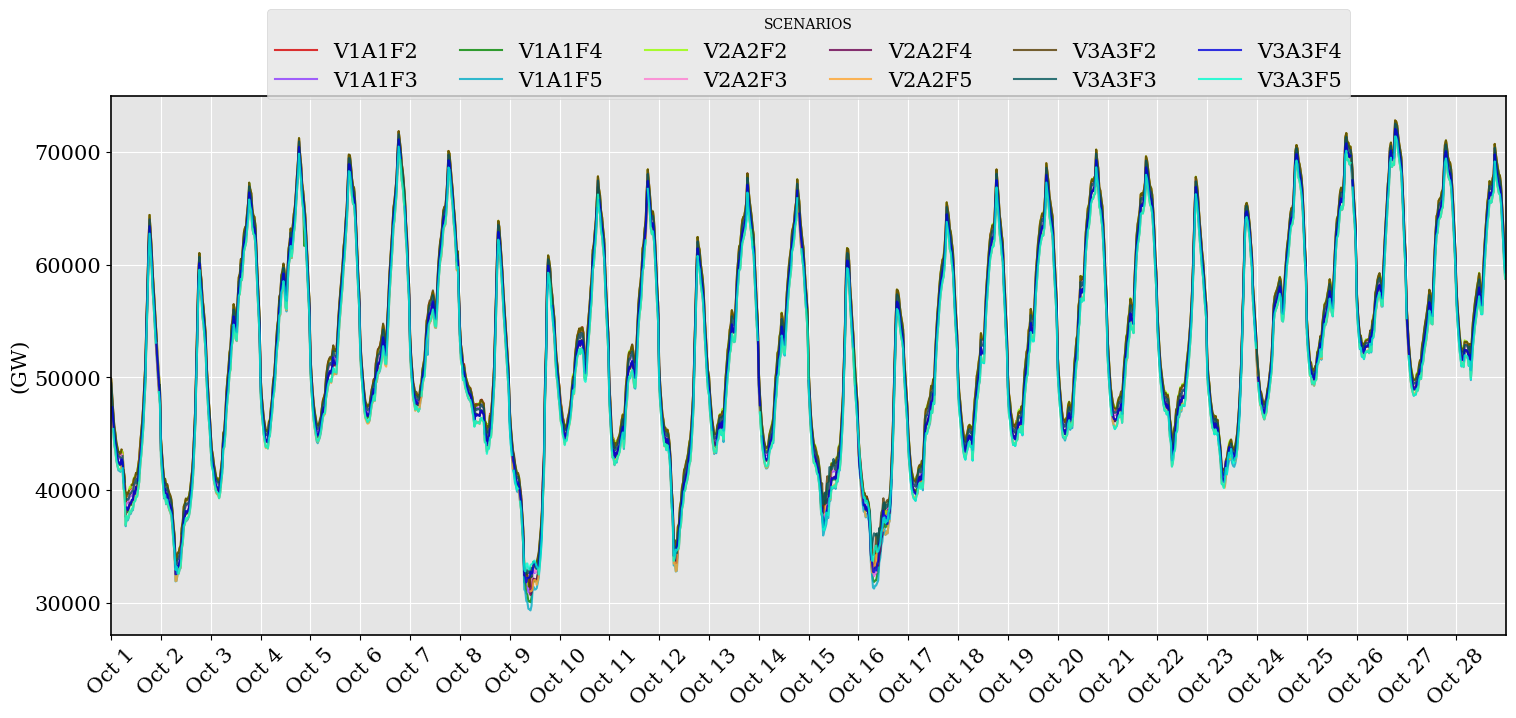

In [22]:
plot_perfil_pot(DF_complete_PO.reset_index(), columna='DL_MW', ylbl='(GW)', titulo= f'Perfil de Demanda Liquida', day=True)

In [23]:
namescenarios = {'V1A1': ['V1A1', (0.8392156862745098, 0.0, 0.0)],
 'V2A2': ['V2A2', (0.5490196078431373, 0.23137254901960785, 1.0)],
 'V3A3': ['V3A3', (0.00392156862745098, 0.5294117647058824, 0.0)],}
# =======================================Dataframe Mask========================================================
fechas = [dia for dia in range(1, 29)]
semihoras_dia = [(datetime(2022, 10, dia, 0, 0) + timedelta(minutes=30*i)).strftime('%d-%H-%M') for dia in fechas for i in range(48)]
df = pd.DataFrame({'Dia_Hora': semihoras_dia})
# Dividir la columna Dia_Hora en dos partes y asignarlas a nuevas columnas
df[['Dia', 'Hora']] = df['Dia_Hora'].str.split('-', n=1, expand=True)
df['Dia_Hora'] = df['Dia_Hora'].str.replace('-',', ', n=1)
df['Dia'] = df['Dia'].astype(int)

df_copias = [df] * len(namescenarios)
df_mask = pd.concat(df_copias, ignore_index=True)
df_mask['Dia'] = df_mask['Dia'].astype(int)
scenarios_column = [scenario  for scenario in namescenarios.keys() for _ in range(1344) ]
df_mask['Cenario'] = scenarios_column

In [24]:
# dfmvar1 = df_pot_mw_mvar_filt[df_pot_mw_mvar_filt['Cenario'].isin(['V1A1F2','V1A1F3', 'V1A1F4', 'V1A1F5'])].groupby(['Dia','Hora'])[['QG_MVAR']].mean()
# dfmvar1['Cenario'] = 'V1A1'
# dfmvar2 = df_pot_mw_mvar_filt[df_pot_mw_mvar_filt['Cenario'].isin(['V2A2F2','V2A2F3', 'V2A2F4', 'V2A2F5'])].groupby(['Dia','Hora'])[['QG_MVAR']].mean()
# dfmvar2['Cenario'] = 'V2A2'
# dfmvar3 = df_pot_mw_mvar_filt[df_pot_mw_mvar_filt['Cenario'].isin(['V3A3F2','V3A3F3', 'V3A3F4', 'V3A3F5'])].groupby(['Dia','Hora'])[['QG_MVAR']].mean()
# dfmvar3['Cenario'] = 'V3A3'
# dfmvarfinal = pd.concat([dfmvar1, dfmvar2, dfmvar3], axis=0)

In [25]:
# plot_perfil_pot(dfmvarfinal.reset_index(), columna='QG_MVAR', ylbl='(GVAR)', titulo= f'Perfil de MVAR media', day=True)

In [26]:
if Analise_Potencia == True:
    ## Para comparação das diferençãs no reativo gerado entre dois cenários
    # df_pot_mw_mvar_filt = filtarNC(DATA['pot_mw_mvar'],DATA['Index_PO'])
    # a = df_pot_mw_mvar_filt[df_pot_mw_mvar_filt['Cenario']=='V2A2F2 2026 HPPA'][['key','QG_MVAR']]
    # b = df_pot_mw_mvar_filt[df_pot_mw_mvar_filt['Cenario']=='V2A2F2 2026 UNICAMP'][['key','QG_MVAR']]
    # c = a.merge(b, on='key', how='inner')
    # c['delta'] = c['QG_MVAR_x']-c['QG_MVAR_y']
    # display(c.sort_values('delta').head(20))

    #Para obter a media da reserva MW
    df_data = filtarNC(DATA['pot_mw_mvar'], DATA['Index_PO'])
    # df_data = pd.concat(filtarNC(dfs['pot_mw_reserv']), axis=0)
    display('La media es:',df_data[df_data['Cenario'].isin(['V1A1F2 2026','V1A1F3 2026','V1A1F4 2026','V1A1F5 2026'])]['QG_MVAR'].mean())
    display('La media es:',df_data[df_data['Cenario'].isin(['V2A2F2 2026','V2A2F3 2026','V2A2F4 2026','V2A2F5 2026'])]['QG_MVAR'].mean())
    display('La media es:',df_data[df_data['Cenario'].isin(['V3A3F2 2026','V3A3F3 2026','V3A3F4 2026','V3A3F5 2026'])]['QG_MVAR'].mean())

In [27]:
# def distribution_plot_reg(df, columna, reg, xlbl, titulo):
    
#     plt.figure(figsize=(12, 6))
#     for df_ in df:
#         dff = df_[df_['REG'] == reg]
#         cenario = dff['Cenario'].iloc[0]
#         valuegw = dff[columna]/1000
#         sns.histplot(valuegw, kde=False, label=namescenarios[cenario][0], color=namescenarios[cenario][1], bins=50, multiple="stack",alpha=0.80, element='step',fill=True, line_kws = {
#         "linewidth": 2,  # Example: Make the line thicker
#         "linestyle": "--" # Example: Use a dashed line
#         })
#         plt.axvline(valuegw.mean(), color=namescenarios[cenario][1], linestyle='dashed', linewidth=2)
#         print(valuegw.mean())

#     plt.title(titulo, fontsize=18)
#     plt.xlabel(xlbl, fontsize=15)
#     plt.ylabel('frequência', fontsize=15)
#     plt.tick_params(axis='both', labelsize=15)
#     plt.legend(loc='best', fontsize = 15)
#     plt.grid()
#     plt.show()

# regiones = ['Norte', 'Nordeste', 'Sudeste-Centro-Oeste', 'Sul', 'AC-RO']
# if Analise_Potencia:
#     for reg in regiones:
#         df_pot_mw_mvar_reg = filtarNC(DATA['ger_reg'], DATA['Index_PO'])
#         plot_perfil_pot(df_pot_mw_mvar_reg.set_index('REG').loc[reg], columna='PG_MW', ylbl='MW', titulo= f'Perfil de Geração {reg}', day=True)


In [28]:
def plot_potencia_perfil(df_resultado, df_data, column, ylim = None, markers=True,):

    df = df_resultado.merge(df_data,on=['Dia','Hora', 'Cenario'], how='left')
    df[column] = df[column]/1000
    plt.figure(figsize=(20, 6))
    sns.lineplot(data=df, x='Dia_Hora', y=column, hue='Cenario', markers=markers, lw = 2)
    plt.xlabel('(Dia, Hora)', fontsize = 15)
    plt.ylabel('(GW)', fontsize = 18)
    plt.title(f'Perfil de Potencia de {column}', fontsize = 15)

    value = int(df['Dia_Hora'].unique().shape[0] / 28)
    selected_ticks = df[df['Cenario'] == df['Cenario'].unique()[0]].iloc[::value]['Dia_Hora']
    plt.xticks(selected_ticks, rotation=45, fontsize=15)
    plt.tick_params(axis='y', labelsize=18)
    plt.legend(title='Cenarios', fontsize = 15)
    if ylim != None:
        plt.ylim(ylim)
    plt.tight_layout()
    plt.show()
if Analise_Potencia:
    plot_potencia_perfil(df_mask, DF_complete_PO, 'DL_MW', markers=False)
    plot_potencia_perfil(df_mask, DF_complete_PO, 'PL_MW', markers=False)

# Tensão

In [29]:
def boxplot_voltage(df, clase, titulo, xlbl, ylbl, ylim=None, vert = False, size = (12,6)):
    # Apply matplotlib styles
    intense_palette = sns.color_palette("ch:start=.2,rot=-.3", n_colors=4)
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['mathtext.fontset'] = 'dejavuserif'
    plt.style.use("ggplot")

    # Create seaborn boxplot with customizations
    plt.figure(figsize= size)
    if vert:
        ax = sns.boxplot(data=df, x="MODV_PU", y=clase, hue='Clase', width=0.8, gap = 0.15, saturation = 0.75, linewidth=1.5, palette=intense_palette,flierprops={'markerfacecolor': 'gray', 'marker': 'o'},legend=True, showfliers = True)
    else:
        ax = sns.boxplot(data=df, x=clase, y="MODV_PU", hue='Clase', width=0.8,  gap = 0.15, saturation = 0.75, linewidth=1.5, palette=intense_palette,flierprops={'markerfacecolor': 'gray', 'marker': 'o'},legend=True, showfliers = True)

    # Customize axes spines
    border_color = 'black'
    linewidth = 1.2
    ax.spines['top'].set_color(border_color)
    ax.spines['bottom'].set_color(border_color)
    ax.spines['left'].set_color(border_color)
    ax.spines['right'].set_color(border_color)
    ax.spines['top'].set_linewidth(linewidth)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['left'].set_linewidth(linewidth)
    ax.spines['right'].set_linewidth(linewidth)

    # Customize the boxplot elements
    for cap in ax.artists:
        cap.set_edgecolor(border_color)
        cap.set_facecolor('white')

    for median in ax.lines:
        median.set_color('darkblue')
        median.set_linewidth(1.5)
    
    plt.ylabel(ylbl, fontsize=16, color ='black')
    plt.title('', fontsize=5)
    plt.xlabel(xlbl, fontsize=16, color ='black')
    plt.legend(fontsize = 15, loc='upper left')
    plt.tick_params(axis='both', labelsize=15, labelcolor='black')
    # plt.legend(title='Cenário', loc='best', fontsize=15)
    plt.tick_params(axis='x', colors='black',labelsize=15, rotation = 0)  # Set the color for the x-axis ticks
    plt.tick_params(axis='y', colors='black')  # Set the color for the y-axis ticks
    # Add horizontal lines
    if vert:
        plt.axvline(1.10, color='red', linestyle='--', alpha=0.9)
        plt.axvline(0.90, color='red', linestyle='--', alpha=0.9)
    else:
        plt.axhline(1.10, color='red', linestyle='--', alpha=0.9)
        plt.axhline(0.90, color='red', linestyle='--', alpha=0.9)
    # Set y-axis limits if specified
    if ylim is not None:
        plt.ylim(ylim)
    # Display plot
    plt.savefig(f"Plots/{titulo}.png")
    plt.show()

def boxplot_(df,Variable, clase, titulo, xlbl, ylbl, ylim = None, hue="Cenario", indice = True):

    intense_palette = sns.color_palette("ch:start=.2,rot=-.3", n_colors=4)
    # Apply matplotlib styles
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['mathtext.fontset'] = 'dejavuserif'
    plt.style.use("ggplot")
    if indice:
        indexmap = {
            'IndiceInf_s2_PQ': 'PQ Buses', 'IndiceInf_s2_PV': 'PV Buses', 'IndiceSup_s2_PQ': 'PQ Buses',
            'IndiceSup_s2_PV': 'PV Buses',
                    }
        df['variable']  = df['variable'].map(indexmap)
    # Create seaborn boxplot with customizations
    plt.figure(figsize=(18, 7))
    ax = sns.boxplot(data=df, x=clase, y=Variable, hue=hue, width=0.8, gap = 0.15, saturation = 0.75,  linewidth=1.5, palette=intense_palette,flierprops={'markerfacecolor': 'gray', 'marker': 'o'},showfliers=True)

    # Customize axes spines
    border_color = 'black'
    linewidth = 1.2
    ax.spines['top'].set_color(border_color)
    ax.spines['bottom'].set_color(border_color)
    ax.spines['left'].set_color(border_color)
    ax.spines['right'].set_color(border_color)
    ax.spines['top'].set_linewidth(linewidth)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['left'].set_linewidth(linewidth)
    ax.spines['right'].set_linewidth(linewidth)

    # Customize the boxplot elements
    for cap in ax.artists:
        cap.set_edgecolor(border_color)
        cap.set_facecolor('white')

    for median in ax.lines:
        median.set_color('darkblue')
        median.set_linewidth(1.5)
    
    # Add titles and labels
    plt.title('', fontsize=18)
    plt.xlabel(xlbl, fontsize=18, color ='black')
    plt.ylabel(ylbl, fontsize=18, color ='black')
    plt.tick_params(axis='both', labelsize=20)
    plt.tick_params(axis='both', labelsize=20, labelcolor='black')
    # plt.legend(title='Type of Bus', loc='best', fontsize=16)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=8, title='SCENARIOS', fontsize=16, title_fontsize=16, frameon=False)
    # plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Type of Bus', fontsize=13)
    plt.tick_params(axis='x', colors='black',labelsize=15, rotation = 0)  # Set the color for the x-axis ticks
    plt.tick_params(axis='y', colors='black')  # Set the color for the y-axis ticks
    
    # Set y-axis limits if specified
    if ylim is not None:
        plt.ylim(ylim)
    plt.savefig(f"Plots/{titulo}.svg")
    # Display plot
    plt.show()

def scatterplot_3(df, v1, v2, xlbl, ylbl, selectedindex, lbl_bar=None, v3=None, xlimites=None, ylimites=None, title=None, vline=False, hline=False, size=100, Chngelbl=False, sizelbl=13, rotation=0, line_plot=True):
    
    if Chngelbl:
        print()
    
    vpi_inf = r'$\mathrm{VPI}^\mathrm{l}$'
    vpi_sup = r'$\mathrm{VPI}^\mathrm{u}$'
    rpi_ind = r'$\mathrm{RPI}^\mathrm{ind}$'
    rpi_cap = r'$\mathrm{RPI}^\mathrm{cap}$'
    
    indexmap = {
        'IndiceInf_s1': vpi_inf, 'IndiceSup_s1': vpi_sup, 'RPI_ind': rpi_ind,
        'RPI_cap': rpi_cap, 'IndiceInf' : vpi_inf, 'IndiceSup' : vpi_sup, 'ReservaIND':rpi_ind, 'ReservaCAP':rpi_cap,
        'ReservaINDshunt':rpi_ind, 'ReservaCAPshunt':rpi_cap
    }
    df['variable'] = df['variable'].map(indexmap)
    
    cmap = plt.cm.get_cmap("rainbow")
    plt.figure(figsize=(10, 6))
    
    # Define custom markers and colors
    markers = {vpi_inf: 'o', vpi_sup: 'o', rpi_ind: '^', rpi_cap: '^'}
    colors = {vpi_inf: 'blue', vpi_sup: 'green', rpi_ind: 'orange', rpi_cap: 'purple'}
    
    if v3 is None:
        scatter = sns.scatterplot(data=df, x=v1, y=v2, s=60, legend=None)
    else:
        scatter = sns.scatterplot(data=df, x=v1, y=v2, hue=v3, style=v3, s=size, palette=colors, markers=markers, legend=True)
    
    # If line_plot is True, add a line plot
    if line_plot:
        # Sort the data by v1
        df_sorted = df
        if v3 is None:
            plt.plot(df_sorted[v1], df_sorted[v2], color='black', linestyle='-', linewidth=1)
        else:
            # If hue is used, plot a line for each group
            for key, grp in df_sorted.groupby(v3):
                if key == indexmap[selectedindex]:
                    plt.plot(grp[v1], grp[v2], linestyle='-', linewidth=2, color=colors.get(key, 'black'))
                else:
                    plt.plot(grp[v1], grp[v2], linestyle='--', linewidth=1.2, color=colors.get(key, 'black'))
    
    # Set legend with custom markers and colors
    handles, labels = scatter.get_legend_handles_labels()
    new_labels = []
    new_handles = []
    for handle, label in zip(handles, labels):
        if label in markers:
            new_handles.append(plt.Line2D([], [], marker=markers[label], color=colors[label], linestyle='None', markersize=10))
            new_labels.append(label)
    
    border_color = 'black'
    linewidth = 1.2
    scatter.spines['top'].set_color(border_color)
    scatter.spines['bottom'].set_color(border_color)
    scatter.spines['left'].set_color(border_color)
    scatter.spines['right'].set_color(border_color)
    scatter.spines['top'].set_linewidth(linewidth)
    scatter.spines['bottom'].set_linewidth(linewidth)
    scatter.spines['left'].set_linewidth(linewidth)
    scatter.spines['right'].set_linewidth(linewidth)

    plt.legend(new_handles, new_labels, loc='upper left', bbox_to_anchor=(1, 1), title='Indices', fontsize=13)
    plt.title(title, fontsize=15)
    plt.xlabel(xlbl, fontsize=17, color='black')
    plt.ylabel(ylbl, fontsize=17, color='black')
    if hline:
        plt.axhline(1, color='red', linestyle='--', alpha=0.9)
    if vline:
        plt.axvline(1, color='red', linestyle='--', alpha=0.9)
        
    # Adjust x-axis tick labels position
    ax = plt.gca()
    for tick in ax.get_xticklabels():
        tick.set_horizontalalignment('right')
    
    plt.tick_params(axis='both', labelsize=15, labelcolor='black')
    plt.tick_params(axis='x', colors='black', labelsize=sizelbl, rotation=rotation)
    plt.tick_params(axis='y', colors='black')
    
    if xlimites is not None:
        plt.xlim(xlimites)
    if ylimites is not None:
        plt.ylim(ylimites)
        
    plt.tight_layout()
    plt.savefig(f"Plots/{title}.svg")
    plt.show()

def lineplotIndice(df, v1, v2, xlbl, ylbl, selectedindex, lbl_bar=None, v3=None, xlimites=None, ylimites=[-0.1, 1.2], title=None, vline=False, hline=False, sizelbl=13, rotation=0, line_plot=True, type = 'PV'):

    # vpi_inf_pv = r'$\mathrm{V}_{pu}^\mathrm{l}$'
    # vpi_sup_pv = r'$\mathrm{V}_{pu}^\mathrm{u}$'
    # vpi_inf_pq = r'$\mathrm{V}_{pu}^\mathrm{l}$'
    # vpi_sup_pq = r'$\mathrm{V}_{pu}^\mathrm{u}$'

    vpu = r'$\mathrm{V}_{pu}$'
    rpi_ind_pv = r'$\mathrm{Q}_{n}^\mathrm{abs}$'
    rpi_cap_pv = r'$\mathrm{Q}_{n}^\mathrm{inj}$'
    rpi_ind_pq = r'$\mathrm{Q}_{n}^\mathrm{abs}$'
    rpi_cap_pq = r'$\mathrm{Q}_{n}^\mathrm{inj}$'        
    
    indexmap = {
         'ReservaIND':rpi_ind_pv, 'ReservaCAP':rpi_cap_pv,'ReservaINDshunt':rpi_ind_pq, 'ReservaCAPshunt':rpi_cap_pq, 'MODV_PU_PV':vpu, 'MODV_PU_PQ':vpu
    }

    df['variable'] = df['variable'].map(indexmap)
    df = df.dropna()
    df = df.groupby(v1).filter(lambda x: x[v2].sum() != 0).reset_index(drop=True)

    cmap = plt.cm.get_cmap("rainbow")

    # Define custom markers and colors
    markers = {vpu: 'o', rpi_ind_pv: '^', rpi_cap_pv: '^', rpi_ind_pq: '^', rpi_cap_pq: '^'}
    colors = { rpi_ind_pv: 'orange', rpi_cap_pv: 'purple', rpi_ind_pq: 'brown', rpi_cap_pq: 'forestgreen',vpu: 'blue' }

    fig, ax1 = plt.subplots(figsize=(14, 9))
    
    if v3 is None:
        sns.lineplot(data=df, x=v1, y=v2, legend=None, ax=ax1)
    else:
        sns.lineplot(data=df, x=v1, y=v2, hue=v3, style=v3, palette=colors, markers=markers, legend=True, errorbar=('pi'), ax=ax1, alpha = 1,  markerfacecolor='none', markeredgecolor='auto',markeredgewidth=2)

    for line in ax1.get_lines():
        line.set_markersize(12)  # Set the marker size to 10 (or any size you want)

    # Set legend with custom markers and colors
    handles, labels = ax1.get_legend_handles_labels()
    # Create custom legend handles with desired marker properties
    new_handles = []
    for handle in handles:
        marker = handle.get_marker()
        color = handle.get_color()
        new_handle = plt.Line2D([], [], linestyle='None', marker=marker, markersize=12,
                                markerfacecolor='none', markeredgecolor=color, markeredgewidth=2)
        new_handles.append(new_handle)

    # Update the legend with the new handles
    ax1.legend(new_handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4, title='Variável', fontsize=18, title_fontsize=16, frameon=False)

    border_color = 'black'
    linewidth = 1.2
    ax1.spines['top'].set_color(border_color)
    ax1.spines['bottom'].set_color(border_color)
    ax1.spines['left'].set_color(border_color)
    ax1.spines['right'].set_color(border_color)
    ax1.spines['top'].set_linewidth(linewidth)
    ax1.spines['bottom'].set_linewidth(linewidth)
    ax1.spines['left'].set_linewidth(linewidth)
    ax1.spines['right'].set_linewidth(linewidth)

    ax1.set_title('', fontsize=15)
    ax1.set_xlabel(xlbl, fontsize=17, color='black')
    ax1.set_ylabel(ylbl, fontsize=17, color='black')
    if hline:
        if type == 'PV':
            ax1.axhline(0.95, color='black', linestyle='--', alpha=0.8)
            ax1.axhline(1.05, color='black', linestyle='--', alpha=0.8)
        else:
            # ax1.axhline(1, color='black', linestyle='--', alpha=0.8)
            # ax1.axhline(1.10, color='black', linestyle='--', alpha=0.8)
            ax1.axhline(0.95, color='black', linestyle='--', alpha=0.8)
            ax1.axhline(1.05, color='black', linestyle='--', alpha=0.8)
            # ax1.axhline(0.9, color='black', linestyle='--', alpha=0.8)
            # ax1.axhline(1.04, color='black', linestyle='--', alpha=0.8)
    if vline:
        ax1.axvline(1, color='black', linestyle='--', alpha=0.8)
        
    # Adjust x-axis tick labels position
    for tick in ax1.get_xticklabels():
        tick.set_horizontalalignment('right')
    
    ax1.tick_params(axis='both', labelsize=15, labelcolor='black')
    ax1.tick_params(axis='x', colors='black', labelsize=sizelbl, rotation=rotation)
    ax1.tick_params(axis='y', colors='black')
    
    if xlimites is not None:
        ax1.set_xlim(xlimites)
    if ylimites is not None:
        ax1.set_ylim(ylimites)

    # ax2 = ax1.twinx()  # Create a secondary y-axis

    # # x_labels = ax1.get_xticks()
    # x_ticklabels = ax1.get_xticklabels()
    # x_ticklabels = [label.get_text() for label in x_ticklabels]
    # for index  in selectedindex:
    #     bar_data = df[df['variable'] == indexmap[index]].groupby(v1)[v2].mean()
    #     bar_data = bar_data.reindex(x_ticklabels, fill_value=0)
    #     ax1.bar(x_ticklabels, bar_data.values, color=colors[indexmap[index]], alpha=0.3, width=0.5)

    plt.tight_layout()
    plt.savefig(f"Plots/{title}.svg")
    plt.show()

def plot_line(df_data, column, xlbl, ylbl, title, pathsave=None, clase=None, xlimites=None, ylimites=None, order=False, byClass=False, month=False):
    intense_palette = sns.color_palette(cc.glasbey, n_colors=20)
    fig, axs = plt.subplots(1, 1, figsize=(18, 8), sharex=False)

    if byClass:
        for idx, clase in enumerate(df_data.index.get_level_values(clase).unique().values):
            if order:
                data = df_data.loc[:, :, clase].sort_values(column, ascending=False)
                # Handle NaN by filling with placeholder or skipping NaN entries
                vbasekv_value = data['Nome da Area'].values[0]  # Replace NaN with 'N/A'
                axs.plot(data[column].values, color=intense_palette[idx], label=f"{clase} ({vbasekv_value})", lw=2.5, linestyle='-', alpha=1)
                
                num = data.shape[0]
                data_points_xaxis = 10
                num_days = num * data_points_xaxis / 100
                axs.set_xticks([round(i * num_days) for i in range(data_points_xaxis + 1)])
                axs.set_xticklabels([f'{i * 10}' for i in range(data_points_xaxis + 1)], fontsize=12, rotation=0, ha='center')
            else:
                data = df_data.loc[:, :, clase]
                vbasekv_value = data['Nome da Area'].values[0]  # Replace NaN with 'N/A'
                axs.plot(data['key'], data[column], color=intense_palette[idx], label=f"{clase} ({vbasekv_value})", lw=2.5, linestyle='-', alpha=1)
                axs.xaxis.set_major_locator(plt.MaxNLocator(28))
            axs.legend(loc='upper right', fontsize=18)
    else:
        if order:
            data = df_data.sort_values(column, ascending=False)
            vbasekv_value = data['VBASEKV'].fillna('N/A').values[0]  # Replace NaN with 'N/A'
            axs.plot(data[column].values, color=intense_palette[0], label=f"Data ({vbasekv_value})", lw=2.5, linestyle='-', alpha=1)
            
            num = data.shape[0]
            data_points_xaxis = 10
            num_days = num * data_points_xaxis / 100
            axs.set_xticks([round(i * num_days) for i in range(data_points_xaxis + 1)])
            axs.set_xticklabels([f'{i * 10}' for i in range(data_points_xaxis + 1)], fontsize=12, rotation=0, ha='center')
        else:
            axs.plot(df_data['key'], df_data[column], color=intense_palette[0], lw=2.5, linestyle='-', alpha=1)
            for i, txt in enumerate(df_data["VBASEKV"].values):
                axs.annotate(f'{txt}', (df_data['key'].values[i], df_data[column].values[i]), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)
            axs.xaxis.set_major_locator(plt.MaxNLocator(28))

    border_color = 'black'
    linewidth = 1.2
    axs.spines['top'].set_color(border_color)
    axs.spines['bottom'].set_color(border_color)
    axs.spines['left'].set_color(border_color)
    axs.spines['right'].set_color(border_color)
    axs.spines['top'].set_linewidth(linewidth)
    axs.spines['bottom'].set_linewidth(linewidth)
    axs.spines['left'].set_linewidth(linewidth)
    axs.spines['right'].set_linewidth(linewidth)

    axs.tick_params(axis='y', labelsize=24)
    axs.tick_params(axis='x', labelsize=25, rotation=45)
    axs.set_xlabel(xlbl, fontsize=24, color ='black')
    axs.set_ylabel(ylbl, fontsize=22, color ='black')
    axs.set_title(title, fontsize=22, color ='black')
    axs.tick_params(axis='x', colors='black',labelsize=24, rotation = 0)  # Set the color for the x-axis ticks
    axs.tick_params(axis='y', colors='black')  # Set the color for the y-axis ticks

    if month:
        days = ['Oct {}'.format(i + 1) for i in range(28)]
        plt.xticks(ticks=[i * 48 for i in range(28)], labels=days, rotation=45)
        plt.xlabel('', fontsize=10)

    if xlimites is not None:
        axs.set_xlim(xlimites)
    if ylimites is not None:
        axs.set_ylim(ylimites)

    axs.grid(True, linestyle='-', linewidth=1.2, alpha=0.4)
    plt.tight_layout()
    plt.savefig(f"Plots/{title}.svg")
    plt.show()

In [30]:
# Define the file path
file_path = 'areainfo_anarede.txt'

# Read the file, skipping the first line
with open(file_path, 'r', encoding='utf-8') as file:
    # Skip the first line
    file.readline()
    # Read the second line for column names, but we will define custom names
    column_names = ["ARE", "Xchg", "Estado", "Nome da Area"]
    # Read the remaining lines for data
    data = [line.strip() for line in file]

# Clean and split the data into columns, focusing on four columns
cleaned_data = []
for line in data[1:]:
    # Remove parentheses and extra spaces, split into exactly four columns
    columns = line.replace('(', '').replace(')', '').split(maxsplit=3)
    # Ensure we have exactly four columns, filling with an empty string if necessary
    if len(columns) == 3:
        columns.append('')  # Add empty string for missing "Nome da Area"
    cleaned_data.append(columns[:4])  # Limit to four columns

# Create a DataFrame with the revised column names
df_area = pd.DataFrame(cleaned_data, columns=column_names)
# Remove the leading '- ' from the "Nome da Area" column
df_area['Nome da Area'] = df_area['Nome da Area'].str.lstrip('- ')
df_area['ARE'] = df_area['ARE'].astype('Int32')

In [31]:
GB = 'ARE'

def indice_reativo_optimized(df, tg):
    group_cols = ['key', 'Dia', 'Hora', 'Cenario', 'REG', GB]
    
    if tg == 'Gen_Type':
        agg_dict = {
            'Qg_ind': 'sum',
            'Qmin': 'sum',
            'Qg_cap': 'sum',
            'Qmax': 'sum'
        }
        grouped = df.groupby(group_cols).agg(agg_dict).reset_index()
        
        grouped['RPI_ind'] = np.where(
            grouped['Qmin'] != 0,
            grouped['Qg_ind'] / grouped['Qmin'],
            0
        )
        grouped['RPI_cap'] = np.where(
            grouped['Qmax'] != 0,
            grouped['Qg_cap'] / grouped['Qmax'],
            0
        )
    else:
        agg_dict = {
            'Qg_ind_sht': 'sum',
            'SHUNT_INST_IND': 'sum',
            'Qg_cap_sht': 'sum',
            'SHUNT_INST_CAP': 'sum'
        }
        grouped = df.groupby(group_cols).agg(agg_dict).reset_index()
        
        grouped['RPI_ind'] = np.where(
            grouped['SHUNT_INST_IND'] != 0,
            grouped['Qg_ind_sht'] / grouped['SHUNT_INST_IND'],
            0
        )
        grouped['RPI_cap'] = np.where(
            grouped['SHUNT_INST_CAP'] != 0,
            grouped['Qg_cap_sht'] / grouped['SHUNT_INST_CAP'],
            0
        )
    
    # Select the relevant columns to return
    df1 = grouped[group_cols + ['RPI_ind', 'RPI_cap']]
    return df1

if Analise_INDICE:
    # Optimize the computation using vectorized operations
    # DATA['ger']['Qg_ind'] = DATA['ger']['QG_MVAR'].clip(upper=0)
    # DATA['ger']['Qg_cap'] = DATA['ger']['QG_MVAR'].clip(lower=0)
    
    # DATA['ger']['Qmin'] = DATA['ger']['Qmin'].clip(upper=0)
    # DATA['ger']['Qmax'] = DATA['ger']['Qmax'].clip(lower=0)

    condition1 = DATA['ger']['Ger_Active_Units'] > 0
    condition2 = DATA['nt']['ST'] > 0
    
    DATA['ger'].loc[condition1,'Qg_ind'] = np.where(DATA['ger'].loc[condition1,'QG_MVAR'] < 0,  DATA['ger'].loc[condition1,'QG_MVAR'] , 0)
    DATA['ger'].loc[condition1,'Qg_cap'] = np.where(DATA['ger'].loc[condition1,'QG_MVAR'] > 0,  DATA['ger'].loc[condition1,'QG_MVAR'] , 0)

    DATA['ger'].loc[condition1,'Qmin'] = np.where(DATA['ger'].loc[condition1,'Qmin'] < 0,  DATA['ger'].loc[condition1,'Qmin'] , 0)
    DATA['ger'].loc[condition1,'Qmax'] = np.where(DATA['ger'].loc[condition1,'Qmax'] > 0,  DATA['ger'].loc[condition1,'Qmax'] , 0)

    DATA['ger'].loc[condition1,'ReservaIND'] = np.where(DATA['ger'].loc[condition1,'QG_MVAR'] < 0,  np.round(np.abs(DATA['ger'].loc[condition1,'QG_MVAR']/DATA['ger'].loc[condition1,'Qmin']),4), 0)
    DATA['ger'].loc[condition1,'ReservaCAP'] = np.where(DATA['ger'].loc[condition1,'QG_MVAR'] > 0,  np.round(np.abs(DATA['ger'].loc[condition1,'QG_MVAR']/DATA['ger'].loc[condition1,'Qmax']),4), 0)
    
    DATA['nt'].loc[condition2,'Qg_ind_sht'] = np.where(DATA['nt'].loc[condition2,'B0_MVAR'] < 0,  DATA['nt'].loc[condition2,'B0_MVAR'] , 0)
    DATA['nt'].loc[condition2,'Qg_cap_sht'] = np.where(DATA['nt'].loc[condition2,'B0_MVAR'] > 0,  DATA['nt'].loc[condition2,'B0_MVAR'] , 0)
    
    df_RPI_PV = indice_reativo_optimized(DATA['ger'].loc[condition1], 'Gen_Type')
    df_RPI_PQ = indice_reativo_optimized(DATA['nt'].loc[condition2], 'VBASEKV')

In [32]:
GB = 'ARE'
n = 2  # Global variable for norm order

def concatenatedfs(data, numNB):
    df_merged = pd.merge(data, numNB, on=['key', 'Dia', 'Hora', 'Cenario', 'REG', GB], how='left')
    df_merged.fillna(0, inplace=True)
    return df_merged

def computeDPI():
    df_PQ_area, df_PV_area = None, None

    for key in ['PQ Buses', 'PV Buses']:
        df = DATA['nt'].copy() if key == 'PQ Buses' else DATA['ger'].copy()

        group_cols1 = ['key', 'Dia', 'Hora', 'Cenario', 'REG', GB]
        group_cols2 = ['key', 'Dia', 'Hora', 'Cenario', 'REG']

        # Compute counts and sums more efficiently
        num_NB = df.groupby(group_cols1)['BUS_ID'].count().reset_index(name='num_NB')
        num_NB_nonzeros_inf = df[df['IndiceInf'] > 0].groupby(group_cols1)['BUS_ID'].count().reset_index(name='num_NB_inf')
        num_NB_nonzeros_sup = df[df['IndiceSup'] > 0].groupby(group_cols1)['BUS_ID'].count().reset_index(name='num_NB_sup')
        num_NR = df.groupby(group_cols2)['BUS_ID'].count().reset_index(name='num_NR')

        df_merged_NB = num_NB.merge(num_NB_nonzeros_inf, on=group_cols1, how='outer')
        df_merged_NB = df_merged_NB.merge(num_NB_nonzeros_sup, on=group_cols1, how='outer')
        df_merged = df_merged_NB.merge(num_NR, on=group_cols2, how='left')

        # Fill NaN values with zeros
        df_merged.fillna(0, inplace=True)

        if key == 'PQ Buses':
            # Compute IndiceInf_s1 and IndiceSup_s1 using vectorized operations
            df['IndiceInf_powered'] = np.abs(df['IndiceInf']) ** (2 * n)
            df['IndiceSup_powered'] = np.abs(df['IndiceSup']) ** (2 * n)

            df_PQ = df.groupby(group_cols1).agg(
                IndiceInf_powered_sum=('IndiceInf_powered', 'sum'),
                IndiceSup_powered_sum=('IndiceSup_powered', 'sum'),
                VBASEKV=('VBASEKV', 'first'),
            ).reset_index()

            df_PQ['IndiceInf_s1'] = df_PQ['IndiceInf_powered_sum'] ** (1 / (2 * n))
            df_PQ['IndiceSup_s1'] = df_PQ['IndiceSup_powered_sum'] ** (1 / (2 * n))

            df_PQ = concatenatedfs(df_PQ, df_merged)
            df_PQ = df_PQ.merge(df_RPI_PQ, on=group_cols1, how='left')

            # Compute s values and their powered sums
            df_PQ['value_Inf'] = df_PQ['num_NB_inf'] / df_PQ['num_NR'].replace(0, np.nan)
            df_PQ['value_Sup'] = df_PQ['num_NB_sup'] / df_PQ['num_NR'].replace(0, np.nan)

            # df_PQ['s_Inf'] = df_PQ['value_Inf'].fillna(0) * (df_PQ['IndiceInf_s1'] + df_PQ['RPI_cap'])
            # df_PQ['s_Sup'] = df_PQ['value_Sup'].fillna(0) * (df_PQ['IndiceSup_s1'] + df_PQ['RPI_ind'])

            # df_PQ['s_Inf_powered'] = df_PQ['s_Inf'] ** (2 * n)
            # df_PQ['s_Sup_powered'] = df_PQ['s_Sup'] ** (2 * n)

            # # Group by and compute IndiceInf_s2 and IndiceSup_s2
            # df_PQ_area = df_PQ.groupby(group_cols2).agg(
            #     IndiceInf_s2_powered_sum=('s_Inf_powered', 'sum'),
            #     IndiceSup_s2_powered_sum=('s_Sup_powered', 'sum'),
            # ).reset_index()

            # df_PQ_area['IndiceInf_s2'] = df_PQ_area['IndiceInf_s2_powered_sum'] ** (1 / (2 * n))
            # df_PQ_area['IndiceSup_s2'] = df_PQ_area['IndiceSup_s2_powered_sum'] ** (1 / (2 * n))

# ====================================================

            df_PQ['s_Inf_powered'] = (df_PQ['value_Inf'].fillna(0) * (df_PQ['IndiceInf_s1']))** (2 * n)
            df_PQ['s_Sup_powered'] = (df_PQ['value_Sup'].fillna(0) * (df_PQ['IndiceSup_s1']))** (2 * n)
            df_PQ['s_Ind_powered'] = (df_PQ['value_Sup'].fillna(0) * (df_PQ['RPI_ind']))** (2 * n)
            df_PQ['s_Cap_powered'] = (df_PQ['value_Inf'].fillna(0) * (df_PQ['RPI_cap']))** (2 * n)

            # df_PQ['s_Inf_powered'] = (df_PQ['IndiceInf_s1'])** (2 * n)
            # df_PQ['s_Sup_powered'] = (df_PQ['IndiceSup_s1'])** (2 * n)
            # df_PQ['s_Ind_powered'] = (df_PQ['RPI_ind'])** (2 * n)
            # df_PQ['s_Cap_powered'] = (df_PQ['RPI_cap'])** (2 * n)

            # Group by and compute IndiceInf_s2 and IndiceSup_s2
            df_PQ_area = df_PQ.groupby(group_cols2).agg(
                IndiceInf_s2_powered_sum=('s_Inf_powered', 'sum'),
                IndiceSup_s2_powered_sum=('s_Sup_powered', 'sum'),
                IndiceInd_s2_powered_sum=('s_Ind_powered', 'sum'),
                IndiceCap_s2_powered_sum=('s_Cap_powered', 'sum'),
            ).reset_index()

            df_PQ_area['IndiceInf_s2'] = (df_PQ_area['IndiceInf_s2_powered_sum'] +  df_PQ_area['IndiceCap_s2_powered_sum'])** (1 / (2 * n))
            df_PQ_area['IndiceSup_s2'] = (df_PQ_area['IndiceSup_s2_powered_sum'] +  df_PQ_area['IndiceInd_s2_powered_sum']) ** (1 / (2 * n))


        elif key == 'PV Buses':
            # Compute IndiceInf_s1 and IndiceSup_s1 using vectorized operations
            df['IndiceInf_powered'] = np.abs(df['IndiceInf']) ** (2 * n)
            df['IndiceSup_powered'] = np.abs(df['IndiceSup']) ** (2 * n)

            df_PV = df.groupby(group_cols1).agg(
                IndiceInf_powered_sum=('IndiceInf_powered', 'sum'),
                IndiceSup_powered_sum=('IndiceSup_powered', 'sum'),
            ).reset_index()

            df_PV['IndiceInf_s1'] = df_PV['IndiceInf_powered_sum'] ** (1 / (2 * n))
            df_PV['IndiceSup_s1'] = df_PV['IndiceSup_powered_sum'] ** (1 / (2 * n))

            df_PV = concatenatedfs(df_PV, df_merged)
            df_PV = df_PV.merge(df_RPI_PV, on=group_cols1, how='left')

            # Compute s values and their powered sums
            df_PV['value_Inf'] = df_PV['num_NB_inf'] / df_PV['num_NR'].replace(0, np.nan)
            df_PV['value_Sup'] = df_PV['num_NB_sup'] / df_PV['num_NR'].replace(0, np.nan)

            # df_PV['s_Inf'] = df_PV['value_Inf'].fillna(0) * (df_PV['IndiceInf_s1'] + df_PV['RPI_cap'])
            # df_PV['s_Sup'] = df_PV['value_Sup'].fillna(0) * (df_PV['IndiceSup_s1'] + df_PV['RPI_ind'])

            # df_PV['s_Inf_powered'] = df_PV['s_Inf'] ** (2 * n)
            # df_PV['s_Sup_powered'] = df_PV['s_Sup'] ** (2 * n)

            # # Group by and compute IndiceInf_s2 and IndiceSup_s2
            # df_PV_area = df_PV.groupby(group_cols2).agg(
            #     IndiceInf_s2_powered_sum=('s_Inf_powered', 'sum'),
            #     IndiceSup_s2_powered_sum=('s_Sup_powered', 'sum'),
            # ).reset_index()

            # df_PV_area['IndiceInf_s2'] = df_PV_area['IndiceInf_s2_powered_sum'] ** (1 / (2 * n))
            # df_PV_area['IndiceSup_s2'] = df_PV_area['IndiceSup_s2_powered_sum'] ** (1 / (2 * n))

# ====================================================

            df_PV['s_Inf_powered'] = (df_PV['value_Inf'].fillna(0) * (df_PV['IndiceInf_s1']))** (2 * n)
            df_PV['s_Sup_powered'] = (df_PV['value_Sup'].fillna(0) * (df_PV['IndiceSup_s1']))** (2 * n)
            df_PV['s_Ind_powered'] = (df_PV['value_Sup'].fillna(0) * (df_PV['RPI_ind']))** (2 * n)
            df_PV['s_Cap_powered'] = (df_PV['value_Inf'].fillna(0) * (df_PV['RPI_cap']))** (2 * n)

            # df_PV['s_Inf_powered'] = (df_PV['IndiceInf_s1'])** (2 * n)
            # df_PV['s_Sup_powered'] = (df_PV['IndiceSup_s1'])** (2 * n)
            # df_PV['s_Ind_powered'] = (df_PV['RPI_ind'])** (2 * n)
            # df_PV['s_Cap_powered'] = (df_PV['RPI_cap'])** (2 * n)

            # Group by and compute IndiceInf_s2 and IndiceSup_s2
            df_PV_area = df_PV.groupby(group_cols2).agg(
                IndiceInf_s2_powered_sum=('s_Inf_powered', 'sum'),
                IndiceSup_s2_powered_sum=('s_Sup_powered', 'sum'),
                IndiceInd_s2_powered_sum=('s_Ind_powered', 'sum'),
                IndiceCap_s2_powered_sum=('s_Cap_powered', 'sum'),
            ).reset_index()

            df_PV_area['IndiceInf_s2'] = (df_PV_area['IndiceInf_s2_powered_sum'] +  df_PV_area['IndiceCap_s2_powered_sum'])** (1 / (2 * n))
            df_PV_area['IndiceSup_s2'] = (df_PV_area['IndiceSup_s2_powered_sum'] +  df_PV_area['IndiceInd_s2_powered_sum']) ** (1 / (2 * n))

    # Concatenate and compute final indices
    df_Index_s3 = pd.concat([df_PV_area, df_PQ_area], axis=0, ignore_index=True)

    # Compute IndiceInf_s3 and IndiceSup_s3 using vectorized operations
    # df_Index_s3['IndiceInf_s2_powered'] = df_Index_s3['IndiceInf_s2'] ** (2 * n)
    # df_Index_s3['IndiceSup_s2_powered'] = df_Index_s3['IndiceSup_s2'] ** (2 * n)
    
    df_Index_s3['IndiceInf_s2_powered'] = df_PV_area['IndiceInf_s2_powered_sum'] + df_PV_area['IndiceCap_s2_powered_sum'] + df_PQ_area['IndiceInf_s2_powered_sum'] + df_PQ_area['IndiceCap_s2_powered_sum'] 
    df_Index_s3['IndiceSup_s2_powered'] = df_PV_area['IndiceSup_s2_powered_sum'] + df_PV_area['IndiceInd_s2_powered_sum'] + df_PQ_area['IndiceSup_s2_powered_sum'] + df_PQ_area['IndiceInd_s2_powered_sum'] 

    df_Index_DPI_s3 = df_Index_s3.groupby(['key', 'Dia', 'Hora', 'Cenario']).agg(
        IndiceInf_s3_powered_sum=('IndiceInf_s2_powered', 'sum'),
        IndiceSup_s3_powered_sum=('IndiceSup_s2_powered', 'sum'),
    ).reset_index()

    df_Index_DPI_s3['IndiceInf_s3'] = df_Index_DPI_s3['IndiceInf_s3_powered_sum'] ** (1 / (2 * n))
    df_Index_DPI_s3['IndiceSup_s3'] = df_Index_DPI_s3['IndiceSup_s3_powered_sum'] ** (1 / (2 * n))

    return df_PQ_area, df_PV_area, df_PV, df_PQ, df_Index_DPI_s3

if Analise_INDICE:
    df_PQ_area, df_PV_area, df_PV, df_PQ, df_Index_DPI_s3 = computeDPI()

    # Prepare final DataFrames
    df_PV_area.rename(columns={'IndiceInf_s2': 'IndiceInf_s2_PV', 'IndiceSup_s2': 'IndiceSup_s2_PV'}, inplace=True)
    df_PQ_area.rename(columns={'IndiceInf_s2': 'IndiceInf_s2_PQ', 'IndiceSup_s2': 'IndiceSup_s2_PQ'}, inplace=True)

    df_Index_DPI_s2 = df_PV_area.merge(df_PQ_area, on=['key', 'Dia', 'Hora', 'Cenario', 'REG'], how='left')
    df_Index_DPI_s2.set_index(['key', 'Dia', 'Hora', 'Cenario'], inplace=True)
    df_Index_DPI_s3.set_index(['key', 'Dia', 'Hora', 'Cenario'], inplace=True)


In [33]:
del DATA['ger']
del DATA['nt']

## Analise Indice

### Filtragem cluster

In [34]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

def reduce_dimensionality(data: pd.DataFrame, method: str = 'tsne', perplexity: float = 30, n_components: int = 2):
    """
    Reduce dimensionality of the data using TSNE or PCA.
    
    Parameters:
        data (pd.DataFrame): DataFrame with features.
        method (str): Dimensionality reduction method ('tsne' or 'pca').
        perplexity (float): Perplexity parameter for t-SNE (only relevant if method='tsne').
        n_components (int): Number of dimensions to reduce to (default is 2 for visualization).
    
    Returns:
        np.ndarray: Transformed 2D data for visualization.
    """
    if data.shape[1]>2:
    
        if method == 'tsne':
            tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=42)
            return tsne.fit_transform(data)
        elif method == 'pca':
            pca = PCA(n_components=n_components)
            return pca.fit_transform(data)
        else:
            raise ValueError("Method must be either 'tsne' or 'pca'.")
    else:
        return data.values
    
def detect_outliers_dbscan(data: pd.DataFrame, dbscan_eps: float = 0.05, dbscan_min_samples: int = 10):
    """
    Perform DBSCAN-based outlier detection.
    
    Parameters:
        data (pd.DataFrame): DataFrame with features (each column is a feature).
        dbscan_eps (float): DBSCAN epsilon (maximum distance between points for clustering).
        dbscan_min_samples (int): DBSCAN min_samples (minimum number of points to form a cluster).
    
    Returns:
        pd.Series: Boolean series where True indicates an outlier, False indicates inlier.
    """
    dbscan = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples)
    dbscan_labels = dbscan.fit_predict(data)
    return (dbscan_labels == -1)  # Outliers are labeled as -1

def detect_outliers_knn(data: pd.DataFrame, knn_neighbors: int = 5, contamination: float = 0.05):
    """
    Perform KNN-based outlier detection.
    
    Parameters:
        data (pd.DataFrame): DataFrame with features (each column is a feature).
        knn_neighbors (int): Number of neighbors for KNN.
        contamination (float): Proportion of points to be considered outliers.
    
    Returns:
        pd.Series: Boolean series where True indicates an outlier, False indicates inlier.
    """
    knn = NearestNeighbors(n_neighbors=knn_neighbors)
    knn.fit(data)
    distances, _ = knn.kneighbors(data)
    mean_distances = np.mean(distances, axis=1)
    
    # Set threshold based on contamination level
    threshold = np.percentile(mean_distances, 100 * (1 - contamination))
    return (mean_distances > threshold)  # Points with large mean distance are outliers

def plot_outliers(data_2d: np.ndarray, outliers: pd.Series, title: str):
    """
    Visualize normal data and outliers in a 2D scatter plot.
    
    Parameters:
        data_2d (np.ndarray): 2D array with reduced features (2 components).
        outliers (pd.Series): Boolean series where True indicates an outlier, False indicates inlier.
        title (str): Title for the plot.
    
    Returns:
        None
    """
    plt.figure(figsize=(10, 6))
    
    # Plot normal data
    plt.scatter(data_2d[~outliers, 0], data_2d[~outliers, 1], color='blue', label='Normal Data', s=50)
    
    # Plot outliers
    plt.scatter(data_2d[outliers, 0], data_2d[outliers, 1], color='red', label='Outliers', s=50, marker='x')
    
    # Plot formatting
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    # plt.xlim([-0.1,4])
    # plt.ylim([-0.1,4])
    plt.legend()
    plt.show()

In [35]:
def filtrarDBSCAN (data, dbscan_eps=0.06, dbscan_min_samples=5):
    # cenario = 'all'
    # region = 'all'
    # df_Index_DPI_s2_flatted = flatdataframe(df_Index_DPI_s2.reset_index().set_index(['Dia','Hora','REG','Cenario']), cenario, region, ['IndiceInf_s2_PV', 'IndiceSup_s2_PV','IndiceInf_s2_PQ', 'IndiceSup_s2_PQ'])
    selected_oulierdata = data

    # # 1. Reduce dimensionality using t-SNE (can switch to 'pca' for PCA-based reduction)
    # data_2d_tsne = reduce_dimensionality(df_Index_DPI_s3, method='tsne', perplexity=30)
    # 2. Reduce dimensionality using PCA
    data_2d_pca = reduce_dimensionality(selected_oulierdata, method='pca')

    # Example usage
    # 3. DBSCAN-based outlier detection
    dbscan_outliers = detect_outliers_dbscan(data_2d_pca, dbscan_eps=dbscan_eps, dbscan_min_samples=dbscan_min_samples)
    # # 4. KNN-based outlier detection
    # knn_outliers = detect_outliers_knn(df_Index_DPI_s3, knn_neighbors=5, contamination=0.05)

    # 5. Visualize DBSCAN outliers with t-SNE
    # plot_outliers(data_2d_tsne, dbscan_outliers, title='DBSCAN Outliers Detection (t-SNE)')
    # plot_outliers(data_2d_tsne, knn_outliers, title='KNN Outliers Detection (t-SNE)')
    # 6. Visualize KNN outliers with PCA
    plot_outliers(data_2d_pca, dbscan_outliers, title='DBSCAN Outliers Detection (PCA)')
    # plot_outliers(data_2d_pca, knn_outliers, title='KNN Outliers Detection (PCA)')

    mask_inseguros = selected_oulierdata[~dbscan_outliers].reset_index()
    print('O casos normais são:', mask_inseguros.shape)
    mask_inseguros = selected_oulierdata[dbscan_outliers].reset_index()
    print('O casos anomalos são:', mask_inseguros.shape)

    return dbscan_outliers

### Filtragem Normal

In [36]:
if Analise_INDICE:
    # Step 5: Identify insecure indices in df_Index_DPI_s3 without using apply
    # Ensure that 'key' and 'Cenario' are levels in df_Index_DPI_s3.index
    if 'key' not in df_Index_DPI_s3.index.names or 'Cenario' not in df_Index_DPI_s3.index.names:
        df_Index_DPI_s3 = df_Index_DPI_s3.reset_index().set_index(['key', 'Cenario'])

    # insecure_indices_po = df_Index_DPI_s3.index.isin(outliers_index)
    insecure_indices_po = df_Index_DPI_s3.reset_index().set_index(['key', 'Cenario']).index.isin(outliers_index)
    mask_inseguros = df_Index_DPI_s3[~insecure_indices_po].reset_index()
    print('O casos normais são:', mask_inseguros.shape)
    mask_inseguros = df_Index_DPI_s3[insecure_indices_po].reset_index()
    print('O casos anomalos são:', mask_inseguros.shape)

O casos normais são: (15723, 8)
O casos anomalos são: (265, 8)


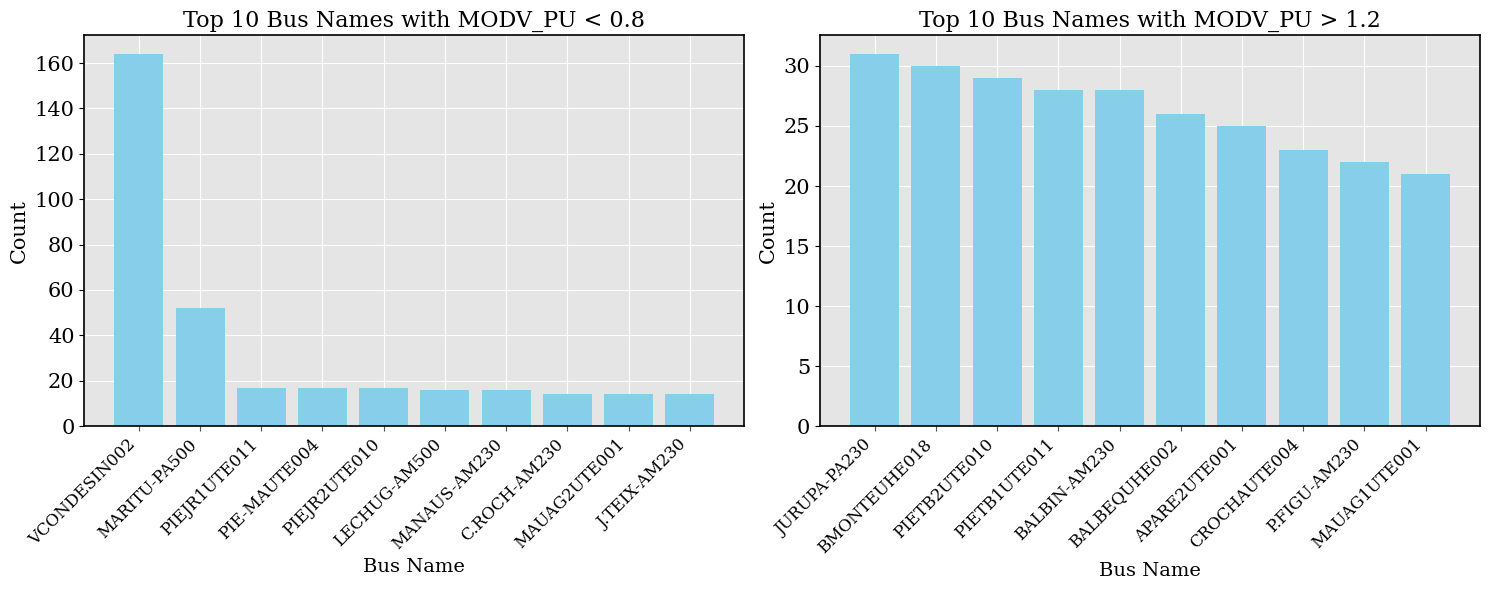

In [37]:
if Analise_INDICE:
    # Get the counts
    bus_counts_lower = df_complete[df_complete['MODV_PU'] < 0.8].value_counts('BUS_NAME').sort_values(ascending=False)
    bus_counts_upper = df_complete[df_complete['MODV_PU'] > 1.2].value_counts('BUS_NAME').sort_values(ascending=False)

    # Select the first 10 elements for each
    top_10_bus_counts_l = bus_counts_lower[:10]
    top_10_bus_counts_u = bus_counts_upper[:10]

    # Create indices for the bars
    indices_l = np.arange(len(top_10_bus_counts_l))
    indices_u = np.arange(len(top_10_bus_counts_u))

    # Create a figure with two subplots side by side
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Plot lower bus counts in the left subplot
    ax[0].bar(indices_l, top_10_bus_counts_l, color='skyblue')
    ax[0].set_title('Top 10 Bus Names with MODV_PU < 0.8', fontsize=16)
    ax[0].set_xlabel('Bus Name', fontsize=14,color ='black')
    ax[0].set_ylabel('Count', fontsize=15, color ='black')
    ax[0].set_xticks(indices_l)
    ax[0].set_xticklabels(top_10_bus_counts_l.index, rotation=45, ha='right', fontsize=12, color ='black')
    ax[0].tick_params(axis='y', colors='black',labelsize=15, rotation = 0)

    # Plot upper bus counts in the right subplot
    ax[1].bar(indices_u, top_10_bus_counts_u, color='skyblue')
    ax[1].set_title('Top 10 Bus Names with MODV_PU > 1.2', fontsize=16)
    ax[1].set_xlabel('Bus Name', fontsize=14, color ='black')
    ax[1].set_ylabel('Count', fontsize=15, color ='black')
    ax[1].set_xticks(indices_u)
    ax[1].set_xticklabels(top_10_bus_counts_u.index, rotation=45, ha='right', fontsize=12, color ='black')
    ax[1].tick_params(axis='y', colors='black',labelsize=15, rotation = 0)
    # Adjust layout to avoid overlap

    # Customize axes spines
    border_color = 'black'
    linewidth = 1.2
    ax[0].spines['top'].set_color(border_color)
    ax[0].spines['bottom'].set_color(border_color)
    ax[0].spines['left'].set_color(border_color)
    ax[0].spines['right'].set_color(border_color)
    ax[0].spines['top'].set_linewidth(linewidth)
    ax[0].spines['bottom'].set_linewidth(linewidth)
    ax[0].spines['left'].set_linewidth(linewidth)
    ax[0].spines['right'].set_linewidth(linewidth)

    ax[1].spines['top'].set_color(border_color)
    ax[1].spines['bottom'].set_color(border_color)
    ax[1].spines['left'].set_color(border_color)
    ax[1].spines['right'].set_color(border_color)
    ax[1].spines['top'].set_linewidth(linewidth)
    ax[1].spines['bottom'].set_linewidth(linewidth)
    ax[1].spines['left'].set_linewidth(linewidth)
    ax[1].spines['right'].set_linewidth(linewidth)

    plt.tight_layout()
    plt.savefig('Plots/barplot.svg')
    plt.show()


### Plot Tensão 2 filter DBSCAN (Scatter)

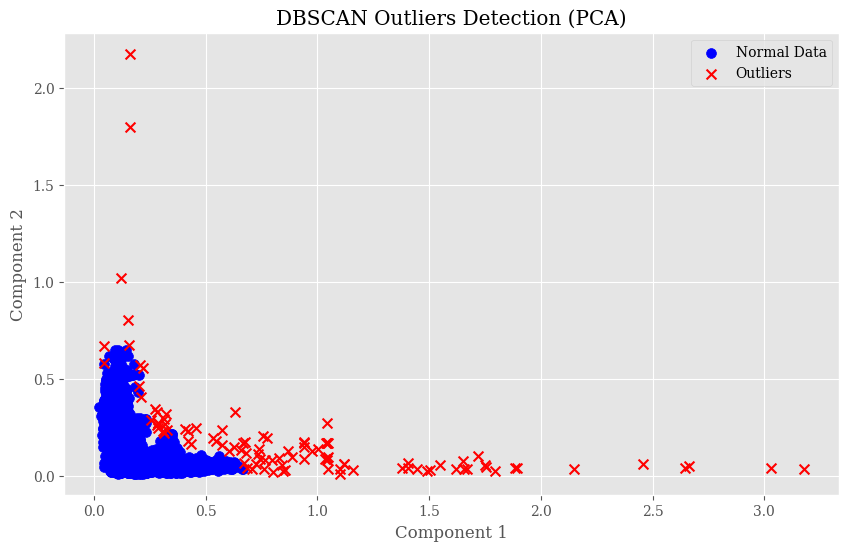

O casos normais são: (15620, 6)
O casos anomalos são: (103, 6)


In [38]:
if Analise_INDICE:
    # col = ['IndiceInf_s2_PV', 'IndiceSup_s2_PV', 'IndiceInf_s2_PQ', 'IndiceSup_s2_PQ']
    # dfanalise = flatdataframe(df_Index_DPI_s2.reset_index().set_index(['Dia', 'Hora', 'Cenario', 'REG']), 'all', 'all', col)
    dbscan_outliers = filtrarDBSCAN (df_Index_DPI_s3[~insecure_indices_po][['IndiceInf_s3','IndiceSup_s3']], dbscan_eps=0.05, dbscan_min_samples=20)
    # dbscan_outliers = filtrarDBSCAN (dfanalise[~insecure_indices_po], dbscan_eps=0.08, dbscan_min_samples=20)

In [39]:
def scatterplot_1(df, v1, v2, xlbl, ylbl, lbl_bar = None , v3 = None, xlimites = None, ylimites = None, title = None, vline = False, hline = False, show_outliers = False):

    # cmap = plt.cm.get_cmap("rainbow")  # '_r' suffix to reverse the colormap
    cmap = sns.color_palette("Set1")

    plt.figure(figsize=(10, 6))
    if v3 == None:
        if show_outliers == False:
            scatter = sns.scatterplot(data=df[~dbscan_outliers], x=v1, y=v2, s=100, color = sns.color_palette()[1], legend=None)
        if show_outliers:
            scatter = sns.scatterplot(data=df[~dbscan_outliers], x=v1, y=v2, s=100, color = sns.color_palette()[1], legend=None)
            scatter = sns.scatterplot(data=df[dbscan_outliers], x=v1, y=v2, s=100, color =  sns.color_palette()[0], legend=None)
            plt.legend(['Normal','Outliers'], fontsize = 15, loc='upper right')
    else:
        scatter = sns.scatterplot(data=df, x=v1, y=v2, palette=cmap, hue=v3, s=60, legend='full', alpha = 0.6)
        # norm = mcolors.Normalize(vmin=df[v3].min(), vmax=df[v3].max())
        # sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        # sm.set_array([])
        # cbar = plt.colorbar(sm, ax=scatter, orientation='vertical', label= lbl_bar,)
        # cbar.ax.yaxis.set_tick_params(color='black',labelsize=12)
        # plt.setp(cbar.ax.get_yticklabels(), color='black')
        # cbar.set_label(lbl_bar, fontsize=15, color='black')
        # Set legend properties (optional)
        plt.legend(title=lbl_bar, title_fontsize=15, labelspacing=1, fontsize=10, edgecolor='black')


    # plt.grid(True, which="both", linestyle='--', linewidth=0.5)

    border_color = 'black'
    linewidth = 1.2
    scatter.spines['top'].set_color(border_color)
    scatter.spines['bottom'].set_color(border_color)
    scatter.spines['left'].set_color(border_color)
    scatter.spines['right'].set_color(border_color)
    scatter.spines['top'].set_linewidth(linewidth)
    scatter.spines['bottom'].set_linewidth(linewidth)
    scatter.spines['left'].set_linewidth(linewidth)
    scatter.spines['right'].set_linewidth(linewidth)

    nometitulo = title
    plt.title(nometitulo, fontsize = 15)
    plt.xlabel(xlbl, fontsize = 17, color ='black')
    # plt.legend(fontsize = 15, loc='upper left')
    plt.ylabel(ylbl, fontsize = 17, color ='black')
    if hline:
        plt.axhline(1, color='red', linestyle='--', alpha=0.9)
    if vline:
        plt.axvline(1, color='red', linestyle='--', alpha=0.9)
    plt.tick_params(axis='both', labelsize=15, labelcolor='black')
    plt.tick_params(axis='x', colors='black',labelsize=15, rotation = 0)  # Set the color for the x-axis ticks
    plt.tick_params(axis='y', colors='black')  # Set the color for the y-axis ticks
    if xlimites != None:
        plt.xlim(xlimites)
    if ylimites != None:
        plt.ylim(ylimites)

    plt.savefig(f"Plots/{title}.svg")
    plt.show()
    correlation = df[v1].corr(df[v2])
    print(f"Indice de Correlación: {correlation}")

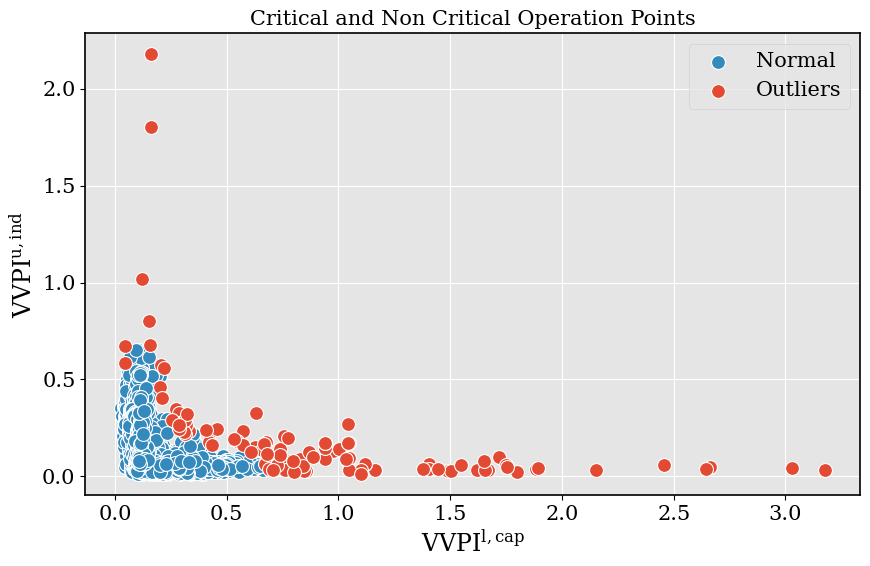

Indice de Correlación: -0.263572069631729


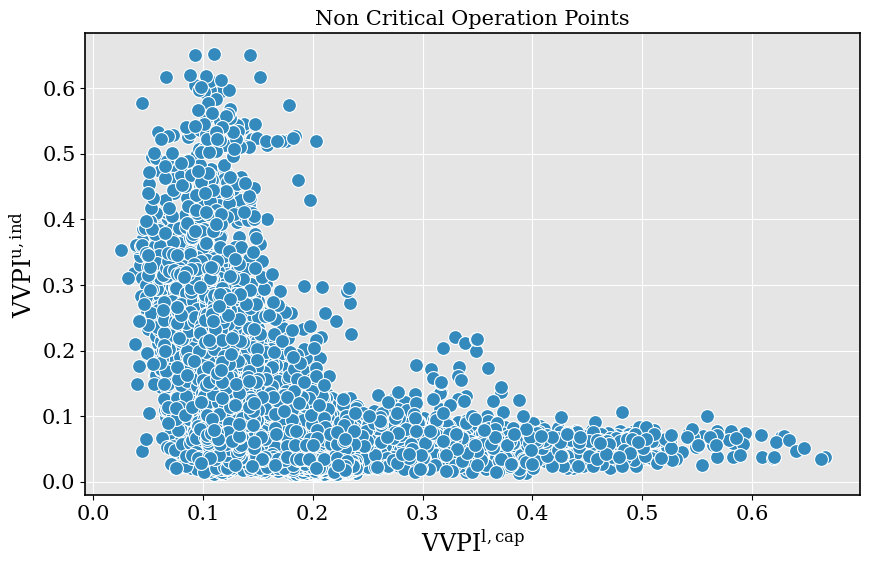

Indice de Correlación: -0.263572069631729


In [40]:
vpi_inf_max = r'$\mathrm{VVPI}^\mathrm{l,cap}$'
vpi_sup_min = r'$\mathrm{VVPI}^\mathrm{u,ind}$'

if Analise_INDICE:

    scatterplot_1(df_Index_DPI_s3[~insecure_indices_po], 'IndiceInf_s3', 'IndiceSup_s3', xlbl= f'{vpi_inf_max}', ylbl = f'{vpi_sup_min}',lbl_bar= 'Demanda Liquida (MW)', vline=False, hline=False , title='Critical and Non Critical Operation Points', show_outliers=True) # , ylimites=[0,5], xlimites=[0,5]

    scatterplot_1(df_Index_DPI_s3[~insecure_indices_po], 'IndiceInf_s3', 'IndiceSup_s3', xlbl=f'{vpi_inf_max}', ylbl = f'{vpi_sup_min}',lbl_bar= 'Demanda Liquida (MW)', vline=False, hline=False , title='Non Critical Operation Points', show_outliers=False)

In [41]:
# outliers2 = set(df_Index_DPI_s3[~insecure_indices_po][dbscan_outliers].index.to_frame()[['key', 'Cenario']].apply(tuple, axis=1).values)
# filtro_boxplot = df_complete_filt[['key', 'Cenario']].apply(tuple, axis=1).isin(outliers2)

# boxplot_voltage(df_complete_filt[~filtro_boxplot], clase = "REG", titulo = 'Voltage Bus-bar Distribution by Area', xlbl = 'Area', ylbl='Voltage (p.u)', size = (12,6))

### Plot Tensão 2 (Boxplot)

In [42]:
# if Analise_INDICE:

#     filtro_S2 = df_Index_DPI_s2.index.to_frame()[['key', 'Cenario']].apply(tuple, axis=1).isin(outliers_index)
#     outliers2 = set(df_Index_DPI_s3[~insecure_indices_po][dbscan_outliers].index.to_frame()[['key', 'Cenario']].apply(tuple, axis=1).values)
#     filtro_S3 = df_Index_DPI_s2[~filtro_S2].index.to_frame()[['key', 'Cenario']].apply(tuple, axis=1).isin(outliers2)

#     vpi_inf = r'$\mathrm{VVPI}^\mathrm{l,cap}$'
#     vpi_sup = r'$\mathrm{VVPI}^\mathrm{u,ind}$'

    # df = pd.melt(df_Index_DPI_s2[~filtro_S2][filtro_S3][['IndiceSup_s2_PV','IndiceSup_s2_PQ','REG']].reset_index(), id_vars=['REG'], value_vars=['IndiceSup_s2_PQ','IndiceSup_s2_PV'], ignore_index = False)
    # boxplot_(df,'value', 'REG', 'VVPI boxplot Ouliers upper', 'Region', f'{vpi_sup}', hue="variable") #, ylim= [-0.1,4]
    # df = pd.melt(df_Index_DPI_s2[~filtro_S2][filtro_S3][['IndiceInf_s2_PV','IndiceInf_s2_PQ','REG']].reset_index(), id_vars=['REG'], value_vars=['IndiceInf_s2_PQ','IndiceInf_s2_PV'], ignore_index = False)
    # boxplot_(df,'value', 'REG', 'VVPI boxplot Ouliers lower', 'Region', f'{vpi_inf}', hue="variable")

    
#     df = pd.melt(df_Index_DPI_s2[~filtro_S2][~filtro_S3][['IndiceSup_s2_PV','IndiceSup_s2_PQ','REG']].reset_index(), id_vars=['REG'], value_vars=['IndiceSup_s2_PQ','IndiceSup_s2_PV'], ignore_index = False)
#     boxplot_(df,'value', 'REG', 'VVPI boxplot upper', 'Region', f'{vpi_sup}', hue="variable")
#     df = pd.melt(df_Index_DPI_s2[~filtro_S2][~filtro_S3][['IndiceInf_s2_PV','IndiceInf_s2_PQ','REG']].reset_index(), id_vars=['REG'], value_vars=['IndiceInf_s2_PQ','IndiceInf_s2_PV'], ignore_index = False)
#     boxplot_(df,'value', 'REG', 'VVPI boxplot lower', 'Region', f'{vpi_inf}', hue="variable")#ylim=[-0.04,0.8]

# AVALIACION NORMALES

### Parametros

In [98]:
if Analise_INDICE:

    Region = ['Norte','Sul','SE-CO','Nordeste', 'AC-RO']    
    
    dfPV = df_PV.merge(df_area[['ARE','Nome da Area']], on='ARE', how='left')
    dfPQ = df_PQ.merge(df_area[['ARE','Nome da Area']], on='ARE', how='left')

    # filtro_pv = dfPV[['key', 'Cenario']].apply(tuple, axis=1).isin(list(outliers2) + list(outliers))
    # filtro_pq = dfPQ[['key', 'Cenario']].apply(tuple, axis=1).isin(list(outliers2) + list(outliers))

    filtro_pv = dfPV[['key', 'Cenario']].apply(tuple, axis=1).isin(list(outliers_index)) 
    filtro_pq = dfPQ[['key', 'Cenario']].apply(tuple, axis=1).isin(list(outliers_index)) 

    # filtro_pv = dfPV[['key', 'Cenario']].apply(tuple, axis=1).isin(list(outliers_index)) | dfPV[['key', 'Cenario']].apply(tuple, axis=1).isin(list(OPF_nc))
    # filtro_pq = dfPQ[['key', 'Cenario']].apply(tuple, axis=1).isin(list(outliers_index)) | dfPQ[['key', 'Cenario']].apply(tuple, axis=1).isin(list(OPF_nc))

    ## Avalição Correlação só barras PV========================
    df_PV_indices = dfPV[~filtro_pv]
    df_PV_indices = df_PV_indices.set_index(['key',  'Cenario', 'REG', GB])
    ## Avalição Correlação só barras PQ========================
    df_PQ_indices = dfPQ[~filtro_pq]
    df_PQ_indices = df_PQ_indices.set_index(['key',  'Cenario', 'REG', GB])

    n_AREAS = 20
    n_barras = 20

    def top_n_group(df, group_cols, sort_col, n):
        return df.groupby(group_cols).apply(lambda x: x.nlargest(n, sort_col)).reset_index(drop=True)

    # Filter regions
    df_PV_indices_reg = df_PV_indices.loc[:,:,Region,:][['IndiceInf_s1', 'IndiceSup_s1','RPI_ind', 'RPI_cap','Nome da Area']]
    df_PQ_indices_reg = df_PQ_indices.loc[:,:,Region,:][['IndiceInf_s1', 'IndiceSup_s1','RPI_ind', 'RPI_cap','Nome da Area']]

    # Aggregation function
    agg_cols = {
        'IndiceInf_s1': 'mean',
        'IndiceSup_s1': 'mean',
        'RPI_ind':'mean',
        'RPI_cap':'mean',
        'Nome da Area': 'first'
    }

    # Aggregate areas
    df_pv_areas = df_PV_indices_reg.groupby(['ARE']).agg(agg_cols).reset_index()
    df_pq_areas = df_PQ_indices_reg.groupby(['ARE']).agg(agg_cols).reset_index()

    # Sort and select top areas
    AREAS_inf_pv = df_pv_areas.nlargest(n_AREAS, 'IndiceInf_s1')
    AREAS_sup_pv = df_pv_areas.nlargest(n_AREAS, 'IndiceSup_s1')
    AREAS_inf_pq = df_pq_areas.nlargest(n_AREAS, 'IndiceInf_s1')
    AREAS_sup_pq = df_pq_areas.nlargest(n_AREAS, 'IndiceSup_s1')

    AREAS_ind_pv = df_pv_areas.nlargest(n_AREAS, 'RPI_ind')
    AREAS_cap_pv = df_pv_areas.nlargest(n_AREAS, 'RPI_cap')
    AREAS_ind_pq = df_pq_areas.nlargest(n_AREAS, 'RPI_ind')
    AREAS_cap_pq = df_pq_areas.nlargest(n_AREAS, 'RPI_cap')

    # Convert to lists for filtering
    listadeareas_inf_pv = AREAS_inf_pv['ARE'].tolist()
    listadeareas_sup_pv = AREAS_sup_pv['ARE'].tolist()
    listadeareas_inf_pq = AREAS_inf_pq['ARE'].tolist()
    listadeareas_sup_pq = AREAS_sup_pq['ARE'].tolist()

    listadeareas_ind_pv = AREAS_ind_pv['ARE'].tolist()
    listadeareas_cap_pv = AREAS_cap_pv['ARE'].tolist()
    listadeareas_ind_pq = AREAS_ind_pq['ARE'].tolist()
    listadeareas_cap_pq = AREAS_cap_pq['ARE'].tolist()

In [99]:
len(set(df_PV_indices_reg.reset_index()[['key', 'Cenario']].apply(tuple, axis=1)))

15723

In [100]:
if Analise_INDICE:
    DFindicesmerged = df_PV_indices_reg.reset_index().merge(df_PQ_indices_reg[['IndiceInf_s1', 'IndiceSup_s1', 'RPI_ind', 'RPI_cap']], on=['key','Cenario','ARE'], how='inner', suffixes=['_PV',  '_PQ'] ).set_index(['key','Cenario','ARE'])

In [175]:
def lineplotIndex(df, id_vars, value_vars, title, selectedindex, type):
    df_melted = pd.melt(df, id_vars=id_vars, value_vars=value_vars, ignore_index=False)
    lineplotIndice(df_melted, 'Nome Area', 'value', 'Control Area', '(p.u)', lbl_bar='variable', v3='variable', selectedindex = selectedindex, xlimites=None, ylimites=None, title=title, vline=False, hline=False,sizelbl=10, rotation = 30, type=type)

def lineplotIndice_mod_01(df, v1, v2, xlbl, ylbl, selectedindex, lbl_bar=None, v3=None, v4=False, xlimites=None, ylimites=None, title=None, vline=False, hline=False, sizelbl=15, rotation=0, line_plot=True):
    
    vpi_inf_PV = r'$\mathrm{VPI}_{PV}^\mathrm{l}$'
    vpi_sup_PV = r'$\mathrm{VPI}_{PV}^\mathrm{u}$'
    rpi_ind_PV = r'$\mathrm{RPI}_{PV}^\mathrm{abs}$'
    rpi_cap_PV = r'$\mathrm{RPI}_{PV}^\mathrm{inj}$'

    vpi_inf_PQ = r'$\mathrm{VPI}_{PQ}^\mathrm{l}$'
    vpi_sup_PQ = r'$\mathrm{VPI}_{PQ}^\mathrm{u}$'
    rpi_ind_PQ = r'$\mathrm{RPI}_{PQ}^\mathrm{abs}$'
    rpi_cap_PQ = r'$\mathrm{RPI}_{PQ}^\mathrm{inj}$'

    indexmap = {
        'IndiceInf_s1_PV': vpi_inf_PV, 'IndiceSup_s1_PV': vpi_sup_PV, 'RPI_ind_PV': rpi_ind_PV,
        'RPI_cap_PV': rpi_cap_PV, 'IndiceInf_PV' : vpi_inf_PV, 'IndiceSup_PV' : vpi_sup_PV, 'ReservaIND_PV':rpi_ind_PV, 'ReservaCAP_PV':rpi_cap_PV,
        'ReservaINDshunt_PV':rpi_ind_PV, 'ReservaCAPshunt_PV':rpi_cap_PV, 
        'IndiceInf_s1_PQ': vpi_inf_PQ, 'IndiceSup_s1_PQ': vpi_sup_PQ, 'RPI_ind_PQ': rpi_ind_PQ,
        'RPI_cap_PQ': rpi_cap_PQ, 'IndiceInf_PQ' : vpi_inf_PQ, 'IndiceSup_PQ' : vpi_sup_PQ, 'ReservaIND_PQ':rpi_ind_PQ, 'ReservaCAP_PQ':rpi_cap_PQ,
        'ReservaINDshunt_PQ':rpi_ind_PQ, 'ReservaCAPshunt_PQ':rpi_cap_PQ, 
    }

    df['variable'] = df['variable'].map(indexmap)
    
    cmap = plt.cm.get_cmap("rainbow")
    fig, ax1 = plt.subplots(figsize=(18, 9))
    
    # Define custom markers and colors
    markers = {vpi_inf_PV: 'o', vpi_sup_PV: 'o', rpi_ind_PV: '^', rpi_cap_PV: '^',vpi_inf_PQ: 'o', vpi_sup_PQ: 'o', rpi_ind_PQ: '^', rpi_cap_PQ: '^'}
    
    colors = {vpi_inf_PV: 'blue', vpi_sup_PV: 'green', rpi_ind_PV: 'orange', rpi_cap_PV: 'purple', vpi_inf_PQ: 'skyblue', vpi_sup_PQ: 'indigo', rpi_ind_PQ: 'brown', rpi_cap_PQ: 'forestgreen'}
    df = df.fillna(0)
    
    if v3 is None:
        sns.lineplot(data=df, x=v1, y=v2, legend=None, ax=ax1)
    else:
        sns.lineplot(data=df, x=v1, y=v2, hue=v3, style=v3, dashes = False, palette=colors, markers=markers, legend=True,  errorbar=None, ax=ax1, alpha = 1,  markerfacecolor='none', markeredgecolor='auto',markeredgewidth=2)
    
    for idx, line in enumerate(ax1.get_lines()):
        line.set_markersize(12)  # Set the marker size to 10 (or any size you want)
        if idx>0:
            line.set_dashes([5, 2, 5, 2])

    # Set legend with custom markers and colors
    handles, labels = ax1.get_legend_handles_labels()
    new_handles = []
    for handle in handles:
        marker = handle.get_marker()
        color = handle.get_color()
        new_handle = plt.Line2D([], [], linestyle='None', marker=marker, markersize=12,
                                markerfacecolor='none', markeredgecolor=color, markeredgewidth=2)
        new_handles.append(new_handle)
    
    # Update the legend with the new handles
    ax1.legend(new_handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.20), ncol=8, title='Indice', fontsize=18, title_fontsize=18, frameon=False)

    border_color = 'black'
    linewidth = 1.2
    ax1.spines['top'].set_color(border_color)
    ax1.spines['bottom'].set_color(border_color)
    ax1.spines['left'].set_color(border_color)
    ax1.spines['right'].set_color(border_color)
    ax1.spines['top'].set_linewidth(linewidth)
    ax1.spines['bottom'].set_linewidth(linewidth)
    ax1.spines['left'].set_linewidth(linewidth)
    ax1.spines['right'].set_linewidth(linewidth)
    
    ax1.set_title('', fontsize=12)
    ax1.set_xlabel(xlbl, fontsize=17, color='black')
    ax1.set_ylabel(ylbl, fontsize=17, color='black')
    if hline:
        ax1.axhline(0.8, color='red', linestyle='--', alpha=0.8, linewidth=2)
    if vline:
        ax1.axvline(1, color='red', linestyle='--', alpha=0.9)
        
    # Adjust x-axis tick labels position
    for tick in ax1.get_xticklabels():
        tick.set_horizontalalignment('right')
    
    ax1.tick_params(axis='both', labelsize=18, labelcolor='black')
    ax1.tick_params(axis='x', colors='black', labelsize=sizelbl, rotation=rotation)
    ax1.tick_params(axis='y', colors='black', labelsize=18)
    
    if xlimites is not None:
        ax1.set_xlim(xlimites)
    if ylimites is not None:
        ax1.set_ylim(ylimites)
        
    # If v4 is True, add the bar plot with frequency counts
    if v4:
        # Create a secondary y-axis
        ax2 = ax1.twinx()
        
        # Count the frequency of each x variable
        counts = df[df['variable']==indexmap[selectedindex]][v1].value_counts()
        
        # Ensure the counts are in the same order as the x-axis categories
        x_labels = ax1.get_xticks()
        x_ticklabels = ax1.get_xticklabels()
        x_ticklabels = [label.get_text() for label in x_ticklabels]
        counts = counts.reindex(x_ticklabels, fill_value=0)
        
        # Plot the counts as a bar plot
        bars = ax2.bar(x_ticklabels, counts.values, alpha=0.2, color='red', width=0.7)
        
        # Add count labels on top of each bar
        longitud = len(set(DFindicesmerged.reset_index()[['key','Cenario']].apply(tuple,axis=1).values))
        for bar, count in zip(bars, counts.values):
            percentage = count / longitud * 100  # Convert count to percentage
            ax2.text(
                bar.get_x() + bar.get_width() / 2,  # x position at the center of the bar
                bar.get_height(),  # y position at the top of the bar
                f'{percentage:.2f}%',  # text to display (the count value)
                ha='center',  # horizontal alignment
                va='bottom',  # vertical alignment
                fontsize=16,  # font size
                color='black',  # text color
                rotation=0
            )
        
        ax2.set_ylabel('Number of Cases', fontsize=17, color='black')
        ax2.tick_params(axis='y', colors='black',labelsize=18)
        ax2.tick_params(axis='x', colors='black', labelsize=sizelbl, rotation=rotation)
        
        # Adjust the x-axis labels to match
        ax2.set_xticks(x_labels)
        ax2.set_xticklabels(x_ticklabels)
        ax2.set_ylim([0,15723])
        ax2.grid(False)

        border_color = 'black'
        linewidth = 1.2
        ax2.spines['top'].set_color(border_color)
        ax2.spines['bottom'].set_color(border_color)
        ax2.spines['left'].set_color(border_color)
        ax2.spines['right'].set_color(border_color)
        ax2.spines['top'].set_linewidth(linewidth)
        ax2.spines['bottom'].set_linewidth(linewidth)
        ax2.spines['left'].set_linewidth(linewidth)
        ax2.spines['right'].set_linewidth(linewidth)
        
    plt.tight_layout()
    plt.savefig(f"Plots/{title}.svg")
    plt.savefig(f"Plots/{title}.png")
    plt.show()

def lineplotIndice_mod(df, v1, v2, xlbl, ylbl, selectedindex, lbl_bar=None, v3=None, v4=False, xlimites=None, ylimites=None, title=None, vline=False, hline=False, sizelbl=13, rotation=0, line_plot=True):
    
    vpi_inf_PV = r'$\mathrm{VPI}_{PV}^\mathrm{l}$'
    vpi_sup_PV = r'$\mathrm{VPI}_{PV}^\mathrm{u}$'
    rpi_ind_PV = r'$\mathrm{RPI}_{PV}^\mathrm{ind}$'
    rpi_cap_PV = r'$\mathrm{RPI}_{PV}^\mathrm{cap}$'

    vpi_inf_PQ = r'$\mathrm{VPI}_{PQ}^\mathrm{l}$'
    vpi_sup_PQ = r'$\mathrm{VPI}_{PQ}^\mathrm{u}$'
    rpi_ind_PQ = r'$\mathrm{RPI}_{PQ}^\mathrm{ind}$'
    rpi_cap_PQ = r'$\mathrm{RPI}_{PQ}^\mathrm{cap}$'

    indexmap = {
        'IndiceInf_s1_PV': vpi_inf_PV, 'IndiceSup_s1_PV': vpi_sup_PV, 'RPI_ind_PV': rpi_ind_PV,
        'RPI_cap_PV': rpi_cap_PV, 'IndiceInf_PV' : vpi_inf_PV, 'IndiceSup_PV' : vpi_sup_PV, 'ReservaIND_PV':rpi_ind_PV, 'ReservaCAP_PV':rpi_cap_PV,
        'ReservaINDshunt_PV':rpi_ind_PV, 'ReservaCAPshunt_PV':rpi_cap_PV, 
        'IndiceInf_s1_PQ': vpi_inf_PQ, 'IndiceSup_s1_PQ': vpi_sup_PQ, 'RPI_ind_PQ': rpi_ind_PQ,
        'RPI_cap_PQ': rpi_cap_PQ, 'IndiceInf_PQ' : vpi_inf_PQ, 'IndiceSup_PQ' : vpi_sup_PQ, 'ReservaIND_PQ':rpi_ind_PQ, 'ReservaCAP_PQ':rpi_cap_PQ,
        'ReservaINDshunt_PQ':rpi_ind_PQ, 'ReservaCAPshunt_PQ':rpi_cap_PQ, 
    }

    df['variable'] = df['variable'].map(indexmap)
    
    cmap = plt.cm.get_cmap("rainbow")
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Define custom markers and colors
    markers = {vpi_inf_PV: 'o', vpi_sup_PV: 'o', rpi_ind_PV: '^', rpi_cap_PV: '^',vpi_inf_PQ: 'o', vpi_sup_PQ: 'o', rpi_ind_PQ: '^', rpi_cap_PQ: '^'}
    
    colors = {vpi_inf_PV: 'blue', vpi_sup_PV: 'green', rpi_ind_PV: 'orange', rpi_cap_PV: 'purple', vpi_inf_PQ: 'skyblue', vpi_sup_PQ: 'indigo', rpi_ind_PQ: 'brown', rpi_cap_PQ: 'forestgreen'}
    df = df.fillna(0)
    
    if v3 is None:
        sns.lineplot(data=df, x=v1, y=v2, legend=None, ax=ax1)
    else:
        sns.lineplot(data=df, x=v1, y=v2, hue=v3, style=v3, palette=colors, markers=markers, legend=True, errorbar=('ci', 95), ax=ax1)
    
    for line in ax1.get_lines():
        line.set_markersize(12)  # Set the marker size to 10 (or any size you want)

    # Set legend with custom markers and colors
    handles, labels = ax1.get_legend_handles_labels()
    new_labels = []
    new_handles = []
    for handle, label in zip(handles, labels):
        if label in markers:
            new_handles.append(plt.Line2D([], [], marker=markers[label], color=colors[label], linestyle='None', markersize=10))
            new_labels.append(label)
    
    border_color = 'black'
    linewidth = 1.2
    ax1.spines['top'].set_color(border_color)
    ax1.spines['bottom'].set_color(border_color)
    ax1.spines['left'].set_color(border_color)
    ax1.spines['right'].set_color(border_color)
    ax1.spines['top'].set_linewidth(linewidth)
    ax1.spines['bottom'].set_linewidth(linewidth)
    ax1.spines['left'].set_linewidth(linewidth)
    ax1.spines['right'].set_linewidth(linewidth)
    
    ax1.legend(new_handles, new_labels, loc='upper left', bbox_to_anchor=(1.1, 1), title='INDICES', fontsize=15)
    ax1.set_title(title, fontsize=15)
    ax1.set_xlabel(xlbl, fontsize=17, color='black')
    ax1.set_ylabel(ylbl, fontsize=17, color='black')
    if hline:
        ax1.axhline(0.8, color='black', linestyle='--', alpha=0.8)
    if vline:
        ax1.axvline(1, color='red', linestyle='--', alpha=0.9)
        
    # Adjust x-axis tick labels position
    for tick in ax1.get_xticklabels():
        tick.set_horizontalalignment('right')
    
    ax1.tick_params(axis='both', labelsize=15, labelcolor='black')
    ax1.tick_params(axis='x', colors='black', labelsize=sizelbl, rotation=rotation)
    ax1.tick_params(axis='y', colors='black')
    
    if xlimites is not None:
        ax1.set_xlim(xlimites)
    if ylimites is not None:
        ax1.set_ylim(ylimites)
        
    # If v4 is True, add the bar plot with frequency counts
    if v4:
        # Create a secondary y-axis
        ax2 = ax1.twinx()
        
        # Count the frequency of each x variable
        counts = df[df['variable']==indexmap[selectedindex]][v1].value_counts()
        
        # Ensure the counts are in the same order as the x-axis categories
        x_labels = ax1.get_xticks()
        x_ticklabels = ax1.get_xticklabels()
        x_ticklabels = [label.get_text() for label in x_ticklabels]
        counts = counts.reindex(x_ticklabels, fill_value=0)
        
        # Plot the counts as a bar plot
        bars = ax2.bar(x_ticklabels, counts.values, alpha=0.2, color='red', width=0.7)
        
        # Add count labels on top of each bar
        for bar, count in zip(bars, counts.values):
            percentage = count / 15625 * 100  # Convert count to percentage
            ax2.text(
                bar.get_x() + bar.get_width() / 2,  # x position at the center of the bar
                bar.get_height(),  # y position at the top of the bar
                f'{percentage:.2f}%',  # text to display (the count value)
                ha='center',  # horizontal alignment
                va='bottom',  # vertical alignment
                fontsize=15,  # font size
                color='black',  # text color
                rotation=0
            )
        
        ax2.set_ylabel('Count', fontsize=17, color='black')
        ax2.tick_params(axis='y', colors='black',labelsize=15)
        ax2.tick_params(axis='x', colors='black', labelsize=sizelbl, rotation=rotation)
        
        # Adjust the x-axis labels to match
        ax2.set_xticks(x_labels)
        ax2.set_xticklabels(x_ticklabels)
        ax2.grid(False)
        
    # plt.tight_layout()
    plt.savefig(f"Plots/{title}.svg")
    plt.show()

def lineplotIndice_mod_01_bar(df, v1, v2, xlbl, ylbl, selectedindex, lbl_bar=None, v3=None, v4=False, xlimites=None, ylimites=None, title=None, vline=False, hline=False, sizelbl=15, rotation=0, line_plot=True):
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    vpi_inf_PV = r'$\mathrm{VPI}_{PV}^\mathrm{l}$'
    vpi_sup_PV = r'$\mathrm{VPI}_{PV}^\mathrm{u}$'
    rpi_ind_PV = r'$\mathrm{RPI}_{PV}^\mathrm{abs}$'
    rpi_cap_PV = r'$\mathrm{RPI}_{PV}^\mathrm{inj}$'

    vpi_inf_PQ = r'$\mathrm{VPI}_{PQ}^\mathrm{l}$'
    vpi_sup_PQ = r'$\mathrm{VPI}_{PQ}^\mathrm{u}$'
    rpi_ind_PQ = r'$\mathrm{RPI}_{PQ}^\mathrm{abs}$'
    rpi_cap_PQ = r'$\mathrm{RPI}_{PQ}^\mathrm{inj}$'

    indexmap = {
        'IndiceInf_s1_PV': vpi_inf_PV, 'IndiceSup_s1_PV': vpi_sup_PV, 'RPI_ind_PV': rpi_ind_PV,
        'RPI_cap_PV': rpi_cap_PV, 'IndiceInf_PV': vpi_inf_PV, 'IndiceSup_PV': vpi_sup_PV,
        'ReservaIND_PV': rpi_ind_PV, 'ReservaCAP_PV': rpi_cap_PV,
        'ReservaINDshunt_PV': rpi_ind_PV, 'ReservaCAPshunt_PV': rpi_cap_PV,
        'IndiceInf_s1_PQ': vpi_inf_PQ, 'IndiceSup_s1_PQ': vpi_sup_PQ, 'RPI_ind_PQ': rpi_ind_PQ,
        'RPI_cap_PQ': rpi_cap_PQ, 'IndiceInf_PQ': vpi_inf_PQ, 'IndiceSup_PQ': vpi_sup_PQ,
        'ReservaIND_PQ': rpi_ind_PQ, 'ReservaCAP_PQ': rpi_cap_PQ,
        'ReservaINDshunt_PQ': rpi_ind_PQ, 'ReservaCAPshunt_PQ': rpi_cap_PQ,
    }

    df['variable'] = df['variable'].map(indexmap)
    df = df.fillna(0)

    # Create the main figure and axis for the bar plot (left y-axis)
    fig, ax1 = plt.subplots(figsize=(18, 8))

    # Plot the bar plot on the left y-axis (ax1)
    if v4:
        # Count the frequency of each x variable for the selected index
        counts = df[df['variable'] == indexmap[selectedindex]][v1].value_counts()
        
        # Ensure the counts are in the same order as the DataFrame
        x_order = df[v1].unique()  # Assuming df is ordered by v1
        counts = counts.reindex(x_order, fill_value=0)
        x_positions = np.arange(len(x_order))
        
        # Plot the counts as a bar plot on ax1
        bars = ax1.bar(x_positions, counts.values, alpha=0.8, color='skyblue', width=0.7)
        
        # Set x-axis labels
        ax1.set_xticks(x_positions)
        ax1.set_xticklabels(x_order)
        longitud = len(set(DFindicesmerged.reset_index()[['key','Cenario']].apply(tuple,axis=1).values))
        # Add percentage labels on top of each bar
        for bar, count in zip(bars, counts.values):
            percentage = count / longitud * 100  # Convert count to percentage
            ax1.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f'{percentage:.2f}%',
                ha='center',
                va='bottom',
                fontsize=16,
                color='black',
                rotation=0
            )
        
        ax1.set_ylabel('Número de Casos', fontsize=17, color='black')
        ax1.tick_params(axis='y', colors='black', labelsize=18)
        ax1.tick_params(axis='x', colors='black', labelsize=sizelbl, rotation=rotation)
        ax1.set_xlabel(xlbl, fontsize=17, color='black')
        ax1.grid(axis='x')
        
        # Adjust spines
        border_color = 'black'
        linewidth = 1.2
        for spine in ax1.spines.values():
            spine.set_color(border_color)
            spine.set_linewidth(linewidth)
    else:
        # If no bar plot, set x-axis labels based on df[v1]
        x_order = df[v1].unique()
        x_positions = np.arange(len(x_order))
        ax1.set_xticks(x_positions)
        ax1.set_xticklabels(x_order)
        ax1.tick_params(axis='x', colors='black', labelsize=sizelbl, rotation=rotation)

    # # Create a secondary axis for the line plot (right y-axis)
    # ax2 = ax1.twinx()

    # # Map x-axis categories to positions for plotting
    # x_mapping = {label: pos for pos, label in enumerate(x_order)}
    # df['x_pos'] = df[v1].map(x_mapping)

    # # Define custom markers and colors
    # markers = {
    #     vpi_inf_PV: 'o', vpi_sup_PV: 'o', rpi_ind_PV: '^', rpi_cap_PV: '^',
    #     vpi_inf_PQ: 'o', vpi_sup_PQ: 'o', rpi_ind_PQ: '^', rpi_cap_PQ: '^'
    # }
    # colors = {
    #     vpi_inf_PV: 'blue', vpi_sup_PV: 'green', rpi_ind_PV: 'orange', rpi_cap_PV: 'purple',
    #     vpi_inf_PQ: 'skyblue', vpi_sup_PQ: 'indigo', rpi_ind_PQ: 'brown', rpi_cap_PQ: 'forestgreen'
    # }

    # # Plot the line plot on the right y-axis (ax2)
    # if v3 is None:
    #     sns.lineplot(data=df, x='x_pos', y=v2, legend=None, ax=ax2)
    # else:
    #     sns.lineplot(
    #         data=df, x='x_pos', y=v2, hue=v3, style=v3, dashes=False, palette=colors,
    #         markers=markers, legend=True, errorbar=None, ax=ax2, alpha=1,
    #         markerfacecolor='none', markeredgecolor='auto', markeredgewidth=2
    #     )

    # # Adjust the line plot to match x positions
    # for idx, line in enumerate(ax2.get_lines()):
    #     line.set_markersize(12)
    #     if idx > 0:
    #         line.set_dashes([5, 2, 5, 2])

    # # Set legend with custom markers and colors
    # handles, labels = ax2.get_legend_handles_labels()
    # new_handles = []
    # for handle in handles:
    #     marker = handle.get_marker()
    #     color = handle.get_color()
    #     new_handle = plt.Line2D(
    #         [], [], linestyle='None', marker=marker, markersize=12,
    #         markerfacecolor='none', markeredgecolor=color, markeredgewidth=2
    #     )
    #     new_handles.append(new_handle)

    # # Update the legend with the new handles
    # ax2.legend(
    #     new_handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=8,
    #     title='Index', fontsize=18, title_fontsize=18, frameon=False
    # )

    # # Adjust spines for ax2
    # for spine in ax2.spines.values():
    #     spine.set_color('black')
    #     spine.set_linewidth(1.2)

    # # Set labels and titles
    # ax1.set_xlabel(xlbl, fontsize=17, color='black')
    # ax2.set_ylabel(ylbl, fontsize=17, color='black')
    # ax2.tick_params(axis='y', colors='black', labelsize=18)
    # ax2.tick_params(axis='x', colors='black', labelsize=sizelbl, rotation=rotation)

    # # Add horizontal and vertical lines if specified
    # if hline:
    #     ax2.axhline(0.8, color='red', linestyle='--', alpha=0.8, linewidth=2)
    # if vline:
    #     # Map vline x-value to position
    #     vline_pos = x_mapping.get(1, None)
    #     if vline_pos is not None:
    #         ax2.axvline(vline_pos, color='red', linestyle='--', alpha=0.9)

    # # Set x and y limits if provided
    # if xlimites is not None:
    #     ax1.set_xlim(xlimites)
    #     ax2.set_xlim(xlimites)
    # else:
    #     ax1.set_xlim([-0.5, len(x_order) - 0.5])
    #     ax2.set_xlim([-0.5, len(x_order) - 0.5])

    # if ylimites is not None:
    #     ax2.set_ylim(ylimites)

    # Adjust x-axis tick labels position
    for tick in ax1.get_xticklabels():
        tick.set_horizontalalignment('right')
    plt.tight_layout()
    plt.savefig(f"Plots/{title}.svg")
    plt.savefig(f"Plots/{title}.png")
    plt.show()


In [165]:
def lineplotIndex_mod_01(df, id_vars, value_vars, title, selectedindex):
    df_melted = pd.melt(df, id_vars=id_vars, value_vars=value_vars, ignore_index=False)
    lineplotIndice_mod_01_bar(df_melted, 'Nome Area', 'value', 'Área de Controle', 'Index (p.u)', lbl_bar='variable', v3='variable', selectedindex = selectedindex, xlimites=None, ylimites=None, title=title + 'barplot', vline=False, hline=False,sizelbl=13, rotation = 30, v4=True)
    df_melted = pd.melt(df, id_vars=id_vars, value_vars=value_vars, ignore_index=False)
    lineplotIndice_mod_01(df_melted, 'Nome Area', 'value', 'Área de Controle', 'Indice (p.u)', lbl_bar='variable', v3='variable', selectedindex = selectedindex, xlimites=None, ylimites=None, title=title, vline=False, hline=False,sizelbl=13, rotation = 30, v4=False)

def lineplotIndex_mod(df, id_vars, value_vars, title, selectedindex):
    df_melted = pd.melt(df, id_vars=id_vars, value_vars=value_vars, ignore_index=False)
    lineplotIndice_mod(df_melted, 'Nome Area', 'value', 'Área de Controle', '(p.u)', lbl_bar='variable', v3='variable', selectedindex = selectedindex, xlimites=None, ylimites=None, title=title, vline=False, hline=False,sizelbl=10, rotation = 30, v4=True)

def lineplotIndex_bus(df, id_vars, value_vars, title, selectedindex, type):
        df_melted = pd.melt(df, id_vars=id_vars, value_vars=value_vars, ignore_index=False)
        lineplotIndice(df_melted, 'Nome BUS', 'value', 'Barra', 'Valor médio (p.u)', lbl_bar='', v3='variable', selectedindex = selectedindex, xlimites=None, title=title, vline=False, hline=True, sizelbl=15, rotation = 30, type=type, ylimites=[-0.05,1.2])

C:\Users\david\AppData\Local\Temp\ipykernel_28940\97462747.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_area_critica['ARE_count'] = df_area_critica.groupby(level='ARE').transform('count')['RPI_ind_PV']


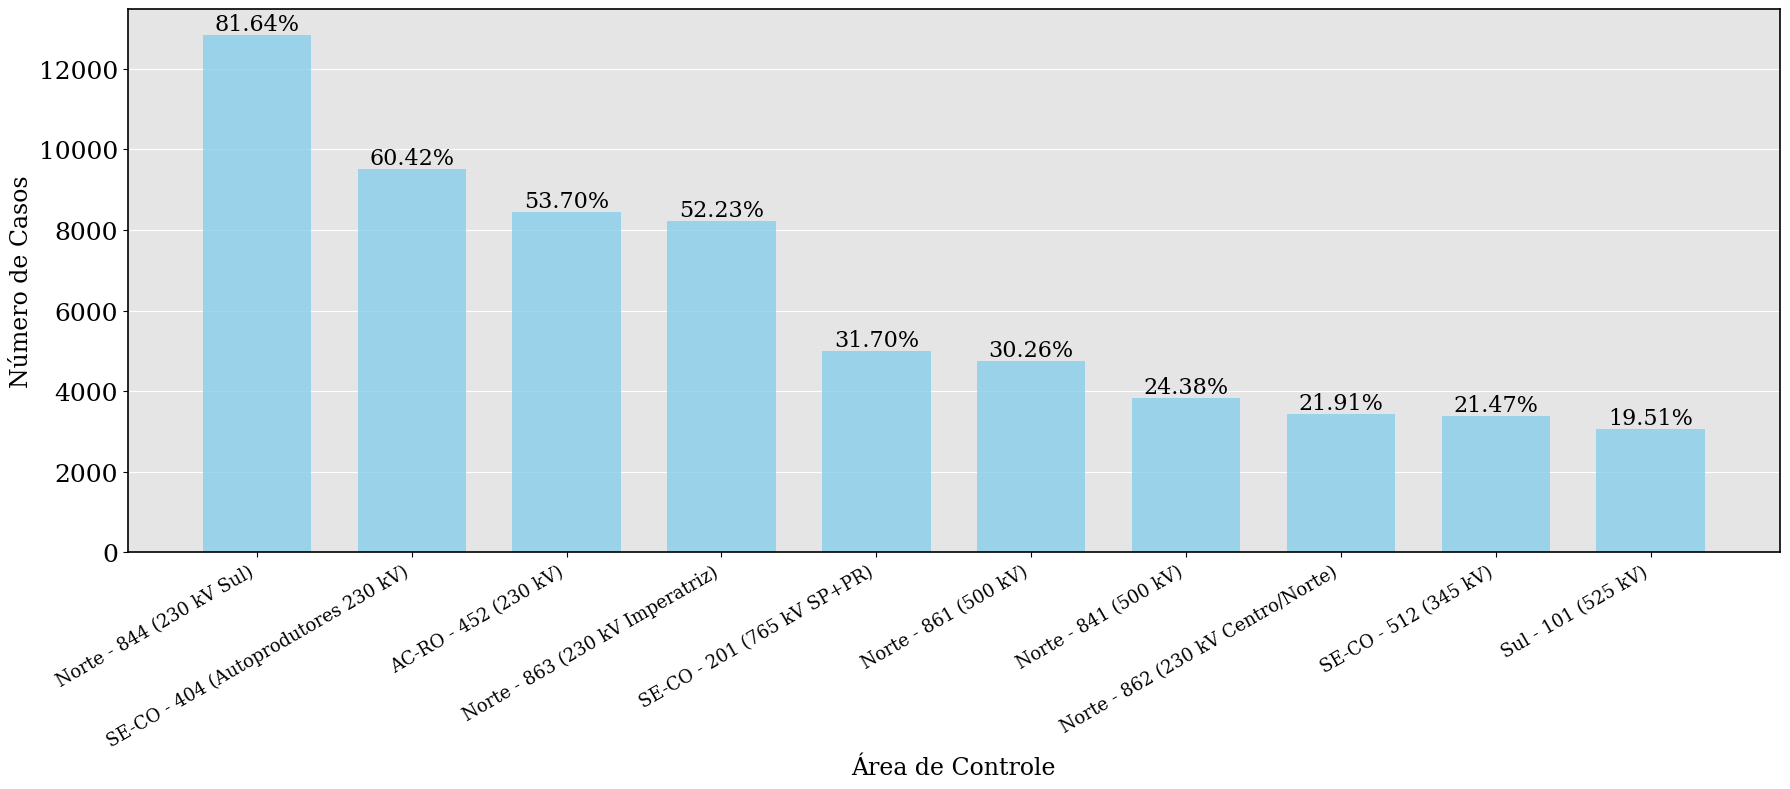

C:\Users\david\AppData\Local\Temp\ipykernel_28940\2126073034.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")


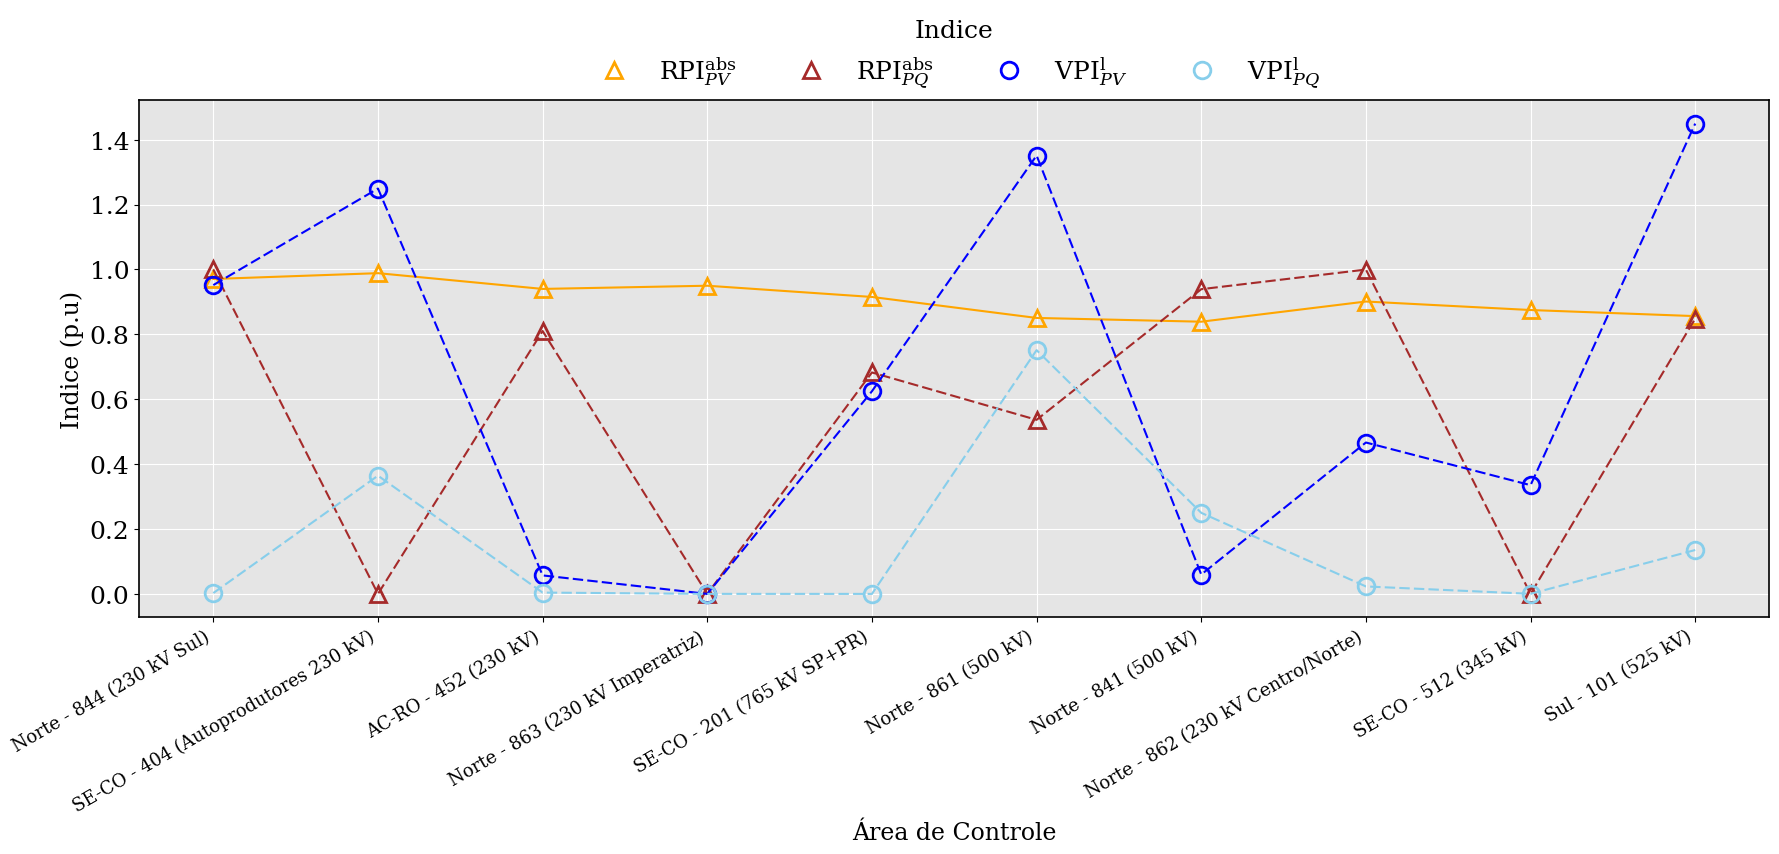

C:\Users\david\AppData\Local\Temp\ipykernel_28940\97462747.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_area_critica['ARE_count'] = df_area_critica.groupby(level='ARE').transform('count')['RPI_ind_PV']


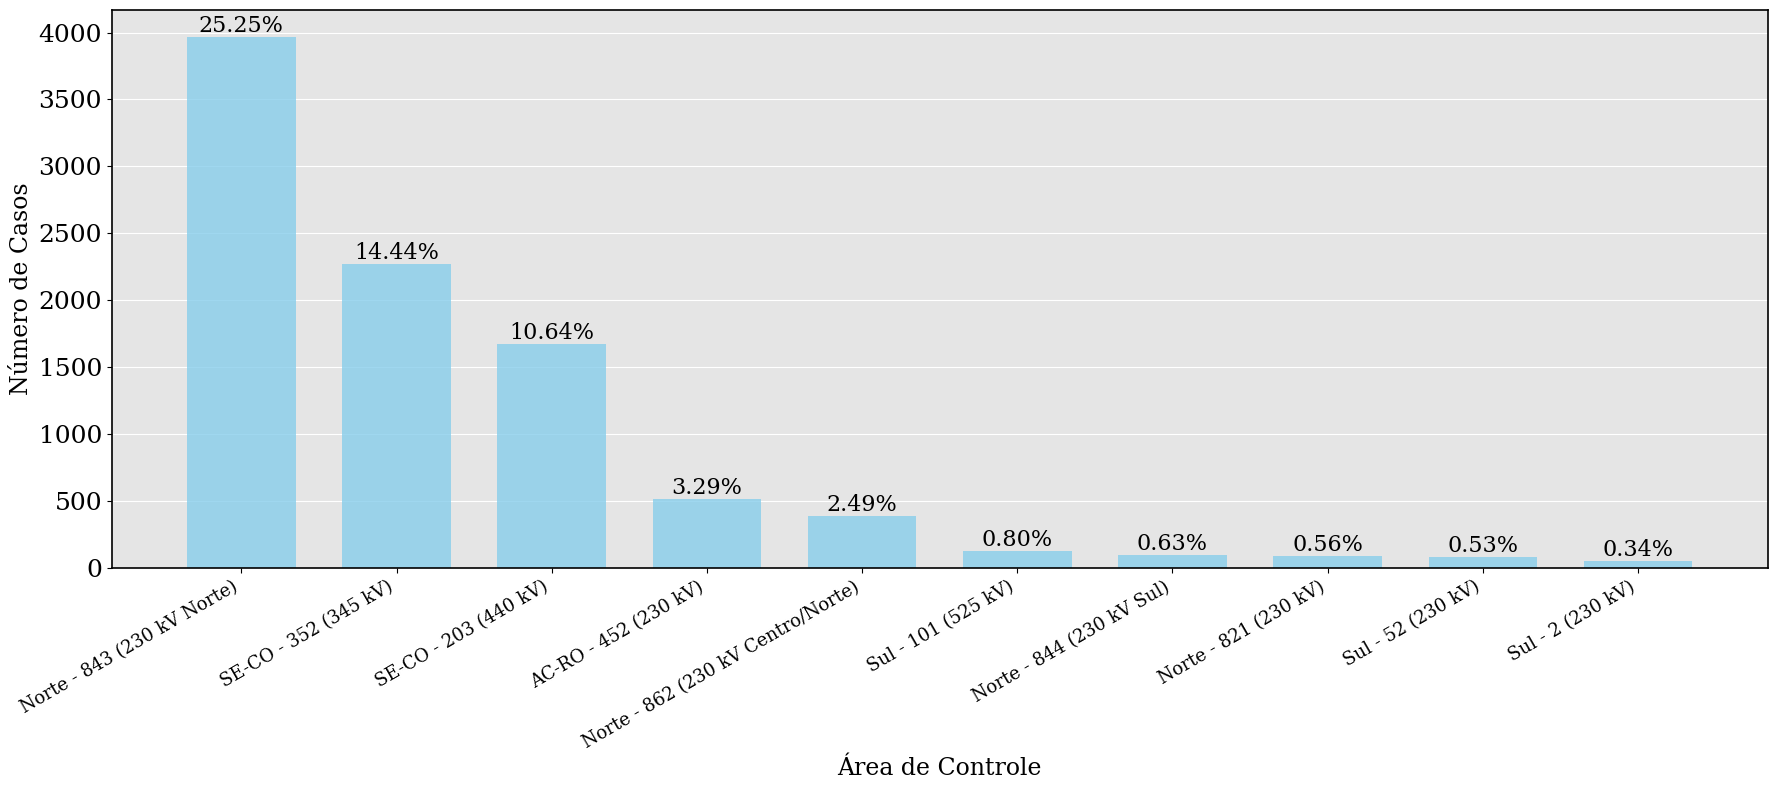

C:\Users\david\AppData\Local\Temp\ipykernel_28940\2126073034.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")


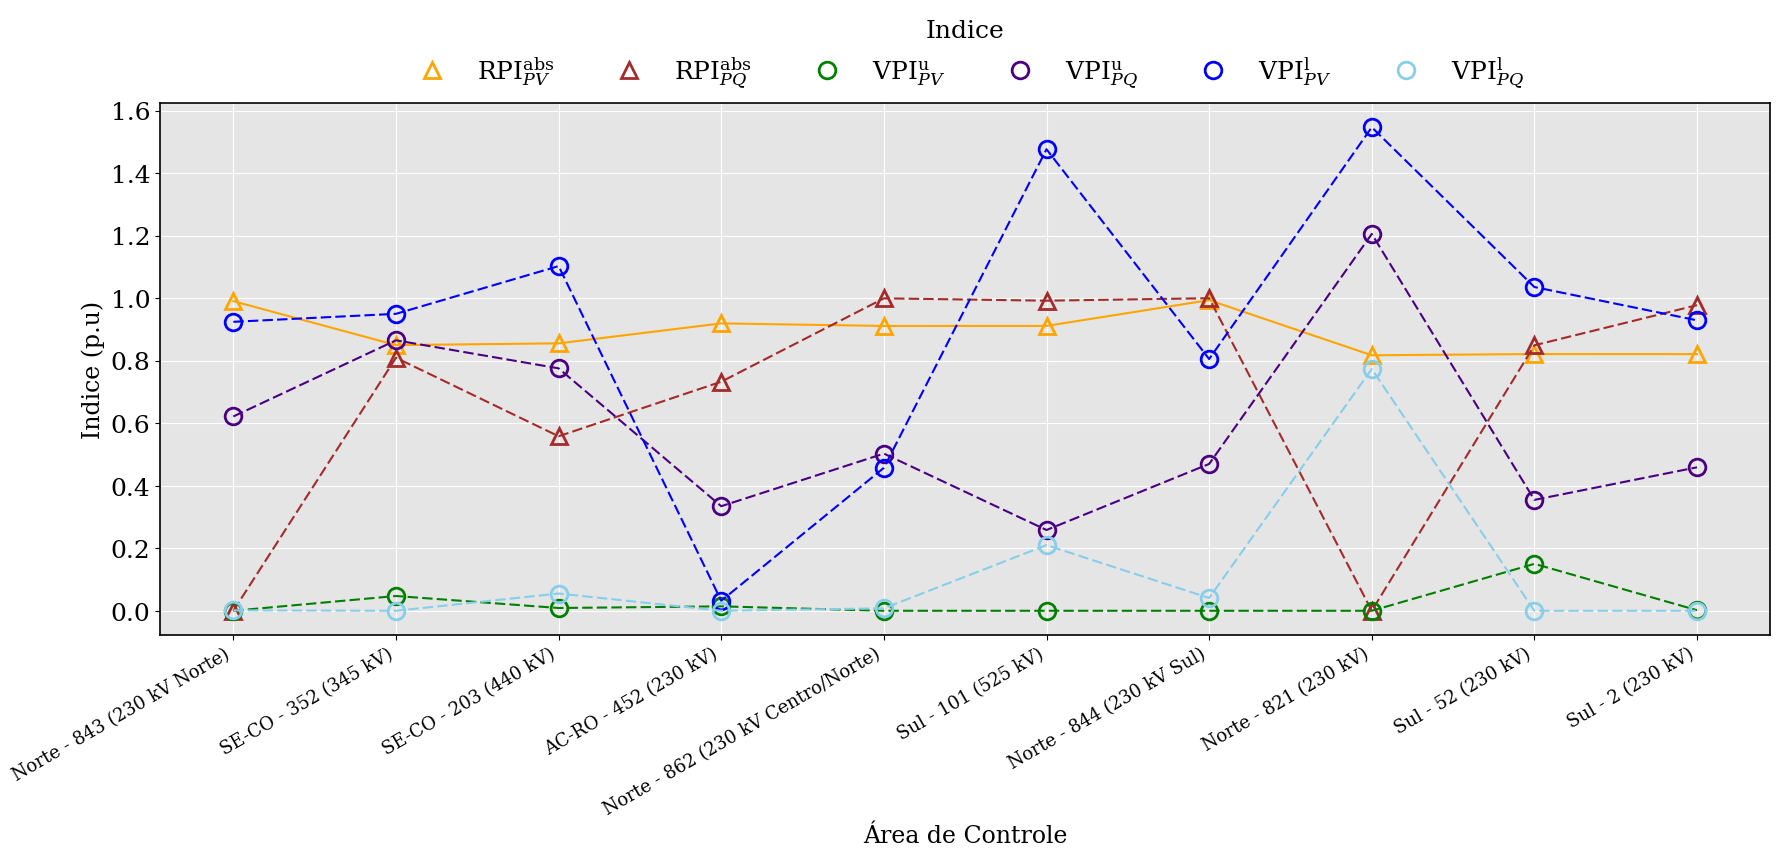

C:\Users\david\AppData\Local\Temp\ipykernel_28940\97462747.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_area_critica['ARE_count'] = df_area_critica.groupby(level='ARE').transform('count')['RPI_cap_PV']


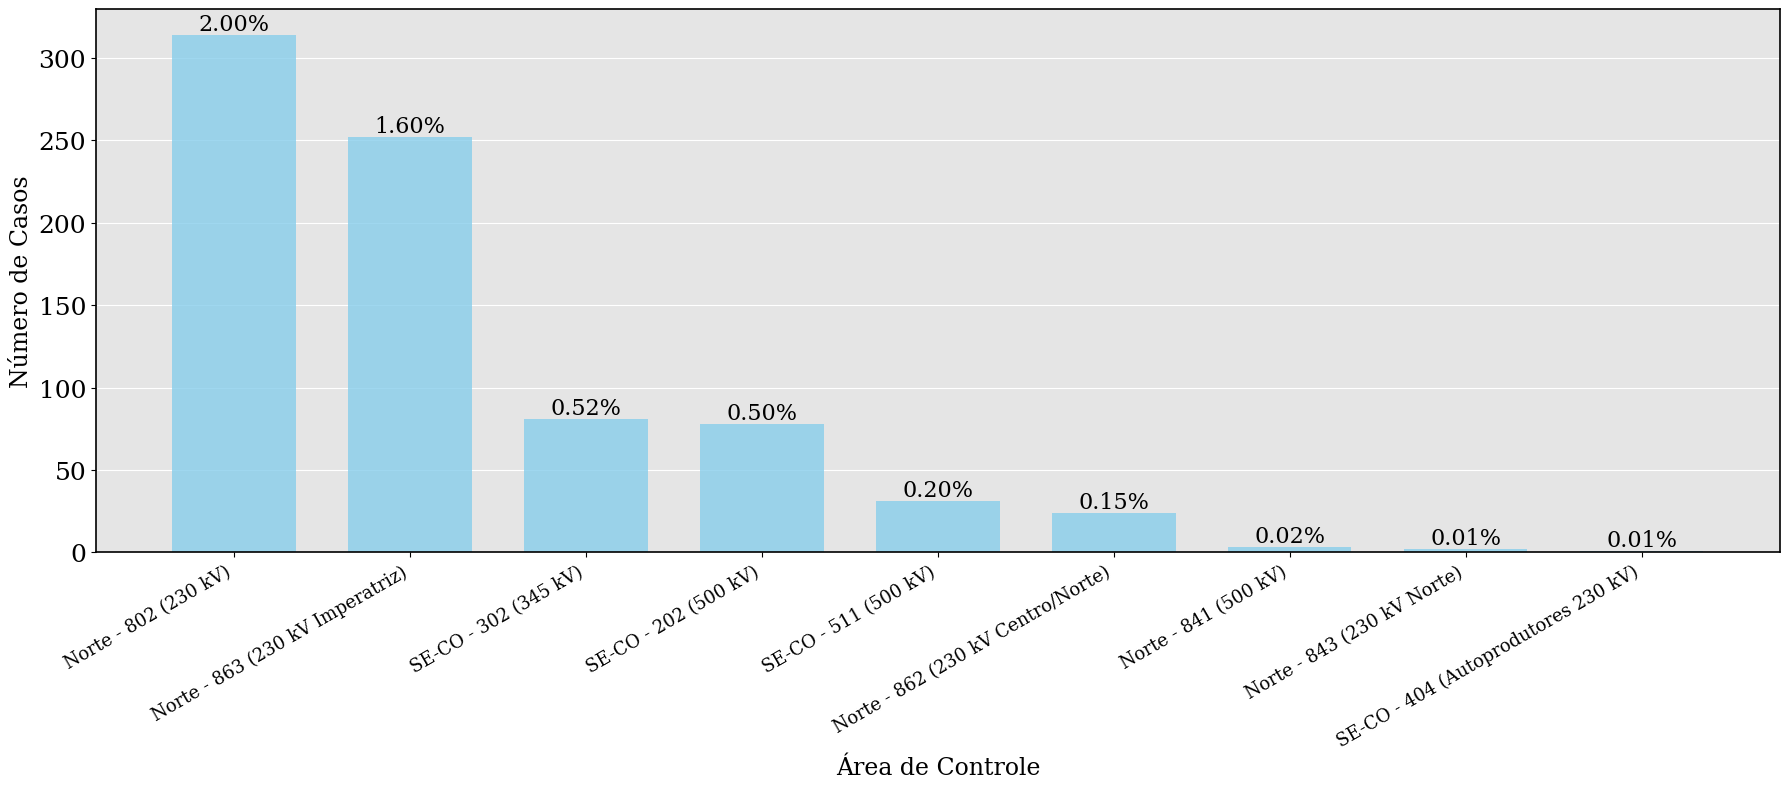

C:\Users\david\AppData\Local\Temp\ipykernel_28940\2126073034.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")


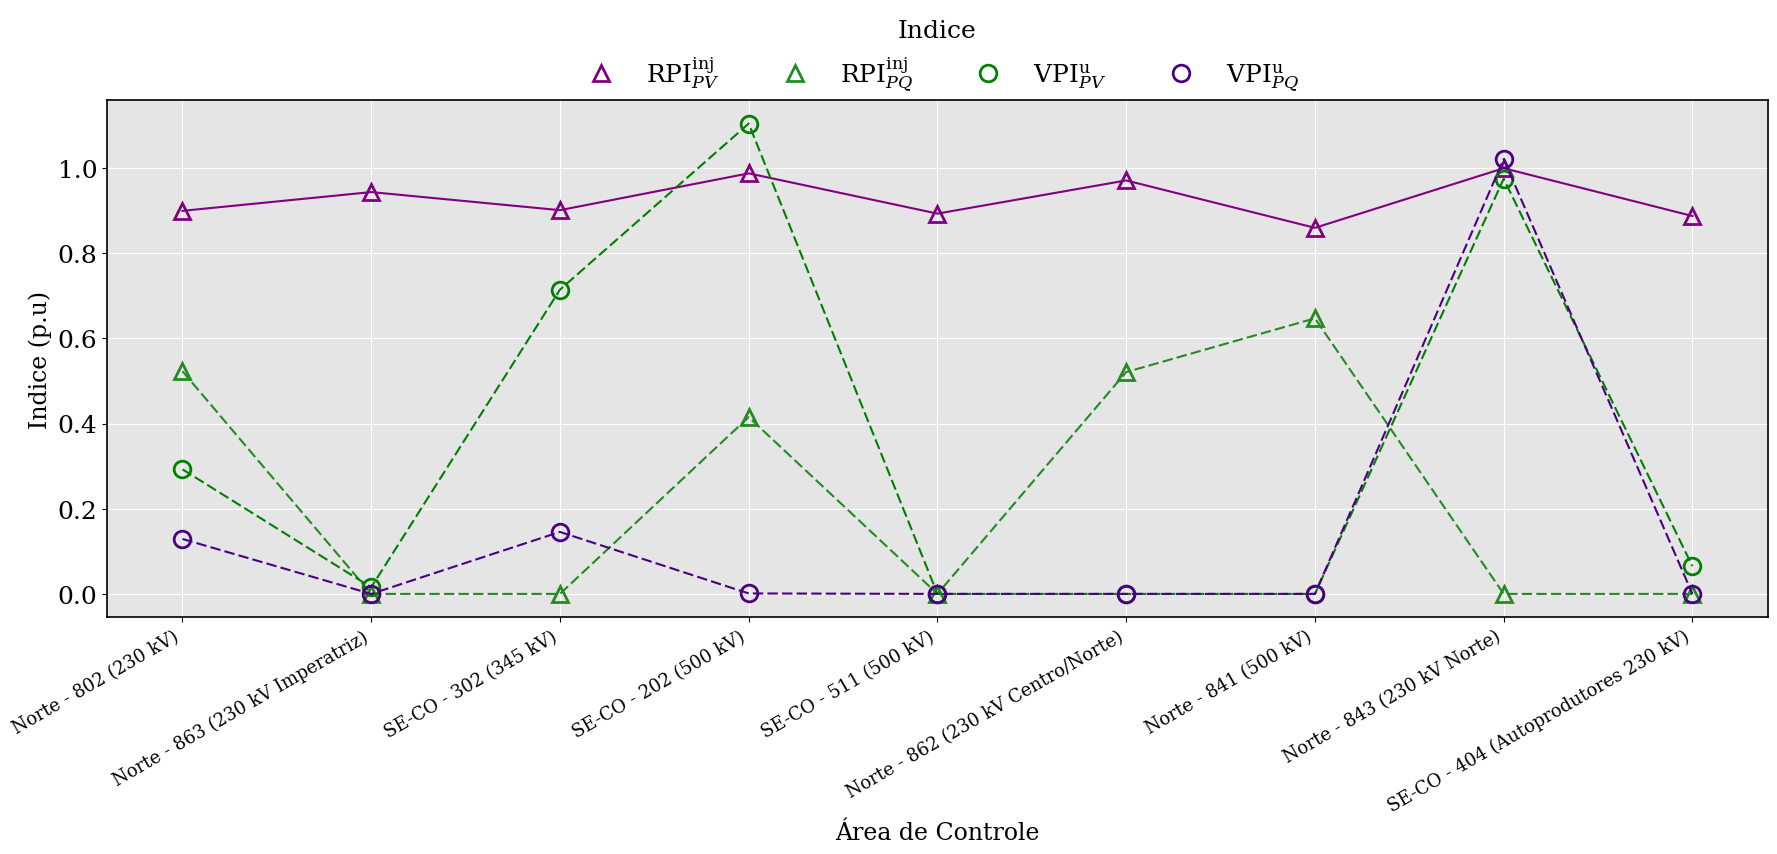

C:\Users\david\AppData\Local\Temp\ipykernel_28940\97462747.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_area_critica['ARE_count'] = df_area_critica.groupby(level='ARE').transform('count')['RPI_cap_PV']


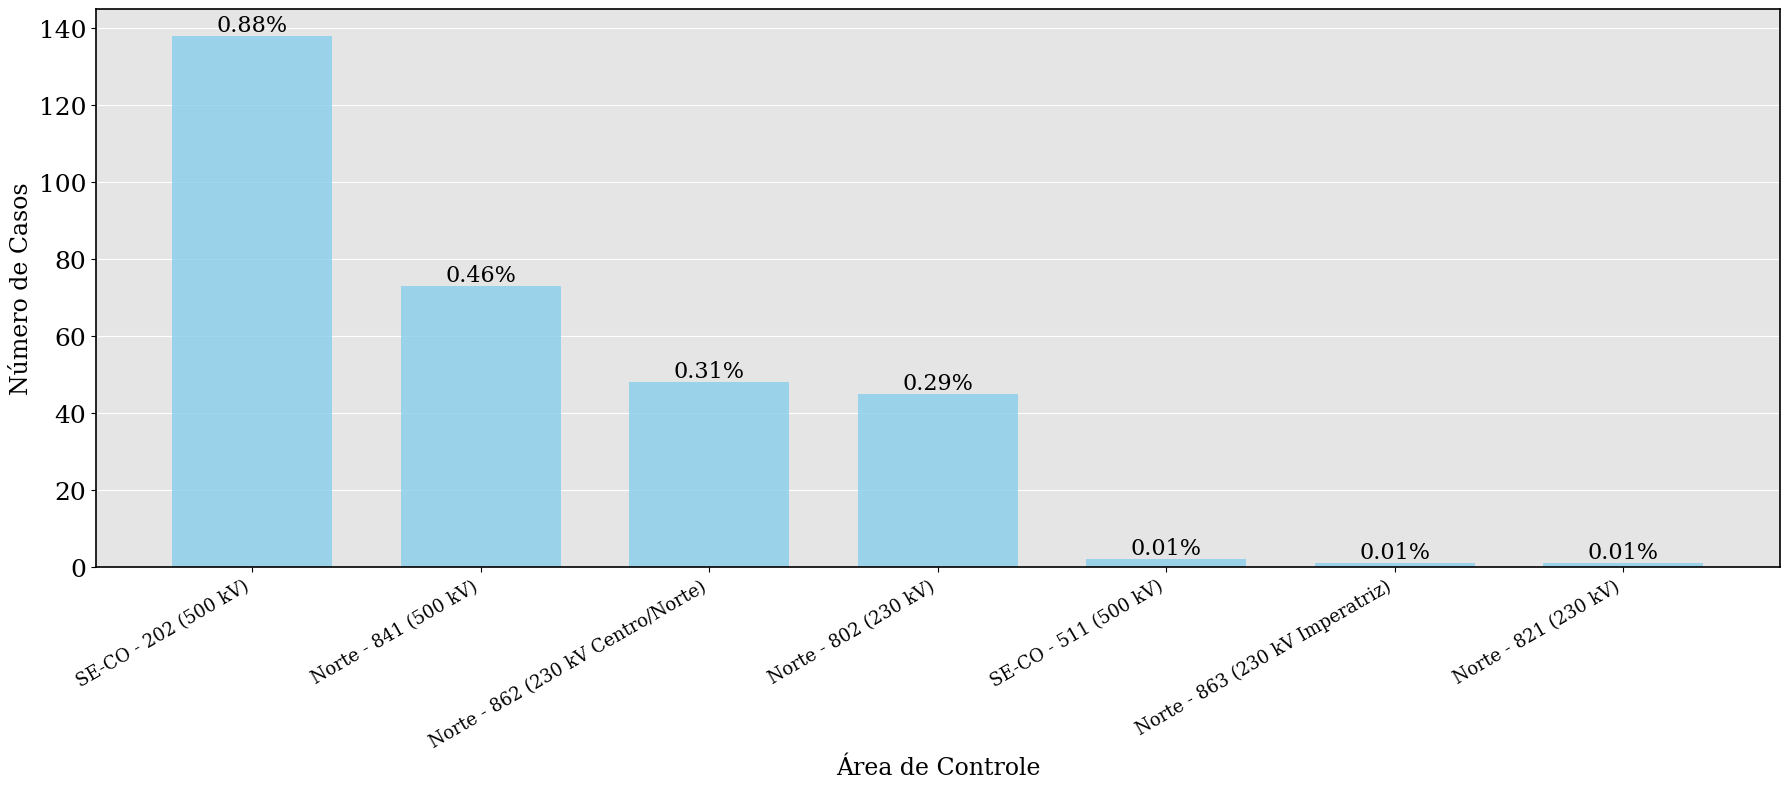

C:\Users\david\AppData\Local\Temp\ipykernel_28940\2126073034.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")


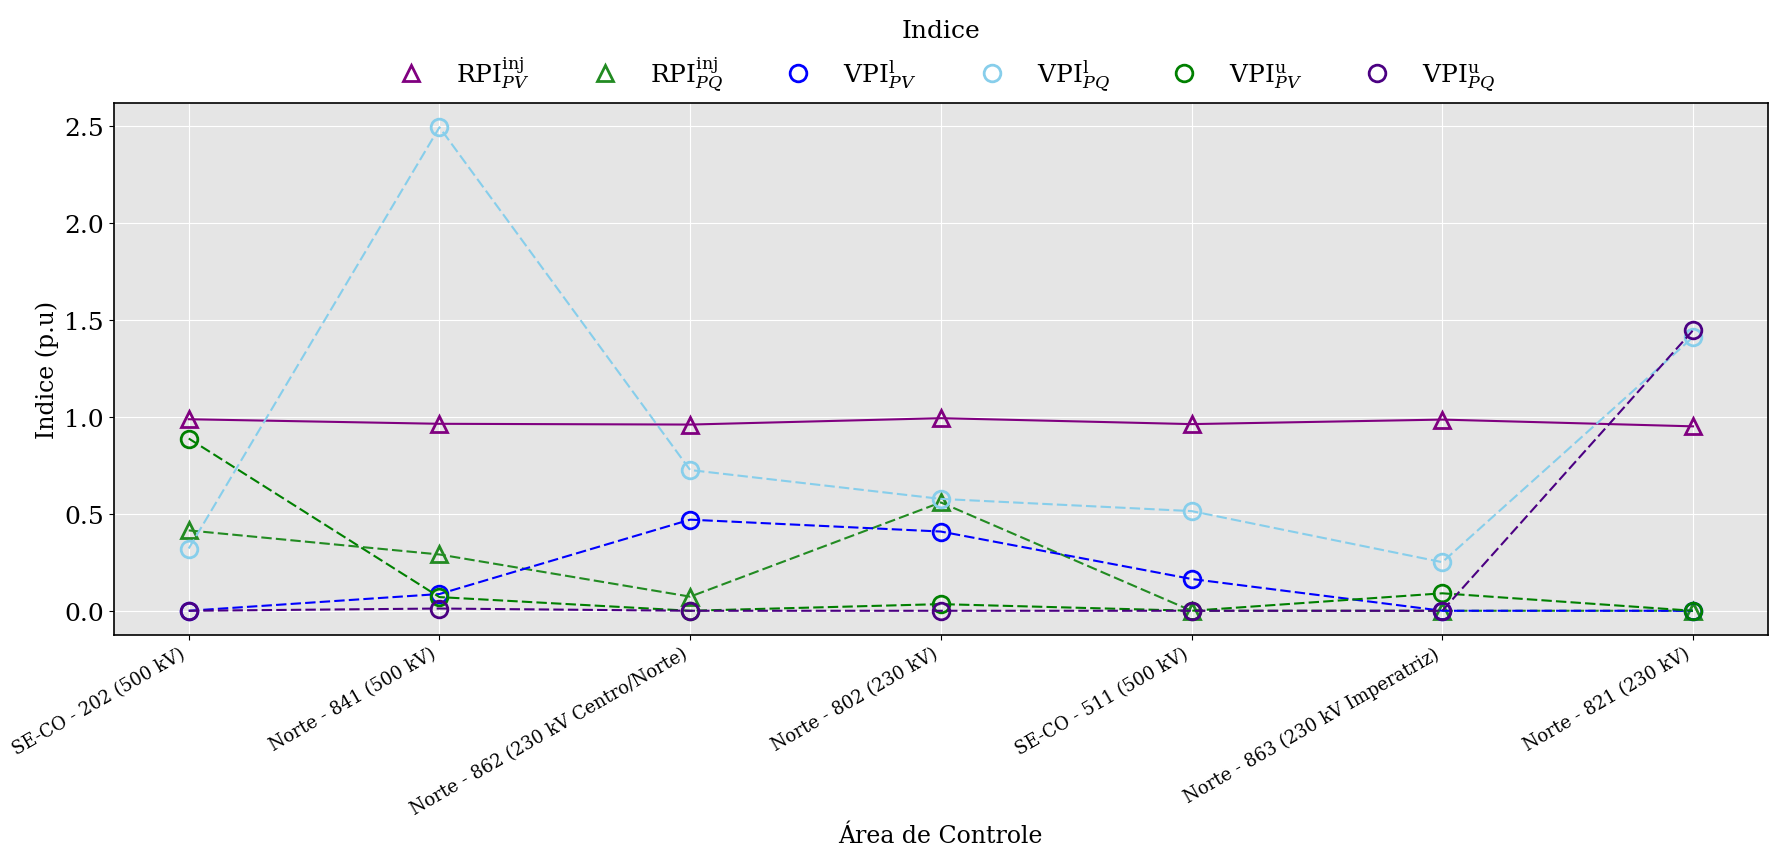

In [285]:
if Analise_INDICE:

    SelectedIndexVPI = 'RPI_ind_PV'
    indicesplot = ['RPI_ind_PV', 'RPI_ind_PQ', 'IndiceInf_s1_PV', 'IndiceInf_s1_PQ']#,'RPI_ind_PQ'
    df_area_critica = DFindicesmerged.loc[(DFindicesmerged['RPI_ind_PV'] >=0.8) & (DFindicesmerged['IndiceSup_s1_PQ'] <=0.2)]
    df_area_critica['ARE_count'] = df_area_critica.groupby(level='ARE').transform('count')['RPI_ind_PV']
    SindexAreas = df_area_critica.reset_index().sort_values('ARE_count', ascending=False)
    Largestareas = SindexAreas.groupby('ARE')[['ARE_count']].first().nlargest(10, 'ARE_count').reset_index()
    SindexAreas = SindexAreas[SindexAreas['ARE'].isin(Largestareas['ARE'].tolist())]
    SindexAreas['Nome Area'] = SindexAreas['REG'].astype(str) + ' - ' + SindexAreas['ARE'].astype(str) + ' (' + SindexAreas['Nome da Area'] +')'
    lineplotIndex_mod_01(SindexAreas, ['Nome Area'], indicesplot ,f'Highest average index for each control area (PV Buses) - {Region}- {SelectedIndexVPI}', SelectedIndexVPI)

    SelectedIndexVPI = 'RPI_ind_PV'
    indicesplot = ['RPI_ind_PV', 'RPI_ind_PQ', 'IndiceSup_s1_PV', 'IndiceSup_s1_PQ','IndiceInf_s1_PV', 'IndiceInf_s1_PQ']#,'RPI_ind_PQ'
    df_area_critica = DFindicesmerged.loc[(DFindicesmerged['RPI_ind_PV'] >=0.8) & (DFindicesmerged['IndiceSup_s1_PQ'] >0.2)]#, 'RPI_ind_PQ', 'IndiceSup_s1_PV', 'IndiceSup_s1_PQ','IndiceInf_s1_PV', 'IndiceInf_s1_PQ'
    df_area_critica['ARE_count'] = df_area_critica.groupby(level='ARE').transform('count')['RPI_ind_PV']
    SindexAreas = df_area_critica.reset_index().sort_values('ARE_count', ascending=False)
    Largestareas = SindexAreas.groupby('ARE')[['ARE_count']].first().nlargest(10, 'ARE_count').reset_index()
    SindexAreas = SindexAreas[SindexAreas['ARE'].isin(Largestareas['ARE'].tolist())]
    SindexAreas['Nome Area'] = SindexAreas['REG'].astype(str) + ' - ' + SindexAreas['ARE'].astype(str) + ' (' + SindexAreas['Nome da Area'] +')'
    lineplotIndex_mod_01(SindexAreas, ['Nome Area'], indicesplot ,f'Highest average index for each control area (PV Buses) - {Region}- {SelectedIndexVPI}', SelectedIndexVPI)

    # dffmergedcritical = SindexAreas.merge(DF_complete_PO, on=['key', 'Cenario'], how='left')
    # scatterplot_1(dffmergedcritical[], 'PL_MW', 'PG_FERV', xlbl=f'PL_MW', ylbl = f'PG_FERV',lbl_bar= 'Area',v3 = 'Nome Area', vline=False, hline=False , title='', show_outliers=False)


    SelectedIndexVPI = 'RPI_cap_PV'
    indicesplot = ['RPI_cap_PV', 'RPI_cap_PQ', 'IndiceSup_s1_PV', 'IndiceSup_s1_PQ']#'RPI_cap_PQ', 'IndiceInf_s1_PV', 'IndiceInf_s1_PQ','IndiceSup_s1_PV', 'IndiceSup_s1_PQ'
    df_area_critica = DFindicesmerged.loc[(DFindicesmerged['RPI_cap_PV'] >=0.8) & (DFindicesmerged['IndiceInf_s1_PQ'] <=0.2)]
    df_area_critica['ARE_count'] = df_area_critica.groupby(level='ARE').transform('count')['RPI_cap_PV']
    SindexAreas = df_area_critica.reset_index().sort_values('ARE_count', ascending=False)
    Largestareas = SindexAreas.groupby('ARE')[['ARE_count']].first().nlargest(10, 'ARE_count').reset_index()
    SindexAreas = SindexAreas[SindexAreas['ARE'].isin(Largestareas['ARE'].tolist())]
    SindexAreas['Nome Area'] = SindexAreas['REG'].astype(str) + ' - ' + SindexAreas['ARE'].astype(str) + ' (' + SindexAreas['Nome da Area'] +')'
    lineplotIndex_mod_01(SindexAreas, ['Nome Area'], indicesplot ,f'Highest average index for each control area (PV Buses) - {SelectedIndexVPI}', SelectedIndexVPI)

    SelectedIndexVPI = 'RPI_cap_PV'
    indicesplot = ['RPI_cap_PV', 'RPI_cap_PQ', 'IndiceInf_s1_PV', 'IndiceInf_s1_PQ','IndiceSup_s1_PV', 'IndiceSup_s1_PQ']#'RPI_cap_PQ', 'IndiceInf_s1_PV', 'IndiceInf_s1_PQ','IndiceSup_s1_PV', 'IndiceSup_s1_PQ'
    df_area_critica = DFindicesmerged.loc[(DFindicesmerged['RPI_cap_PV'] >=0.8) & (DFindicesmerged['IndiceInf_s1_PQ'] >0.2)]# ,'IndiceInf_s1_PQ'
    df_area_critica['ARE_count'] = df_area_critica.groupby(level='ARE').transform('count')['RPI_cap_PV']
    SindexAreas = df_area_critica.reset_index().sort_values('ARE_count', ascending=False)
    Largestareas = SindexAreas.groupby('ARE')[['ARE_count']].first().nlargest(10, 'ARE_count').reset_index()
    SindexAreas = SindexAreas[SindexAreas['ARE'].isin(Largestareas['ARE'].tolist())]
    SindexAreas['Nome Area'] = SindexAreas['REG'].astype(str) + ' - ' + SindexAreas['ARE'].astype(str) + ' (' + SindexAreas['Nome da Area'] +')'
    lineplotIndex_mod_01(SindexAreas, ['Nome Area'], indicesplot ,f'Highest average index for each control area (PV Buses) - {SelectedIndexVPI}', SelectedIndexVPI)

    # dffmergedcritical = SindexAreas.merge(DF_complete_PO, on=['key', 'Cenario'], how='left')
    # scatterplot_1(dffmergedcritical, 'PL_MW', 'PG_FERV', xlbl=f'PL_MW', ylbl = f'PG_FERV',lbl_bar= 'Area',v3 = 'Nome Area', vline=False, hline=False , title='', show_outliers=False)



In [104]:
# dffmergedcritical = SindexAreas.merge(DF_complete_PO, on=['key', 'Cenario'], how='left')
# scatterplot_1(dffmergedcritical[dffmergedcritical['ARE']==841], 'PL_MW', 'PG_FERV', xlbl=f'PL_MW', ylbl = f'PG_FERV',lbl_bar= 'Area',v3 = 'Nome Area', vline=False, hline=False , title='', show_outliers=False)

In [143]:
if Analise_INDICE:
    SelectedIndexVPI = 'RPI_ind_PV'
    indicesplot = ['RPI_ind_PV', 'RPI_ind_PQ', 'IndiceSup_s1_PV', 'IndiceSup_s1_PQ','IndiceInf_s1_PV', 'IndiceInf_s1_PQ']#,'RPI_ind_PQ'
    df_area_critica = DFindicesmerged.loc[(DFindicesmerged['RPI_ind_PV'] >=0.8) & (DFindicesmerged['IndiceSup_s1_PQ'] <=0.2)]
    df_area_critica['ARE_count'] = df_area_critica.groupby(level='ARE').transform('count')['RPI_ind_PV']
    SindexAreas = df_area_critica.reset_index().sort_values('ARE_count', ascending=False)
    Largestareas = SindexAreas.groupby('ARE')[['ARE_count']].first().reset_index()
    SindexAreas = SindexAreas[SindexAreas['ARE'].isin(Largestareas['ARE'].tolist())]
    SindexAreas['Nome Area'] = SindexAreas['REG'].astype(str) + ' - ' + SindexAreas['ARE'].astype(str) + ' - ' + SindexAreas['Nome da Area']

C:\Users\david\AppData\Local\Temp\ipykernel_28940\4279173476.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_area_critica['ARE_count'] = df_area_critica.groupby(level='ARE').transform('count')['RPI_ind_PV']


In [164]:
area_ge = 'Sul'
display(len(set(SindexAreas[SindexAreas['REG']==area_ge].reset_index()[['key', 'Cenario']].apply(tuple, axis=1)))/len(set(df_PV_indices_reg.reset_index()[['key', 'Cenario']].apply(tuple, axis=1)))*100)
display(SindexAreas[SindexAreas['REG']==area_ge]['Nome Area'].unique().shape[0])

35.39400877695096

6

In [154]:
if Analise_INDICE:
    display(SindexAreas.groupby(['REG','Nome Area' ]).agg({'key':'count'}).shape)
    display(SindexAreas.groupby(['REG','Nome Area' ]).agg({'key':'count'}))
    display(len(set(SindexAreas[['key','Cenario']].apply(tuple,axis=1).values)))

(30, 1)

key
REG      Nome Area                                 
AC-RO    AC-RO - 452 - 230 kV                  8444
Nordeste Nordeste - 711 - 500 kV                  3
         Nordeste - 721 - 500 kV                 11
         Nordeste - 771 - 500 kV                150
         Nordeste - 772 - 230 kV                 14
Norte    Norte - 841 - 500 kV                  3834
         Norte - 843 - 230 kV Norte            1407
         Norte - 844 - 230 kV Sul             12836
         Norte - 861 - 500 kV                  4757
         Norte - 862 - 230 kV Centro/Norte     3445
         Norte - 863 - 230 kV Imperatriz       8212
SE-CO    SE-CO - 201 - 765 kV SP+PR            4984
         SE-CO - 202 - 500 kV                  2752
         SE-CO - 203 - 440 kV                    74
         SE-CO - 204 - 345 kV                  1910
         SE-CO - 252 - 345 kV                   565
         SE-CO - 302 - 345 kV                   784
         SE-CO - 351 - 500 kV                   619
         SE-CO - 352 - 345 kV                    10
         SE-CO - 404 - Autoprodutores 230 kV   9500
         SE-CO - 471 - 500 kV                   826
         SE-CO - 511 - 500 kV                   254
         SE-CO - 512 - 345 kV                  3375
         SE-CO - 513 - 230 kV                    73
Sul      Sul - 1 - 525 kV                       177
         Sul - 101 - 525 kV                    3068
         Sul - 102 - 230 kV                      46
         Sul - 2 - 230 kV                         9
         Sul - 51 - 525 kV                     2756
         Sul - 52 - 230 kV                      152

15714

In [107]:
if Analise_INDICE:
    # Merge and group for features
    def get_features(df_merged, area_list, reg, group_cols, Flag):
        if Flag == 'PV':
            return df_merged[df_merged['ARE'].isin(area_list)].groupby(group_cols).agg({
                'BUS_NAME': 'first',
                'MODV_PU': 'mean',
                'IndiceInf': 'mean',
                'IndiceSup': 'mean',
                'ReservaIND': 'mean',
                'ReservaCAP': 'mean',
            }).reset_index()
        elif  Flag == 'PQ':
            return df_merged[df_merged['ARE'].isin(area_list)].groupby(group_cols).agg({
                'BUS_NAME': 'first',
                'MODV_PU': 'mean',
                'IndiceInf': 'mean',
                'IndiceSup': 'mean',
                'ReservaINDshunt': 'mean',
                'ReservaCAPshunt': 'mean',
            }).reset_index()

    # Get features for different conditions
    
    dfaux_PV = df_filt_ger.merge(df_PV_indices_reg, on=['key', 'Cenario', 'REG', 'ARE'], how='inner')
    dfaux_PQ = df_filt_nt.merge(df_PQ_indices_reg, on=['key', 'Cenario', 'REG','ARE'], how='inner')


    # dfeatures_pv_inf = get_features(dfaux_PV, listadeareas_inf_pv, Region, ['BUS_ID'], 'PV')
    # dfeatures_pv_sup = get_features(dfaux_PV, listadeareas_sup_pv, Region, ['BUS_ID'], 'PV')
    # dfeatures_pv_ind = get_features(dfaux_PV, listadeareas_ind_pv, Region, ['BUS_ID'], 'PV')
    # dfeatures_pv_cap = get_features(dfaux_PV, listadeareas_cap_pv, Region, ['BUS_ID'], 'PV')

    # dfeatures_pq_inf = get_features(dfaux_PQ, listadeareas_inf_pq, Region, ['BUS_ID'], 'PQ')
    # dfeatures_pq_sup = get_features(dfaux_PQ, listadeareas_sup_pq, Region, ['BUS_ID'], 'PQ')
    # dfeatures_pq_ind = get_features(dfaux_PQ, listadeareas_ind_pq, Region, ['BUS_ID'], 'PQ')
    # dfeatures_pq_cap = get_features(dfaux_PQ, listadeareas_cap_pq, Region, ['BUS_ID'], 'PQ')

    # Select top n_barras features  
    # features_inf_pv = dfeatures_pv_inf.nlargest(n_barras, 'IndiceInf')
    # features_sup_pv = dfeatures_pv_sup.nlargest(n_barras, 'IndiceSup') 
    # features_inf_pq = dfeatures_pq_inf.nlargest(n_barras, 'IndiceInf')
    # features_sup_pq = dfeatures_pq_sup.nlargest(n_barras, 'IndiceSup')

    # features_ind_pv = dfeatures_pv_ind.nlargest(n_barras, 'ReservaIND')
    # features_cap_pv = dfeatures_pv_cap.nlargest(n_barras, 'ReservaCAP') 
    # features_ind_pq = dfeatures_pq_ind.nlargest(n_barras, 'ReservaINDshunt')
    # features_cap_pq = dfeatures_pq_cap.nlargest(n_barras, 'ReservaCAPshunt')

    
    dfaux_PV = dfaux_PV.set_index(['key', 'Cenario', 'BUS_NAME'])
    dfaux_PQ = dfaux_PQ.set_index(['key', 'Cenario', 'BUS_NAME'])

C:\Users\david\AppData\Local\Temp\ipykernel_28940\245754495.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_area_critica['ARE_count'] = df_area_critica.groupby(level='ARE').transform('count')['RPI_ind_PV']


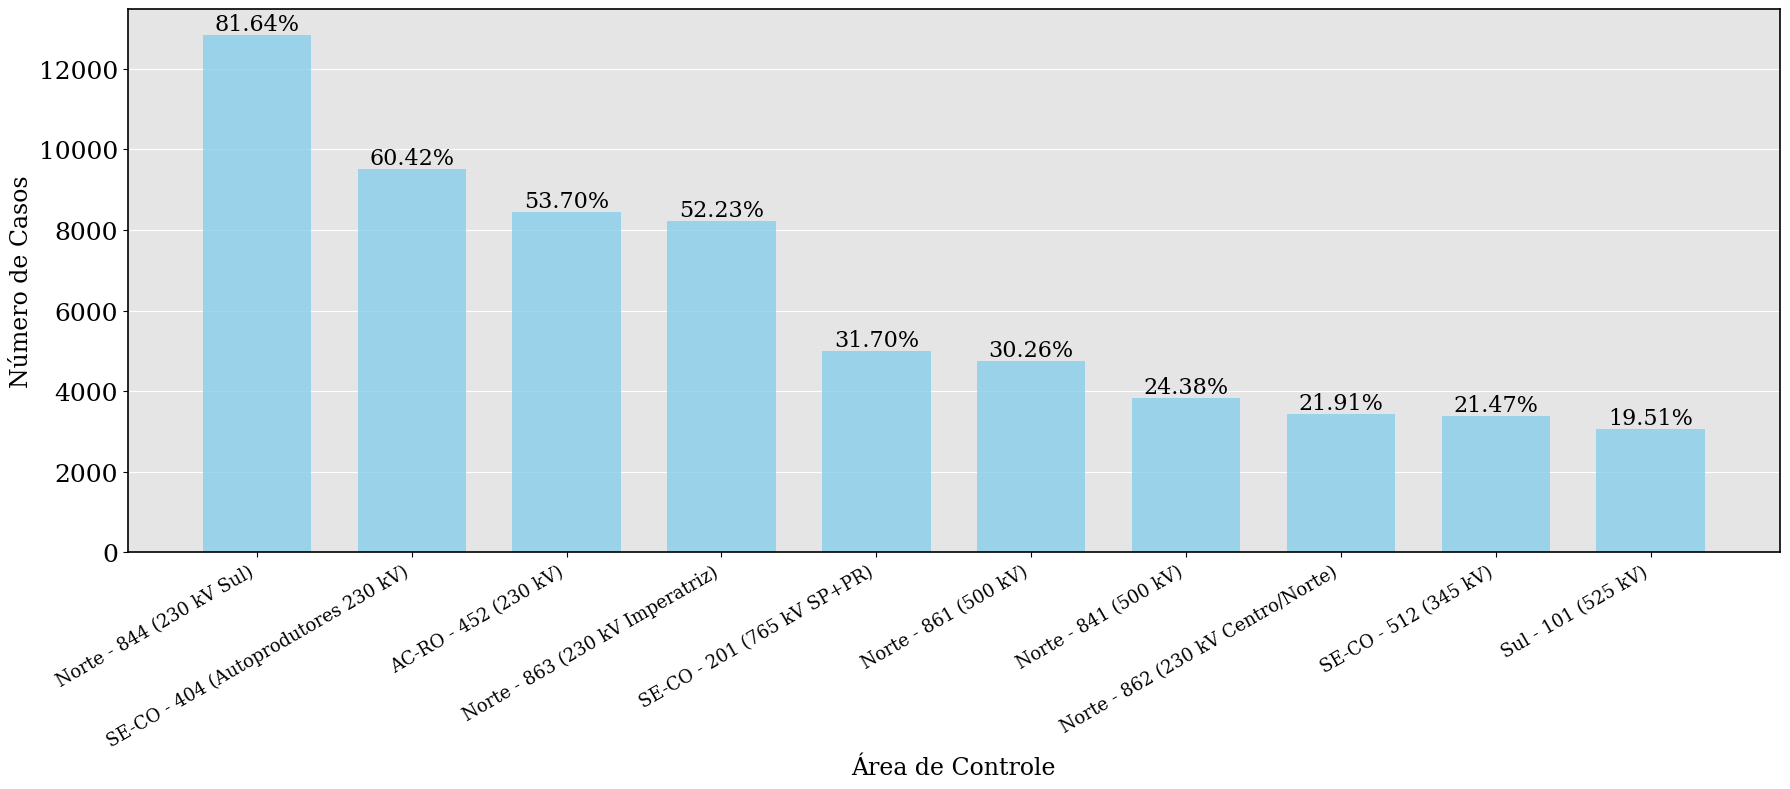

C:\Users\david\AppData\Local\Temp\ipykernel_28940\2126073034.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")


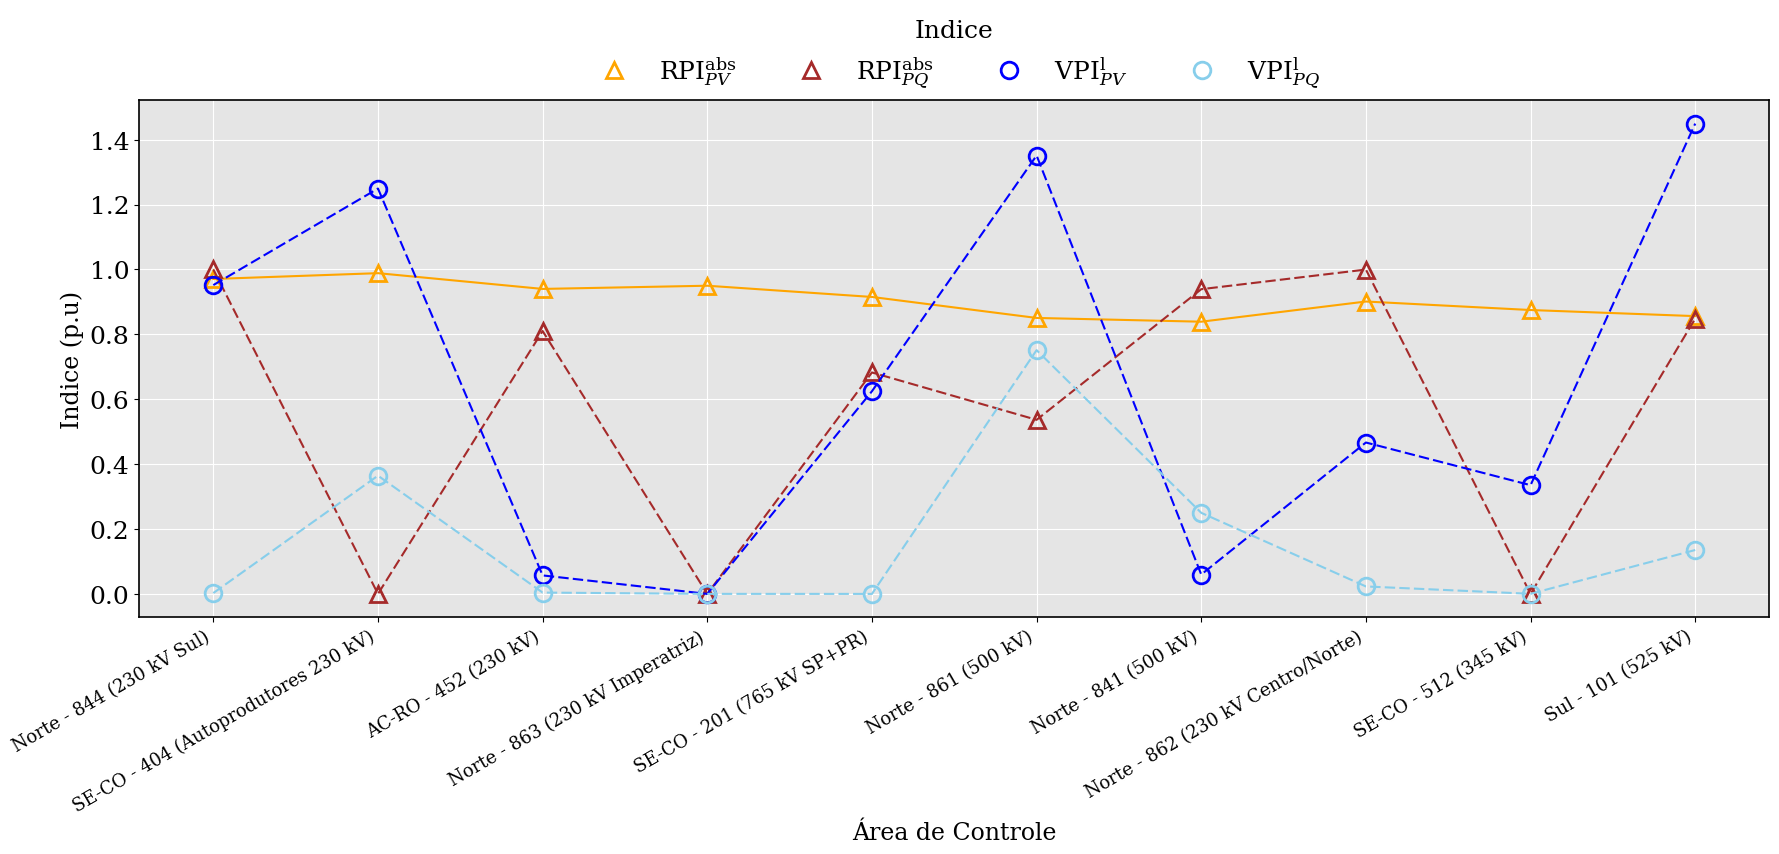

In [224]:
if Analise_INDICE:

    SelectedIndexVPI = 'RPI_ind_PV'
    indicesplot = ['RPI_ind_PV', 'RPI_ind_PQ', 'IndiceInf_s1_PV', 'IndiceInf_s1_PQ']#,'RPI_ind_PQ'
    df_area_critica = DFindicesmerged.loc[(DFindicesmerged['RPI_ind_PV'] >=0.8) & (DFindicesmerged['IndiceSup_s1_PQ'] <=0.2)]
    df_area_critica['ARE_count'] = df_area_critica.groupby(level='ARE').transform('count')['RPI_ind_PV']
    SindexAreas = df_area_critica.reset_index().sort_values('ARE_count', ascending=False)
    Largestareas = SindexAreas.groupby('ARE')[['ARE_count']].first().nlargest(10, 'ARE_count').reset_index()
    SindexAreas = SindexAreas[SindexAreas['ARE'].isin(Largestareas['ARE'].tolist())]
    SindexAreas['Nome Area'] = SindexAreas['REG'].astype(str) + ' - ' + SindexAreas['ARE'].astype(str) + ' (' + SindexAreas['Nome da Area'] +')'
    lineplotIndex_mod_01(SindexAreas, ['Nome Area'], indicesplot ,f'Highest average index for each control area (PV Buses) - {Region}- {SelectedIndexVPI}', SelectedIndexVPI)

In [225]:
# HVDCdata = pd.read_csv('C:/Users/david/OneDrive/Documents/FERV_documentos/HVDC_data.csv')
# Df_data_completo_reg['P_sync'] = Df_data_completo_reg['PG_UHE'] + Df_data_completo_reg['PG_UTE'] + Df_data_completo_reg['PG_BIO']
# Df_data_completo_reg['P_inv'] = Df_data_completo_reg['PG_EOL'] + Df_data_completo_reg['PG_SOL']
# dd = Df_data_completo_reg.loc[:,:,'SE-CO',:].merge(HVDCdata[HVDCdata['Intercambio']=='XINGU-SE-CW HVDC Link'], on=['key','Cenario'])
# filtro = dd[['key', 'Cenario']].apply(tuple,axis=1).isin(SindexAreas[SindexAreas['ARE']==201][['key', 'Cenario']].apply(tuple,axis=1))
# dd.loc[~filtro,'flag'] = 'Normal'
# dd.loc[filtro,'flag'] = 'Critico'
# dd = dd.sort_values('flag')
# display(dd.value_counts('flag'))
# dflin = linhasdata.groupby(['key','Cenario','REG'])[['Mvar:Losses']].sum()
# dd = dd.merge(dflin.loc[:,:,'Sudeste-Centro-Oeste'], on=['key','Cenario'], how='left')
# scatterplot_1(dd, 'P_inv', 'Mvar:Losses', xlbl=f'', ylbl = f'',lbl_bar= 'flag',v3 = 'flag', vline=False, hline=False , title='', show_outliers=False)
# scatterplot_1(dd, 'P_sync', 'P_inv', xlbl=f'', ylbl = f'',lbl_bar= 'flag',v3 = 'flag', vline=False, hline=False , title='', show_outliers=False)

In [257]:
if Analise_INDICE:
    Region = 'Norte'
    dfaux_PV_filt = dfaux_PV.reset_index().merge(df_area_critica[['ARE_count']], on =['key','Cenario','ARE',], how='inner')
    dfaux_PQ_filt = dfaux_PQ.reset_index().merge(df_area_critica[['ARE_count']], on =['key','Cenario','ARE'], how='inner')

In [288]:
if Analise_INDICE:
    area = 844
    dfeatures_pv = get_features(dfaux_PV_filt, [area], Region, ['BUS_ID'], 'PV')
    dfeatures_pq = get_features(dfaux_PQ_filt, [area], Region, ['BUS_ID'], 'PQ')

    dfaux_mergedBUS_filt = dfaux_PV_filt[['MODV_PU','IndiceInf', 'IndiceSup','BUS_ID', 'BUS_NAME', 'ReservaIND', 'ReservaCAP','key', 'Cenario','ARE']].merge(dfaux_PQ_filt[['MODV_PU','IndiceInf', 'IndiceSup','BUS_ID', 'BUS_NAME', 'ReservaINDshunt', 'ReservaCAPshunt','key', 'Cenario','ARE',]], on=['key', 'Cenario' ,'BUS_ID', 'BUS_NAME','ARE'], how='outer', suffixes=['_PV',  '_PQ'] )
    dfBUS_filt = dfeatures_pv.merge(dfeatures_pq[['MODV_PU','IndiceInf', 'IndiceSup','BUS_ID', 'BUS_NAME', 'ReservaINDshunt', 'ReservaCAPshunt']], on=['BUS_ID', 'BUS_NAME'], how='outer', suffixes=['_PV',  '_PQ'] )

C:\Users\david\AppData\Local\Temp\ipykernel_28940\1632370313.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SindexAreas['BUS_NAME'] = pd.Categorical(SindexAreas['BUS_NAME'], categories=features_inf_pv['BUS_NAME'].tolist(), ordered=True)
C:\Users\david\AppData\Local\Temp\ipykernel_28940\3429543084.py:226: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")


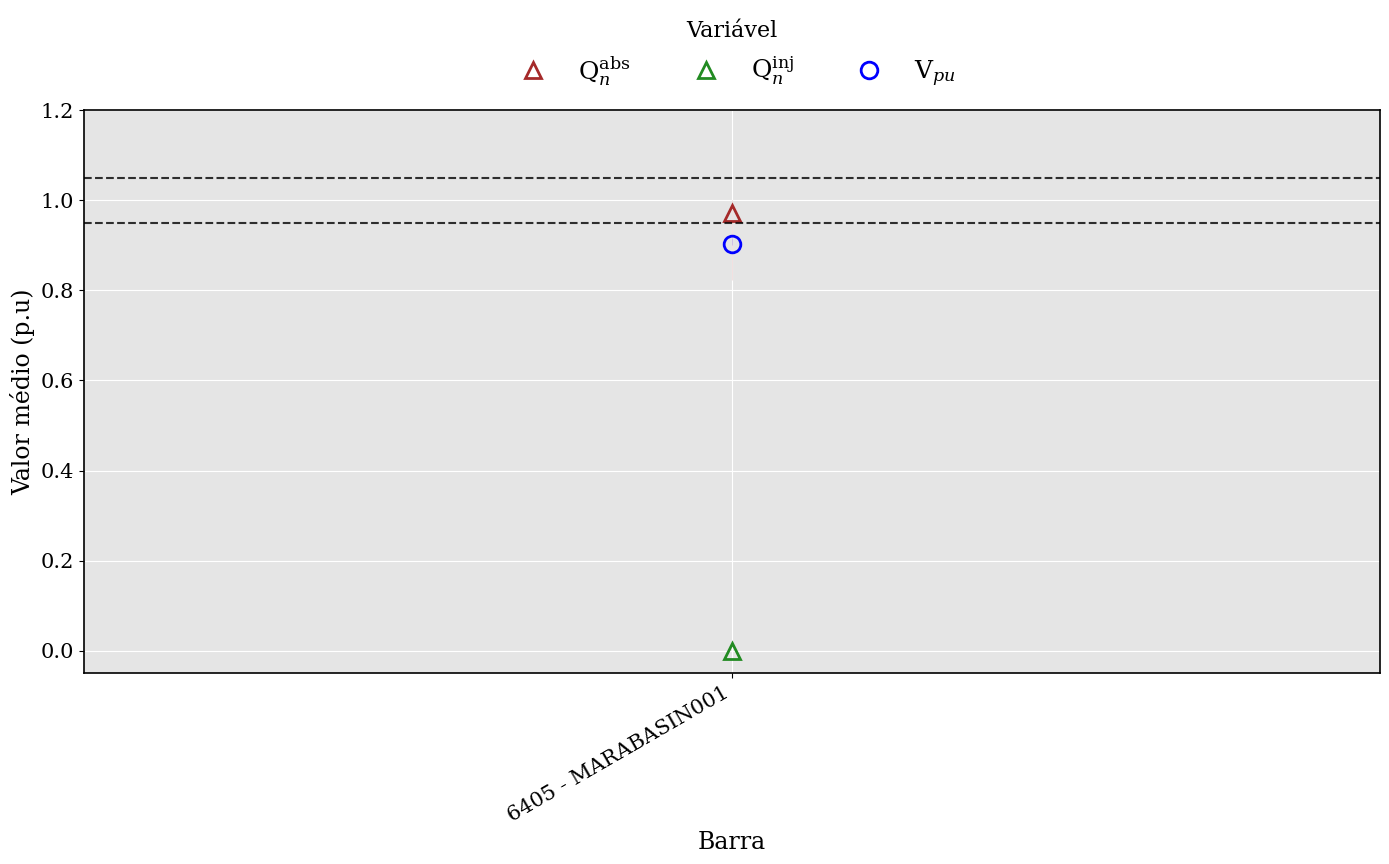

C:\Users\david\AppData\Local\Temp\ipykernel_28940\1632370313.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SindexAreas['BUS_NAME'] = pd.Categorical(SindexAreas['BUS_NAME'], categories=features_inf_pv['BUS_NAME'].tolist(), ordered=True)
C:\Users\david\AppData\Local\Temp\ipykernel_28940\3429543084.py:226: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")


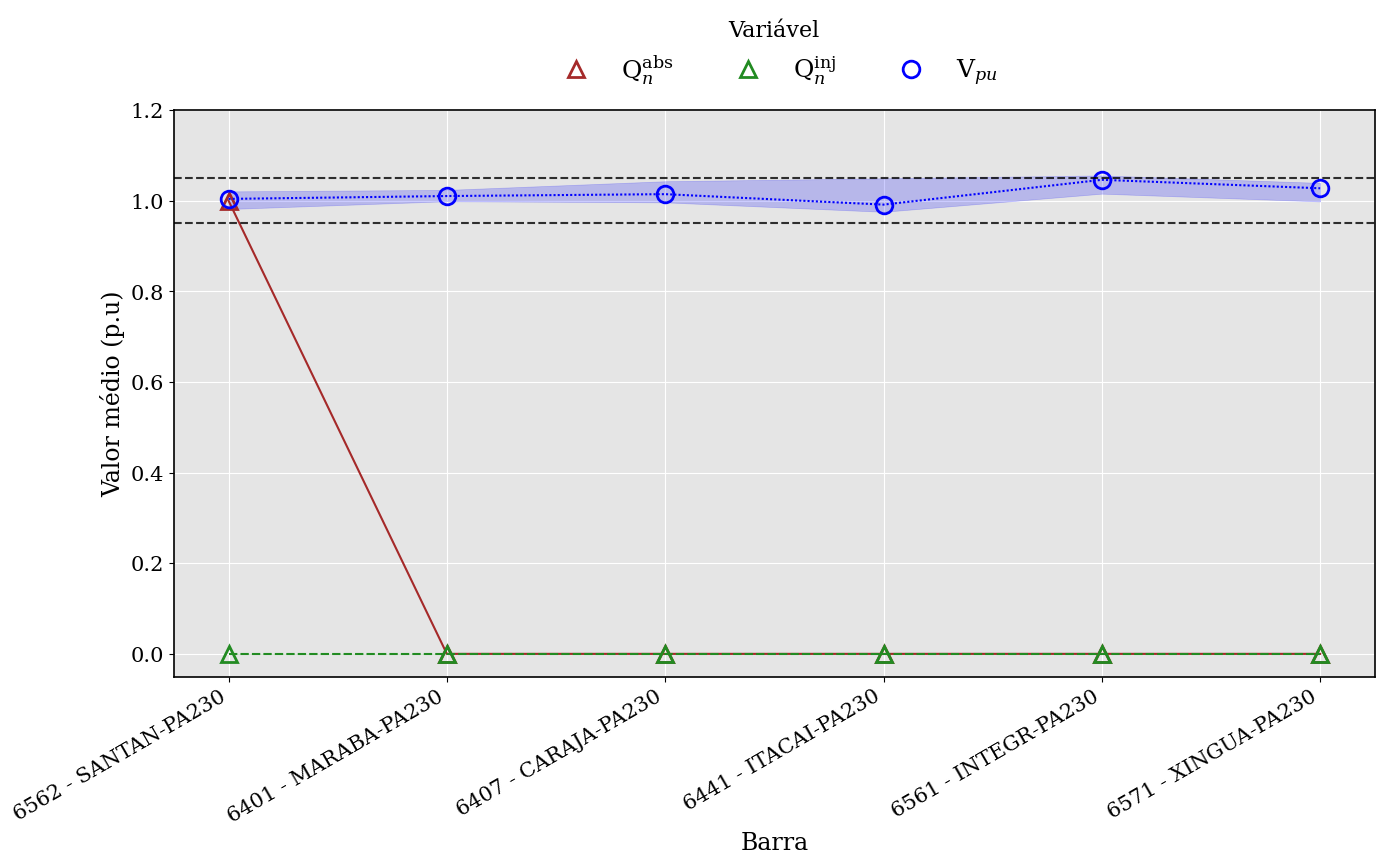

In [296]:
if Analise_INDICE:

    SelectedIndex = ['ReservaIND']
    indicesplot = ['ReservaIND','ReservaCAP', 'MODV_PU_PV']#'IndiceInf_PV','IndiceInf_PQ','IndiceSup_PQ','ReservaINDshunt', 'ReservaCAPshunt',

    # features_inf_pv = dfBUS_filt[(dfBUS_filt[['ReservaIND','ReservaCAP','IndiceInf_PV', 'IndiceSup_PV']]>0.1).any(axis=1)].sort_values(SelectedIndex, ascending = False)
    features_inf_pv = dfBUS_filt.sort_values(SelectedIndex, ascending = False)
    SindexAreas = dfaux_mergedBUS_filt[dfaux_mergedBUS_filt['BUS_NAME'].isin(features_inf_pv['BUS_NAME'].tolist())]
    SindexAreas['BUS_NAME'] = pd.Categorical(SindexAreas['BUS_NAME'], categories=features_inf_pv['BUS_NAME'].tolist(), ordered=True)
    SindexAreas = SindexAreas.sort_values('BUS_NAME')
    SindexAreas['BUS_ID'].astype(int)
    SindexAreas['BUS_ID'] = SindexAreas['BUS_ID'].astype(int)
    SindexAreas['Nome BUS'] = SindexAreas['BUS_ID'].astype(str) + ' - ' + SindexAreas['BUS_NAME'].astype(str)
    lineplotIndex_bus(SindexAreas, ['Nome BUS'], indicesplot, f'Highest average index for (PV Buses) - {Region} - {SelectedIndex}', SelectedIndex, type='PV')

    # display(features_inf_pv) 

    SelectedIndex = ['ReservaINDshunt']
    indicesplot = ['ReservaINDshunt', 'ReservaCAPshunt', 'MODV_PU_PQ']#'IndiceInf_PV','IndiceInf_PQ','IndiceSup_PQ','ReservaINDshunt', 'ReservaCAPshunt',

    # features_inf_pv = dfBUS_filt[(dfBUS_filt[['ReservaINDshunt', 'ReservaCAPshunt','IndiceInf_PQ', 'IndiceSup_PQ']]>0.1).any(axis=1)].sort_values(SelectedIndex, ascending = False)
    features_inf_pv = dfBUS_filt.sort_values(SelectedIndex, ascending = False)
    SindexAreas = dfaux_mergedBUS_filt[dfaux_mergedBUS_filt['BUS_NAME'].isin(features_inf_pv['BUS_NAME'].tolist())]
    SindexAreas['BUS_NAME'] = pd.Categorical(SindexAreas['BUS_NAME'], categories=features_inf_pv['BUS_NAME'].tolist(), ordered=True)
    SindexAreas = SindexAreas.sort_values('BUS_NAME')
    SindexAreas['BUS_ID'] = SindexAreas['BUS_ID'].astype(int)
    SindexAreas['Nome BUS'] = SindexAreas['BUS_ID'].astype(str) + ' - ' + SindexAreas['BUS_NAME'].astype(str)
    lineplotIndex_bus(SindexAreas, ['Nome BUS'], indicesplot, f'Highest average index for (PV Buses) - {Region} - {SelectedIndex}', SelectedIndex, type='PQ')

    # display(features_inf_pv) 

In [273]:
SindexAreas[(SindexAreas['BUS_NAME']=='MARABASIN001') & (SindexAreas['MODV_PU_PV']<0.92)]

,MODV_PU_PV,IndiceInf_PV,IndiceSup_PV,BUS_ID,BUS_NAME,ReservaIND,ReservaCAP,key,Cenario,ARE,MODV_PU_PQ,IndiceInf_PQ,IndiceSup_PQ,ReservaINDshunt,ReservaCAPshunt,Nome BUS
45,0.903847,0.92306,0.0,6405.0,MARABASIN001,0.9801,0.0,D_10_H_00-00,V1A1F2,844,NaN,NaN,NaN,NaN,NaN,844 - MARABASIN001
596924,0.901837,0.96326,0.0,6405.0,MARABASIN001,0.8608,0.0,D_26_H_05-00,V2A2F4,844,NaN,NaN,NaN,NaN,NaN,844 - MARABASIN001
596991,0.900641,0.98718,0.0,6405.0,MARABASIN001,0.8260,0.0,D_26_H_05-00,V2A2F5,844,NaN,NaN,NaN,NaN,NaN,844 - MARABASIN001
597059,0.900655,0.98690,0.0,6405.0,MARABASIN001,0.8848,0.0,D_26_H_05-00,V3A3F2,844,NaN,NaN,NaN,NaN,NaN,844 - MARABASIN001
597184,0.900566,0.98868,0.0,6405.0,MARABASIN001,0.8567,0.0,D_26_H_05-00,V3A3F3,844,NaN,NaN,NaN,NaN,NaN,844 - MARABASIN001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305602,0.900000,1.00000,0.0,6405.0,MARABASIN001,0.9926,0.0,D_18_H_12-00,V3A3F3,844,NaN,NaN,NaN,NaN,NaN,844 - MARABASIN001
305644,0.900000,1.00000,0.0,6405.0,MARABASIN001,0.9975,0.0,D_18_H_12-00,V3A3F4,844,NaN,NaN,NaN,NaN,NaN,844 - MARABASIN001
305690,0.900000,1.00000,0.0,6405.0,MARABASIN001,1.0000,0.0,D_18_H_12-00,V3A3F5,844,NaN,NaN,NaN,NaN,NaN,844 - MARABASIN001
305031,0.900002,0.99996,0.0,6405.0,MARABASIN001,0.9933,0.0,D_18_H_12-00,V1A1F3,844,NaN,NaN,NaN,NaN,NaN,844 - MARABASIN001


In [230]:
# dfaux_PQ_filt[dfaux_PQ_filt['BUS_NAME']=='ARARQ2-SP500'][['B0_MVAR','ST', 'SHUNT_INST_IND', 'SHUNT_INST_CAP',]].mean()

In [231]:
# dfeatures_pq = get_features(dfaux_PQ_filt, [202], Region, ['BUS_ID'], 'PQ')

# dff = dfaux_PQ_filt[(dfaux_PQ_filt['BUS_ID'].isin(dfeatures_pq['BUS_ID'].values)) & (dfaux_PQ_filt['BUS_NAME']!='ARARQ2-SP500')]
# dff.groupby('BUS_ID').agg({'BUS_NAME':'first','B0_MVAR':'mean'})['B0_MVAR'].sum()

In [232]:
# dfeatures_pq = get_features(dfaux_PQ_filt, [202], Region, ['BUS_ID'], 'PQ')
# df_filt_nt[df_filt_nt['BUS_ID'].isin(dfeatures_pq['BUS_ID'].values) & (df_filt_nt['key']=='D_1_H_13-00')  & (df_filt_nt['Cenario']=='V1A1F2') & (df_filt_nt['ST']>0)][['BUS_NAME','B0_MVAR','ST', 'SHUNT_INST_IND', 'SHUNT_INST_CAP', 'ReservaINDshunt','ReservaCAPshunt']]

In [233]:
# df_filt_ger[df_filt_ger['key']=='D_16_H_04-00'][['SHUNT_INST_IND', 'SHUNT_INST_CAP']].sum()

In [234]:
# df_filt_nt[df_filt_nt['key']=='D_16_H_04-00'][['SHUNT_INST_IND', 'SHUNT_INST_CAP']].sum()

In [235]:
if Analise_INDICE:
    for are in dfaux_PV_filt['ARE'].unique():
        print('Area ', are)

        dfeatures_pv = get_features(dfaux_PV_filt, [are], Region, ['BUS_ID'], 'PV')
        SHUNTINST = df_filt_ger[df_filt_ger['BUS_ID'].isin(dfeatures_pv['BUS_ID'].values) & (df_filt_ger['key']=='D_1_H_13-00')  & (df_filt_ger['Cenario']=='V1A1F2')]

        print(f" Numero de Barras PV: {dfeatures_pv.shape[0]}")
        SHUNT = dfeatures_pv[dfeatures_pv['ReservaIND']>0.0].shape[0]
        print(f" Media de Geradores Subexitados: {SHUNT}")
        # print(f"% Medio de Geradores Operando Subexitados: {( SHUNT/ SHUNTINST.shape[0])*100:.2f}%") if SHUNTINST.shape[0] > 0 else 0 
        # print('% Medio de Recurso de MVAR Usados Alocados',dfeatures_pv[dfeatures_pv['ReservaIND']>0.0]['ReservaIND'].sum()/SHUNT*100, "%")
        # print('% Medio de Recurso de MVAR Usados Instalado',dfeatures_pv[dfeatures_pv['ReservaIND']>0.0]['ReservaIND'].sum()/SHUNTINST.shape[0]*100, "%")

        SHUNT = dfeatures_pv[dfeatures_pv['ReservaCAP']>0.0].shape[0]
        print(f" Media de Geradores Sobrexitados: {SHUNT}")
        # print(f"% Medio de Geradores Operando Sobrexitados: {( SHUNT/ SHUNTINST.shape[0])*100:.2f}%") if SHUNTINST.shape[0] > 0 else 0 
        # print('% Medio de Recurso de MVAR Usados Alocados',dfeatures_pv[dfeatures_pv['ReservaCAP']>0.0]['ReservaCAP'].sum()/SHUNT*100, "%")
        # print('% Medio de Recurso de MVAR Usados Instalado',dfeatures_pv[dfeatures_pv['ReservaCAP']>0.0]['ReservaCAP'].sum()/SHUNTINST.shape[0]*100, "%")

        print('Total de Recurso MVAR indutivo disponivel:',SHUNTINST['Qmin'].sum())
        print('Total de Recurso MVAR capacitivo disponivel:',SHUNTINST['Qmax'].sum())

        NUMBUS = dfeatures_pv[dfeatures_pv['IndiceSup']>0.0].shape[0]
        print(f"Media de barramentos com violação de sobretensão: {NUMBUS}")
        print(f"% de barramentos com violação de sobretensão: {(NUMBUS / dfeatures_pv.shape[0])*100:.2f}%") if dfeatures_pv.shape[0] > 0 else 0 

        NUMBUS = dfeatures_pv[dfeatures_pv['IndiceInf']>0.0].shape[0]
        print(f"Media de barramentos com violação de sobretensão: {NUMBUS}")
        print(f"% de barramentos com violação de sobretensão: {(NUMBUS / dfeatures_pv.shape[0])*100:.2f}%") if dfeatures_pv.shape[0] > 0 else 0 
        print('****************************')
        print('****************************')

Area  452
 Numero de Barras PV: 8
 Media de Geradores Subexitados: 5
 Media de Geradores Sobrexitados: 1
Total de Recurso MVAR indutivo disponivel: -216.0
Total de Recurso MVAR capacitivo disponivel: 397.0
Media de barramentos com violação de sobretensão: 0
% de barramentos com violação de sobretensão: 0.00%
Media de barramentos com violação de sobretensão: 8
% de barramentos com violação de sobretensão: 100.00%
****************************
****************************
Area  771
 Numero de Barras PV: 18
 Media de Geradores Subexitados: 11
 Media de Geradores Sobrexitados: 0
Total de Recurso MVAR indutivo disponivel: -488.2
Total de Recurso MVAR capacitivo disponivel: 488.2
Media de barramentos com violação de sobretensão: 0
% de barramentos com violação de sobretensão: 0.00%
Media de barramentos com violação de sobretensão: 11
% de barramentos com violação de sobretensão: 61.11%
****************************
****************************
Area  711
 Numero de Barras PV: 7
 Media de Gerado

In [236]:
dfeatures_pq = get_features(dfaux_PQ_filt, [352], Region, ['BUS_ID'], 'PQ')
df_filt_nt[df_filt_nt['BUS_ID'].isin(dfeatures_pq['BUS_ID'].values) & (df_filt_nt['key']=='D_1_H_13-00')  & (df_filt_nt['Cenario']=='V1A1F2') & (df_filt_nt['SHUNT_INST_IND']<0)][['SHUNT_INST_IND', 'SHUNT_INST_CAP']]

,SHUNT_INST_IND,SHUNT_INST_CAP
23842285,-160.0,0.0
24159557,-40.0,0.0
24194393,-160.0,0.0


In [237]:
if Analise_INDICE:
    for are in dfaux_PQ_filt['ARE'].unique():
        print('Area ', are)


        dfeatures_pq = get_features(dfaux_PQ_filt, [are], Region, ['BUS_ID'], 'PQ')

        SHUNTINST = df_filt_nt[df_filt_nt['BUS_ID'].isin(dfeatures_pq['BUS_ID'].values) & (df_filt_nt['key']=='D_1_H_13-00')  & (df_filt_nt['Cenario']=='V1A1F2') & (df_filt_nt['SHUNT_INST_IND']<0)]

        NUMSHUNTINST = df_filt_nt[df_filt_nt['BUS_ID'].isin(dfeatures_pq['BUS_ID'].values) & (df_filt_nt['key']=='D_1_H_13-00')  & (df_filt_nt['Cenario']=='V1A1F2') & (df_filt_nt['ST']>0)]

        
        print(f" Numero de Barras PQ: {dfeatures_pq.shape[0]}")
        print(f" Numero de Shunts: {NUMSHUNTINST.shape[0]}")
        print(f" Numero de indutores instalados: {SHUNTINST.shape[0]}")
        SHUNT = dfeatures_pq[dfeatures_pq['ReservaINDshunt']>0.0].shape[0]
        print(f" Media de Shunt Absorvendo: {SHUNT}")
        # print(f"% Medio de Shunt Operando Subexitados: {( SHUNT/ SHUNTINST.shape[0])*100:.2f}%") if SHUNTINST.shape[0] > 0 else 0 
        # print('% Medio de Recurso de MVAR Usados Alocados',dfeatures_pq[dfeatures_pq['ReservaINDshunt']>0.0]['ReservaINDshunt'].sum()/SHUNT*100, "%")
        # print('% Medio de Recurso de MVAR Usados Instalado',dfeatures_pq[dfeatures_pq['ReservaINDshunt']>0.0]['ReservaINDshunt'].sum()/SHUNTINST.shape[0]*100, "%")
        print('Total de Recurso MVAR indutivo disponivel:',SHUNTINST['SHUNT_INST_IND'].sum())

        SHUNTINST = df_filt_nt[df_filt_nt['BUS_ID'].isin(dfeatures_pq['BUS_ID'].values) & (df_filt_nt['key']=='D_1_H_13-00')  & (df_filt_nt['Cenario']=='V1A1F2') & (df_filt_nt['SHUNT_INST_CAP']>0)]
        print(f" Numero de capacitores instalados: {SHUNTINST.shape[0]}")
        SHUNT = dfeatures_pq[dfeatures_pq['ReservaCAPshunt']>0.0].shape[0]
        print(f" Media de Shunt Fornecendo: {SHUNT}")
        # print(f"% Medio de Shunt Operando Sobrexitados: {( SHUNT/ SHUNTINST.shape[0])*100:.2f}%") if SHUNTINST.shape[0] > 0 else 0 
        # print('% Medio de Recurso de MVAR Usados Alocados',dfeatures_pq[dfeatures_pq['ReservaCAPshunt']>0.0]['ReservaCAPshunt'].sum()/SHUNT*100, "%")
        # print('% Medio de Recurso de MVAR Usados Instalado',dfeatures_pq[dfeatures_pq['ReservaCAPshunt']>0.0]['ReservaCAPshunt'].sum()/SHUNTINST.shape[0]*100, "%")

        print('Total de Recurso MVAR capacitivo disponivel:',SHUNTINST['SHUNT_INST_CAP'].sum())

        NUMBUS = dfeatures_pq[dfeatures_pq['IndiceSup']>0.0].shape[0]
        print(f"Media de barramentos com violação de sobretensão: {NUMBUS}")
        print(f"% de barramentos com violação de sobretensão: {(NUMBUS / dfeatures_pq.shape[0])*100:.2f}%") if dfeatures_pq.shape[0] > 0 else 0 

        NUMBUS = dfeatures_pq[dfeatures_pq['IndiceInf']>0.0].shape[0]
        print(f"Media de barramentos com violação de sobretensão: {NUMBUS}")
        print(f"% de barramentos com violação de sobretensão: {(NUMBUS / dfeatures_pq.shape[0])*100:.2f}%") if dfeatures_pq.shape[0] > 0 else 0 
        print('****************************')
        print('****************************')

Area  452
 Numero de Barras PQ: 12
 Numero de Shunts: 6
 Numero de indutores instalados: 6
 Media de Shunt Absorvendo: 6
Total de Recurso MVAR indutivo disponivel: -293.0
 Numero de capacitores instalados: 4
 Media de Shunt Fornecendo: 0
Total de Recurso MVAR capacitivo disponivel: 343.5
Media de barramentos com violação de sobretensão: 8
% de barramentos com violação de sobretensão: 66.67%
Media de barramentos com violação de sobretensão: 12
% de barramentos com violação de sobretensão: 100.00%
****************************
****************************
Area  772
 Numero de Barras PQ: 25
 Numero de Shunts: 5
 Numero de indutores instalados: 2
 Media de Shunt Absorvendo: 2
Total de Recurso MVAR indutivo disponivel: -65.0
 Numero de capacitores instalados: 4
 Media de Shunt Fornecendo: 0
Total de Recurso MVAR capacitivo disponivel: 206.01999
Media de barramentos com violação de sobretensão: 0
% de barramentos com violação de sobretensão: 0.00%
Media de barramentos com violação de sobreten

In [238]:
# HVDCdata = pd.read_csv('C:/Users/david/OneDrive/Documents/FERV_documentos/HVDC_data.csv')
# boxplot_(df_area_critica.loc[:,:,841].merge(HVDCdata, on =['key', 'Cenario'], how='left'),'Value', clase = "Intercambio", hue='Intercambio', titulo = 'Interligações DC', xlbl = '',ylbl ='(MW)', indice = False)

In [239]:
# SelectedIndex = 'ReservaINDshunt'
# indicesplot = ['ReservaINDshunt', 'IndiceSup', 'IndiceInf']
# # dfaux_PQ_filt = dfaux_PQ.reset_index().merge(df_area_critica[['ARE_count']], on =['key','Cenario','ARE'], how='inner')
# # dfeatures_pq = get_features(dfaux_PQ_filt, dfaux_PQ_filt['ARE'].unique(), Region, ['BUS_ID'], 'PQ')
# dfeatures_pq = get_features(dfaux_PQ_filt, [861], Region, ['BUS_ID'], 'PQ')
# features_inf_pq = dfeatures_pq[dfeatures_pq[SelectedIndex]>0.0].sort_values(SelectedIndex, ascending = False)
# SindexAreas = dfaux_PQ_filt[dfaux_PQ_filt['BUS_NAME'].isin(features_inf_pq['BUS_NAME'].tolist())]
# SindexAreas['BUS_NAME'] = pd.Categorical(SindexAreas['BUS_NAME'], categories=features_inf_pq['BUS_NAME'].tolist(), ordered=True)
# SindexAreas = SindexAreas.sort_values('BUS_NAME')
# SindexAreas['Nome BUS'] = SindexAreas['ARE'].astype(str) + ' - ' + SindexAreas['BUS_NAME'].astype(str)
# lineplotIndex_bus(SindexAreas, ['Nome BUS'], indicesplot, f'Highest average index for (PQ Buses) - {Region} - {SelectedIndex}', SelectedIndex,'PQ')

# SelectedIndex = 'IndiceSup'
# indicesplot = ['IndiceSup', 'ReservaINDshunt','ReservaCAPshunt']
# features_inf_pq = dfeatures_pq[dfeatures_pq[SelectedIndex]>0.0].sort_values(SelectedIndex, ascending = False)
# SindexAreas = dfaux_PQ_filt[dfaux_PQ_filt['BUS_NAME'].isin(features_inf_pq['BUS_NAME'].tolist())]
# SindexAreas['BUS_NAME'] = pd.Categorical(SindexAreas['BUS_NAME'], categories=features_inf_pq['BUS_NAME'].tolist(), ordered=True)
# SindexAreas = SindexAreas.sort_values('BUS_NAME')
# SindexAreas['Nome BUS'] = SindexAreas['ARE'].astype(str) + ' - ' + SindexAreas['BUS_NAME'].astype(str)
# lineplotIndex_bus(SindexAreas,['Nome BUS'], indicesplot, f'Highest average index for (PQ Buses) - {Region} - {SelectedIndex}',SelectedIndex,'PQ')

# SelectedIndex = 'ReservaCAPshunt'
# indicesplot = ['ReservaCAPshunt', 'IndiceInf', 'IndiceSup']
# dfaux_PQ_filt = dfaux_PQ.reset_index().merge(df_area_critica[['ARE_count']], on =['key','Cenario','ARE'], how='inner')
# features_inf_pq = dfeatures_pq[dfeatures_pq[SelectedIndex]>0.0].sort_values(SelectedIndex, ascending = False)
# SindexAreas = dfaux_PQ_filt[dfaux_PQ_filt['BUS_NAME'].isin(features_inf_pq['BUS_NAME'].tolist())]
# SindexAreas['BUS_NAME'] = pd.Categorical(SindexAreas['BUS_NAME'], categories=features_inf_pq['BUS_NAME'].tolist(), ordered=True)
# SindexAreas = SindexAreas.sort_values('BUS_NAME')
# SindexAreas['Nome BUS'] = SindexAreas['ARE'].astype(str) + ' - ' + SindexAreas['BUS_NAME'].astype(str)
# lineplotIndex_bus(SindexAreas, ['Nome BUS'], indicesplot, f'Highest average index for (PQ Buses) - {Region} - {SelectedIndex}', SelectedIndex, type='PQ')

# SelectedIndex = 'IndiceInf'
# indicesplot = ['IndiceInf', 'ReservaCAPshunt', 'ReservaINDshunt']
# features_inf_pq = dfeatures_pq[dfeatures_pq[SelectedIndex]>0.0].sort_values(SelectedIndex, ascending = False)
# SindexAreas = dfaux_PQ_filt[dfaux_PQ_filt['BUS_NAME'].isin(features_inf_pq['BUS_NAME'].tolist())]
# SindexAreas['BUS_NAME'] = pd.Categorical(SindexAreas['BUS_NAME'], categories=features_inf_pq['BUS_NAME'].tolist(), ordered=True)
# SindexAreas = SindexAreas.sort_values('BUS_NAME')
# SindexAreas['Nome BUS'] = SindexAreas['ARE'].astype(str) + ' - ' + SindexAreas['BUS_NAME'].astype(str)
# lineplotIndex_bus(SindexAreas,['Nome BUS'], indicesplot, f'Highest average index for (PQ Buses) - {Region} - {SelectedIndex}',SelectedIndex, type='PQ')

In [240]:
# len(set(list(df_area_critica.index.to_frame()[['key', 'Cenario']].apply(tuple, axis=1))))
# len(set(list(DFindicesmerged.index.to_frame()[['key', 'Cenario']].apply(tuple, axis=1))))

In [241]:
# df_filt_ger[df_filt_ger['BUS_NAME']=='ELDORABIO013']['Ger_Active_Units'].unique()

# AVALIACION OUTLIERS

### Parametro

In [242]:
# if Analise_INDICE:    
    
#     Region = 'AC-RO'

#     dfPV = df_PV.merge(df_area[['ARE','Nome da Area']], on='ARE', how='left')
#     dfPQ = df_PQ.merge(df_area[['ARE','Nome da Area']], on='ARE', how='left')

#     filtro_pv = dfPV[['key', 'Cenario']].apply(tuple, axis=1).isin(list(outliers2))
#     filtro_pq = dfPQ[['key', 'Cenario']].apply(tuple, axis=1).isin(list(outliers2))

#     ## Avalição Correlação só barras PV========================
#     df_PV_indices = dfPV[filtro_pv]
#     df_PV_indices = df_PV_indices.set_index(['key',  'Cenario', 'REG', GB])
#     ## Avalição Correlação só barras PQ========================
#     df_PQ_indices = dfPQ[filtro_pq]
#     df_PQ_indices = df_PQ_indices.set_index(['key',  'Cenario', 'REG', GB])

#     n_AREAS = 10
#     n_barras = 20

#     def top_n_group(df, group_cols, sort_col, n):
#         return df.groupby(group_cols).apply(lambda x: x.nlargest(n, sort_col)).reset_index(drop=True)

#     # Filter regions
#     df_PV_indices_reg = df_PV_indices.loc[:,:,Region,:]
#     df_PQ_indices_reg = df_PQ_indices.loc[:,:,Region,:]

#     # Aggregation function
#     agg_cols = {
#         'IndiceInf_s1': 'mean',
#         'IndiceSup_s1': 'mean',
#         'RPI_ind':'mean',
#         'RPI_cap':'mean',
#         'Nome da Area': 'first'
#     }

#     # Aggregate areas
#     df_pv_areas = df_PV_indices_reg.groupby(['ARE']).agg(agg_cols).reset_index()
#     df_pq_areas = df_PQ_indices_reg.groupby(['ARE']).agg(agg_cols).reset_index()

#     # Sort and select top areas
#     AREAS_inf_pv = df_pv_areas.nlargest(n_AREAS, 'IndiceInf_s1')
#     AREAS_sup_pv = df_pv_areas.nlargest(n_AREAS, 'IndiceSup_s1')
#     AREAS_inf_pq = df_pq_areas.nlargest(n_AREAS, 'IndiceInf_s1')
#     AREAS_sup_pq = df_pq_areas.nlargest(n_AREAS, 'IndiceSup_s1')

#     # Convert to lists for filtering
#     listadeareas_inf_pv = AREAS_inf_pv['ARE'].tolist()
#     listadeareas_sup_pv = AREAS_sup_pv['ARE'].tolist()
#     listadeareas_inf_pq = AREAS_inf_pq['ARE'].tolist()
#     listadeareas_sup_pq = AREAS_sup_pq['ARE'].tolist()

#     # Filter data based on indices
#     # filter_condition = lambda df: (df['IndiceInf_s1'] > 1) | (df['IndiceSup_s1'] > 1)
#     # df_PV_indices_reg_filt = df_PV_indices_reg[filter_condition(df_PV_indices_reg)]
#     # df_PQ_indices_reg_filt = df_PQ_indices_reg[filter_condition(df_PQ_indices_reg)]

#     df_PV_indices_reg_filt = df_PV_indices_reg
#     df_PQ_indices_reg_filt = df_PQ_indices_reg

### Plot Tensão 3 (Persistency Plots)

In [243]:
# indice = 'IndiceInf_s1'
# df = dfPV[filtro_pv].set_index(['key', 'REG',  GB]).loc[:, Region, AREAS_inf_pv['ARE'].values]
# plot_line(df, indice, 'Percentage of Operating Points (%)', f'{vpi_inf} (p.u)', 'PV Buses', '',  byClass = True, clase=GB, order=True, month = False, ylimites=[-0.25, 5]) #ylimites=[-0.25, 2]
# df = dfPQ[filtro_pq].set_index(['key','REG',  GB]).loc[:, Region, AREAS_inf_pq['ARE'].values]
# plot_line(df, indice, 'Percentage of Operating Points (%)', f'{vpi_inf} (p.u)', 'PQ Buses', '',  byClass = True, clase=GB, order=True, month = False, ylimites=[-0.25, 5]) #ylimites=[-0.25, 2]

# indice = 'IndiceSup_s1'
# df = dfPV[filtro_pv].set_index(['key','REG',  GB]).loc[:, Region, AREAS_sup_pv['ARE'].values]
# plot_line(df, indice, 'Percentage of Operating Points (%)',f'{vpi_sup} (p.u)', 'PV Buses', '',  byClass = True, clase=GB, order=True, month = False, ylimites=[-0.25, 5]) #ylimites=[-0.25, 2]
# df = dfPQ[filtro_pq].set_index(['key','REG',  GB]).loc[:, Region, AREAS_sup_pq['ARE'].values]
# plot_line(df, indice, 'Percentage of Operating Points (%)',f'{vpi_sup} (p.u)', 'PQ Buses', '',  byClass = True, clase=GB, order=True, month = False, ylimites=[-0.25, 5]) #ylimites=[-0.25, 2]

### Plot Tensão 4 (médias)

In [244]:
# if Analise_INDICE:
#     # Merge and group for features
#     def get_features(df_merged, area_list, reg, group_cols, Flag):
#         if Flag == 'PV':
#             return df_merged[df_merged['ARE'].isin(area_list) & (df_merged['REG'] == reg)].groupby(group_cols).agg({
#                 'BUS_NAME': 'first',
#                 'IndiceInf': 'mean',
#                 'IndiceSup': 'mean',
#                 'ReservaIND': 'mean',
#                 'ReservaCAP': 'mean',
#             }).reset_index()
#         elif  Flag == 'PQ':
#             return df_merged[df_merged['ARE'].isin(area_list) & (df_merged['REG'] == reg)].groupby(group_cols).agg({
#                 'BUS_NAME': 'first',
#                 'IndiceInf': 'mean',
#                 'IndiceSup': 'mean',
#                 'ReservaINDshunt': 'mean',
#                 'ReservaCAPshunt': 'mean',
#             }).reset_index()

#     # Get features for different conditions
#     dfaux = df_filt_ger.merge(df_PV_indices_reg_filt, on=['key', 'Cenario', 'ARE'], how='inner')
#     dfeatures_pv_inf = get_features(dfaux, listadeareas_inf_pv, Region, ['BUS_ID'], 'PV')
#     dfeatures_pv_sup = get_features(dfaux, listadeareas_sup_pv, Region, ['BUS_ID'], 'PV')

#     dfaux = df_filt_nt.merge(df_PQ_indices_reg_filt, on=['key', 'Cenario', 'ARE'], how='inner')
#     dfeatures_pq_inf = get_features(dfaux, listadeareas_inf_pq, Region, ['BUS_ID'], 'PQ')
#     dfeatures_pq_sup = get_features(dfaux, listadeareas_sup_pq, Region, ['BUS_ID'], 'PQ')

#     # Select top n_barras features  
#     features_inf_pv = dfeatures_pv_inf.nlargest(n_barras, 'IndiceInf')
#     features_sup_pv = dfeatures_pv_sup.nlargest(n_barras, 'IndiceSup') 
#     features_inf_pq = dfeatures_pq_inf.nlargest(n_barras, 'IndiceInf')
#     features_sup_pq = dfeatures_pq_sup.nlargest(n_barras, 'IndiceSup')

#     # Scatter plot function
#     def create_scatter(df, id_vars, value_vars, title, selectedindex):
#         df_melted = pd.melt(df, id_vars=id_vars, value_vars=value_vars, ignore_index=False)
#         # df_melted['ARE'] = df_melted['ARE'].astype('str')
#         scatterplot_3(df_melted, 'Nome Area', 'value', 'Area de Controle', 'Indice (p.u)', lbl_bar='variable', v3='variable', selectedindex = selectedindex, xlimites=None, ylimites=None, title=title, vline=False, hline=False, Chngelbl = True, sizelbl = 10, rotation = 30)

#     selectedindex = {'IndiceInf_s1_pv':[AREAS_inf_pv, 'IndiceInf_s1'], 'IndiceInf_s1_pq':[AREAS_inf_pq, 'IndiceInf_s1'],'IndiceSup_s1_pv':[AREAS_sup_pv, 'IndiceSup_s1'],'IndiceSup_s1_pq':[AREAS_sup_pq, 'IndiceSup_s1']}

#     # Generate plots for each
#     SindexAreas = selectedindex['IndiceInf_s1_pv'][0]
#     Sindex = selectedindex['IndiceInf_s1_pv'][1]
#     SindexAreas['Nome Area'] = SindexAreas['ARE'].astype(str) + ' - ' + SindexAreas['Nome da Area']
#     create_scatter(SindexAreas, ['Nome Area'], ['IndiceInf_s1','IndiceSup_s1','RPI_ind','RPI_cap'],f'Highest average index for each control area (PV Buses) - {Region}', Sindex)

#     SindexAreas = selectedindex['IndiceInf_s1_pq'][0]
#     Sindex = selectedindex['IndiceInf_s1_pq'][1]
#     SindexAreas['Nome Area'] = SindexAreas['ARE'].astype(str) + ' - ' + SindexAreas['Nome da Area']
#     create_scatter(SindexAreas, ['Nome Area'], ['IndiceInf_s1','IndiceSup_s1','RPI_ind','RPI_cap'],f'Highest average index for each control area (PV Buses) - {Region}', Sindex)


#     # Plot for features
#     def plot_feature_data(features, value_vars, title, selectedindex):
#         df_melted = pd.melt(features, id_vars=['BUS_ID', 'BUS_NAME'], value_vars=value_vars, ignore_index=False)
#         scatterplot_3(df_melted, 'BUS_NAME', 'value', 'Barra', 'Indice (p.u)', lbl_bar='variable', v3='variable', selectedindex = selectedindex, xlimites=None, ylimites=None, title=title, vline=False, hline=False, Chngelbl = True, sizelbl = 10, rotation = 45)

#     selectedindex_bus = {'IndiceInf_pv':[features_inf_pv, 'IndiceInf'], 'IndiceInf_pq':[features_inf_pq, 'IndiceInf'],'IndiceSup_pv':[features_sup_pv, 'IndiceSup'],'IndiceSup_pq':[features_sup_pq, 'IndiceSup']}

#     SindexAreas = selectedindex_bus['IndiceInf_pv'][0]
#     Sindex = selectedindex_bus['IndiceInf_pv'][1]
#     plot_feature_data(SindexAreas, ['IndiceInf','ReservaIND','ReservaCAP'], f'Highest average index for (PV Buses) - {Region}',Sindex)

#     SindexAreas = selectedindex_bus['IndiceSup_pv'][0]
#     Sindex = selectedindex_bus['IndiceSup_pv'][1]
#     plot_feature_data(SindexAreas, ['IndiceSup','ReservaIND','ReservaCAP'], f'Highest average index for (PV Buses) - {Region}',Sindex)

#     SindexAreas = selectedindex_bus['IndiceInf_pq'][0]
#     Sindex = selectedindex_bus['IndiceInf_pq'][1]
#     plot_feature_data(SindexAreas, ['IndiceInf','ReservaINDshunt','ReservaCAPshunt'], f'Highest average index for (PQ Buses) - {Region}',Sindex)

#     SindexAreas = selectedindex_bus['IndiceSup_pq'][0]
#     Sindex = selectedindex_bus['IndiceSup_pq'][1]
#     plot_feature_data(SindexAreas, ['IndiceSup','ReservaINDshunt','ReservaCAPshunt'], f'Highest average index for (PQ Buses) - {Region}',Sindex)

# Analise Intercambios e Linhas

In [245]:
def boxplot_linhas(df, clase, yvalue, titulo, xlbl, ylbl, ylim = None):
    df = df.reset_index()
    plt.figure(figsize=(18, 7))

    # ax = sns.boxplot(data=df, x=clase, y=yvalue, hue="Cenario", width=0.8, linewidth=1.5, palette="mako",flierprops={'markerfacecolor': 'gray', 'marker': 'o'})
    ax = sns.boxplot(data=df, x=clase, y=yvalue, hue=clase, width=0.8, linewidth=1.5, palette="mako",flierprops={'markerfacecolor': 'gray', 'marker': 'o'})
    # Customize axes spines
    border_color = 'black'
    linewidth = 1.2
    ax.spines['top'].set_color(border_color)
    ax.spines['bottom'].set_color(border_color)
    ax.spines['left'].set_color(border_color)
    ax.spines['right'].set_color(border_color)
    ax.spines['top'].set_linewidth(linewidth)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['left'].set_linewidth(linewidth)
    ax.spines['right'].set_linewidth(linewidth)

    # Customize the boxplot elements
    for cap in ax.artists:
        cap.set_edgecolor(border_color)
        cap.set_facecolor('white')

    for median in ax.lines:
        median.set_color('darkblue')
        median.set_linewidth(1.5)

    plt.title(titulo, fontsize=18)
    plt.xlabel(xlbl, fontsize=16, color='black')
    plt.ylabel(ylbl, fontsize=16, color='black')
    plt.tick_params(axis='both', labelsize=15, labelcolor='black')
    # plt.legend(title='Scenarios', loc='best', fontsize=13)
    #labels
    plt.tick_params(axis='x', colors='black')  # Set the color for the x-axis ticks
    plt.tick_params(axis='y', colors='black')  # Set the color for the y-axis ticks
    if ylim !=  None:
        plt.ylim(ylim)
    plt.show()
    
if Analise_Linhas:

    df_linhas_500up = DATA['linhas'][DATA['linhas']['VBASEKV'].isin([500, 525, 765])]
    df_linhas_500down = DATA['linhas'][DATA['linhas']['VBASEKV'].isin([230, 345, 440])]
    df_linhas_500up_grouped = df_linhas_500up.groupby(['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum','MW:Losses': 'sum'}).rename(columns={'% L1': '% L1_500up', 'Mvar:Losses': 'Mvar:Losses_500up', 'MW:Losses': 'MW:Losses_500up'})
    df_linhas_500down_grouped = df_linhas_500down.groupby(['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum','MW:Losses': 'sum'}).rename(columns={'% L1': '% L1_500down', 'Mvar:Losses': 'Mvar:Losses_500down', 'MW:Losses': 'MW:Losses_500down'})
    df_linhas_grouped_REG = pd.concat([df_linhas_500up_grouped, df_linhas_500down_grouped], axis=1)
    df_linhas_grouped_REG = df_linhas_grouped_REG.rename(index=regionmap, level='REG')
    
    filtrolinh = set(df_linhas_500down[(df_linhas_500down['REG']=='AC-RO') & (df_linhas_500down['% L1']>50)][['Dia','Hora']].apply(tuple, axis=1).values)

    if Analise_alldata == True:

        filter_outliers = Df_data_completo_reg.index.to_frame()[['Dia', 'Hora']].apply(tuple, axis=1).isin(filtrolinh)
        # Df_data_completo_reg_ = Df_data_completo_reg[~filter_outliers].loc[:,:,:,['V1A1F2 2026','V1A1F2 2026']]
        Df_data_completo_reg_ = Df_data_completo_reg[~filter_outliers]

        boxplot_linhas(Df_data_completo_reg_, 'REG', '% L1_500up' , 'Carregamento Médio das linhas com nivel de tensão >= 500kV', 'Region', 'Line Loading (%)', ylim = None)
        boxplot_linhas(Df_data_completo_reg_, 'REG', 'Mvar:Losses_500up' , 'Soma Perdas Reativas das linhas com nivel de tensão >= 500kV', 'Region', 'Losses (MVAR)', ylim = None)
        boxplot_linhas(Df_data_completo_reg_, 'REG', '% L1_500down' , 'Carregamento Médio das linhas com nivel de tensão < 500kV', 'Region', 'Line Loading (%)', ylim = None)
        boxplot_linhas(Df_data_completo_reg_, 'REG', 'Mvar:Losses_500down' , 'Soma Perdas Reativas das linhas com nivel de tensão < 500kV', 'Region', 'Losses (MVAR)', ylim = None)

In [246]:
def scatterplot(df, v1, v2, v3=None, xlimites=None, ylimites=None, namedir=None):
    cmap = plt.cm.get_cmap("rainbow_r")  # '_r' suffix to reverse the colormap
    plt.figure(figsize=(10, 6))
    
    if v3 is None:
        scatter = sns.scatterplot(data=df, x=v1, y=v2, s=60, legend=None)
    else:
        scatter = sns.scatterplot(data=df, x=v1, y=v2, palette=cmap, hue=v3, s=60, legend=None)
        norm = mcolors.Normalize(vmin=df[v3].min(), vmax=df[v3].max())
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=scatter, orientation='vertical', label='% FERV',)
        # Set color bar tick labels to black
        cbar.ax.yaxis.set_tick_params(color='black',labelsize=12)
        plt.setp(cbar.ax.get_yticklabels(), color='black')
        # Set the color and size of the color bar legend label
        cbar.set_label('% FERV', fontsize=15, color='black')

    nometitulo = ''
    plt.title(nometitulo, fontsize=15)
    plt.xlabel('Loading %', fontsize=16, color='black')
    plt.ylabel('(MVAR)', fontsize=16, color='black')
    plt.tick_params(axis='both', labelsize=15, labelcolor='black')  # Set the color for the tick labels
    plt.tick_params(axis='x', colors='black')  # Set the color for the x-axis ticks
    plt.tick_params(axis='y', colors='black')  # Set the color for the y-axis ticks

    if xlimites is not None:
        plt.xlim(xlimites)
    if ylimites is not None:
        plt.ylim(ylimites)

    plt.show()

    correlation = df[v1].corr(df[v2])
    print(f"Indice de Correlación: {correlation}")

In [247]:
if Analise_Linhas:
    df_linhas_grouped_REG_ = df_linhas_grouped_REG.reset_index().merge(DF_complete_PO, on=['Dia','Hora', 'Cenario']).reset_index().set_index(['Dia', 'Hora', 'REG', 'Cenario'])

    reg = 'North'

    # scatterplot_1(df_linhas_grouped_REG_.loc[:,:,reg,:],'% L1_500up', 'MW:Losses_500up','Carregamento Médio %', 'Perdas Ativas (MW)', 'Perdas Reativas (MVAR)', 'Mvar:Losses_500up')
    # scatterplot_1(df_linhas_grouped_REG_.loc[:,:,reg,:][df_linhas_grouped_REG_.loc[:,:,reg,:]['MW:Losses_500down']>0],'% L1_500down', 'MW:Losses_500down','Carregamento Médio %', 'Perdas Ativas (MW)', 'Perdas Reativas (MVAR)', 'Mvar:Losses_500down')

    # scatterplot_1(df_linhas_grouped_REG_.loc[:,:,reg,:],'% L1_500up', 'MW:Losses_500up','Carregamento Médio %', 'Perdas Ativas (MW)', 'FERV %', 'PG_FERV')
    # boxplot_linhas(df_linhas_grouped_REG.loc[:,:,:,:], 'REG', 'MW_Flow_under500' , 'Soma do Fluxo das linhas com nivel de tensão < 500kV', 'Region', '(MW)', ylim = None) 

    df_1 = DATA['df_Inter_AC_DC'].reset_index().melt(id_vars=['key','Dia', 'Hora', 'Cenario'], var_name='Intercambio', value_name='Value')
    df_fluxos_AC = df_1[df_1['Intercambio'].isin(['Fluxo_N-S', 'Fluxo_NE-N', 'Fluxo_NE-SE', 'Fluxo_SUL-SECO'])]
    df_fluxos_DC = df_1[df_1['Intercambio'].isin(['Elo_FOZ-IBIUNA', 'Elo_PVEL-ARARQ', 'Elo_XINGU-SE'])]

    # Paso 1: Filtrar los valores negativos
    negativos = df_1[df_1['Value'] < 0]
    # Paso 2: Contar cuántos valores negativos hay para cada 'Intercambio'
    conteo_negativos = negativos.groupby('Intercambio').size()
    # Paso 3: Contar el número total de entradas para cada 'Intercambio'
    conteo_total = df_1.groupby('Intercambio').size()
    # Paso 4: Calcular el porcentaje
    porcentaje_negativos = (conteo_negativos / conteo_total) * 100
    # Mostrar el resultado
    print(porcentaje_negativos)

    boxplot_(df_1,'Value', clase = "Intercambio", hue='Intercambio', titulo = 'Interligações AC-HVDC', xlbl = '',ylbl ='(MW)', indice = False)


In [248]:
if Analise_Linhas:  
        df_fluxos_DC.loc[:,'CH'] = df_fluxos_DC['Cenario'].str[:-2]
        df_fluxos_AC.loc[:,'CH'] = df_fluxos_AC['Cenario'].str[:-2]
        fluxnamemap = {
                'Elo_FOZ-IBIUNA': 'FOZ-IBIUNA HVDC Link', 'Elo_PVEL-ARARQ': 'P.VEL-ARARQUARA HVDC Link', 'Elo_XINGU-SE': 'XINGU-SE-CW HVDC Link', 'Fluxo_NE-N':'NE - N AC', 'Fluxo_NE-SE':'NE - SE-CW AC', 'Fluxo_N-S':'N - SE-CW AC', 'Fluxo_SUL-SECO':'S - SE-CW AC', 
                        }
        df_fluxos_DC = df_fluxos_DC.set_index('Intercambio').rename(index=fluxnamemap, level='Intercambio')
        df_fluxos_AC = df_fluxos_AC.set_index('Intercambio').rename(index=fluxnamemap, level='Intercambio')

In [249]:
# DATA['linhas'].to_csv('C:/Users/david/OneDrive/Documents/FERV_documentos/LinhasData.csv')
# DATA['Trafo'].to_csv('C:/Users/david/OneDrive/Documents/FERV_documentos/TrafoData.csv')
# df_fluxos_DC.to_csv('C:/Users/david/OneDrive/Documents/FERV_documentos/HVDC_data.csv')
# df_fluxos_AC.to_csv('C:/Users/david/OneDrive/Documents/FERV_documentos/AC_data.csv')

In [250]:
if Analise_Linhas:    
    boxplot_(df_fluxos_DC,'Value', clase = "Intercambio", hue='CH', titulo = 'Interligações DC', xlbl = '',ylbl ='(MW)', indice = False)
    boxplot_(df_fluxos_AC,'Value', clase = "Intercambio", hue='CH', titulo = 'Interligações AC', xlbl = '',ylbl ='(MW)',  indice = False)

In [251]:
# if Analise_Linhas: 
#     df_fluxos_DC[(df_fluxos_DC['Cenario'].isin(['V1A1F5'])) & (df_fluxos_DC['Intercambio']=='Elo_FOZ-IBIUNA')]['Value'].mean()

In [252]:
# def plot_potencia_perfil(df_resultado, df_data, column, ylim = None, markers=True,):

#     df = df_resultado.merge(df_data,on=['Dia','Hora', 'Cenario'], how='left')
#     plt.figure(figsize=(20, 7))
#     sns.lineplot(data=df, x='Dia_Hora', y=column, hue='Cenario', markers=markers, lw = 2)
#     plt.xlabel('(Dia, Hora)', fontsize = 15)
#     plt.ylabel('(MW)', fontsize = 15)
#     if column == 'DemandaLiquida':
#         plt.title(f'Demanda Liquida Total do Sistema', fontsize = 15)
#     else:
#         plt.title(f'Perfil de Potencia de {column}', fontsize = 15)

#     value = int(df['Dia_Hora'].unique().shape[0] / 28)
#     selected_ticks = df[df['Cenario'] == df['Cenario'].unique()[0]].iloc[::value]['Dia_Hora']
#     plt.xticks(selected_ticks, rotation=45, fontsize=12)
#     plt.tick_params(axis='y', labelsize=12)
#     plt.legend(title='Cenarios', fontsize = 12)
#     if ylim != None:
#         plt.ylim(ylim)
#     plt.tight_layout()
#     plt.grid()
#     plt.show()

# plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Elo_FOZ-IBIUNA', markers=False)
# plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Elo_PVEL-ARARQ', markers=False)
# plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Elo_XINGU-SE', markers=False)
# plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Elo_CPVBTB-PVEL', markers=False)

In [253]:
# plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Fluxo_N-S', markers=False)
# plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Fluxo_NE-N', markers=False)
# plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Fluxo_NE-SE', markers=False)
# plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Fluxo_SUL-SECO', markers=False)